In [2]:
import math
import timeit
import tracemalloc
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean, stdev
import pandas as pd
import sys
import numpy as np
import networkx as nx
import random
import string
import os
from collections import defaultdict
from collections import deque

In [3]:
# Measure execution time
def measure_time(func, n, repetitions=5):
    times = timeit.repeat(lambda: func(n), repeat=repetitions, number=1)
    avg_time = sum(times) / repetitions
    std_time = (sum((t - avg_time) ** 2 for t in times) / repetitions) ** 0.5
    return avg_time, std_time

In [4]:
# Measure memory usage
def measure_memory(func, n):
    tracemalloc.start()
    func(n)
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return peak

In [5]:
# def run_experiment(func, input_sizes, repetitions=5):
#     results = {size: {'time': None, 'std_time': None, 'memory': None} for size in input_sizes}

#     print(f'{"Input Size":>10} | {"Time (s)":>12} | {"Memory (bytes)":>15}')
#     print('-' * 42)

#     for n in tqdm(input_sizes, desc="Running experiments"):
#         try:
#             avg_time, std_time = measure_time(func, n, repetitions=repetitions)
#             memory_used = measure_memory(func, n)

#             results[n]['time'] = avg_time
#             results[n]['std_time'] = std_time
#             results[n]['memory'] = memory_used

#             print(f'{n:10d} | {avg_time:12.6f} ± {std_time:.6f} | {memory_used:15,}')
#         except Exception as e:
#             print(f"Error at input size {n}: {e}")
#     return results

In [6]:
def format_result(result):
    """
    Formats the algorithm result for nice display:
    - Integers and floats are shown normally (e.g., MST total weight)
    - Anything else (dicts, matrices, None) are shown as "N/A"
    """
    if isinstance(result, (int, float)):
        return result
    return "N/A"

In [7]:
def run_experiment(func, input_sizes, repetitions=5):
    results = {size: {'time': None, 'std_time': None, 'memory': None, 'result': None} for size in input_sizes}

    print(f'{"Input Size":>10} | {"Time (s)":>12} | {"Memory (bytes)":>15} | {"Result":>10}')
    print('-' * 58)

    for n in tqdm(input_sizes, desc="Running experiments"):
        try:
            # Measure time
            times = []
            returned_values = []
            for _ in range(repetitions):
                start_time = timeit.default_timer()
                result = func(n)
                end_time = timeit.default_timer()
                times.append(end_time - start_time)
                returned_values.append(result)

            avg_time = mean(times)
            std_time = stdev(times) if len(times) > 1 else 0

            # Measure memory
            tracemalloc.start()
            result = func(n)  # Separate fresh run for memory
            _, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()

            results[n]['time'] = avg_time
            results[n]['std_time'] = std_time
            results[n]['memory'] = peak
            results[n]['result'] = result

            print(f'{n:10d} | {avg_time:12.6f} ± {std_time:.6f} | {peak:15,} | {format_result(result)}')
        except Exception as e:
            print(f"Error at input size {n}: {e}")
    return results


In [8]:
def run_experiment_for_graphs(graphs, algo_wrappers):
    results = {}
    for algo_name, func in algo_wrappers:
        results_per_size = {}
        for G, size, property in graphs:
            result = run_experiment(lambda n=size: func(G), input_sizes=[size])
            results_per_size[(size, property)] = result[size]
        results[algo_name] = results_per_size
    return results

In [9]:
# def create_results_table(algorithm_results, graphs, label_function):
#     rows = []

#     for algo_name, results_per_size in algorithm_results.items():
#         for G, size, variant in graphs:
#             label = label_function(variant)
#             result = results_per_size.get((size, variant))
#             if result:
#                 time_value = result.get('time')
#                 memory_value = result.get('memory')
                
#                 row = {
#                     "Algorithm": algo_name,
#                     "Nodes": size,
#                     "Graph Type": label,
#                     "Time (s)": f"{time_value:.6f}" if time_value is not None else "N/A",
#                     "Memory (bytes)": f"{memory_value:,}" if memory_value is not None else "N/A"
#                 }
#                 rows.append(row)

#     df = pd.DataFrame(rows, columns=["Algorithm", "Nodes", "Graph Type", "Time (s)", "Memory (bytes)"])

#     print("\nAlgorithm Performance Table:")
#     print(df.to_string(index=False))
#     print("\nTable with delimiters:\n")
#     print(df.to_markdown(index=False, tablefmt="github"))

#     return df

In [10]:
def create_results_table(algorithm_results, graphs, label_function):
    rows = []

    for algo_name, results_per_size in algorithm_results.items():
        for G, size, variant in graphs:
            label = label_function(variant)
            result = results_per_size.get((size, variant))
            if result:
                time_value = result.get('time')
                memory_value = result.get('memory')
                result_value = result.get('result')

                row = {
                    "Algorithm": algo_name,
                    "Nodes": size,
                    "Graph Type": label,
                    "Time (s)": f"{time_value:.6f}" if time_value is not None else "N/A",
                    "Memory (bytes)": f"{memory_value:,}" if memory_value is not None else "N/A",
                    "Result": format_result(result_value),
                }
                rows.append(row)

    df = pd.DataFrame(rows, columns=["Algorithm", "Nodes", "Graph Type", "Time (s)", "Memory (bytes)", "Result"])

    print("\nAlgorithm Performance Table:")
    print(df.to_string(index=False))
    print("\nTable with delimiters:\n")
    print(df.to_markdown(index=False, tablefmt="github"))

    return df

In [11]:
def plot_experiment_results(df, title_prefix="", save_folder="graphs/bfs_dfs/plots_analysis"):
    import matplotlib.pyplot as plt
    import numpy as np

    graph_types = df["Graph Type"].unique()
    algorithms = df["Algorithm"].unique()

    # Remove commas before converting
    df["Time (s)"] = pd.to_numeric(df["Time (s)"], errors="coerce")
    df["Memory (bytes)"] = df["Memory (bytes)"].str.replace(",", "")
    df["Memory (bytes)"] = pd.to_numeric(df["Memory (bytes)"], errors="coerce")
    df["Nodes"] = pd.to_numeric(df["Nodes"], errors="coerce")
    df = df.dropna()

    node_sizes = sorted(df["Nodes"].unique())

    fig, axes = plt.subplots(2, len(graph_types), figsize=(6 * len(graph_types), 10), sharey='row')
    fig.suptitle(f"{title_prefix} Experiment Results", fontsize=20)

    if len(graph_types) == 1:
        axes = np.expand_dims(axes, axis=1)

    for idx, graph_type in enumerate(graph_types):
        df_type = df[df["Graph Type"] == graph_type]

        # --- Plot Time (row 0) ---
        for algo in algorithms:
            df_algo = df_type[df_type["Algorithm"] == algo]
            axes[0, idx].plot(
                df_algo["Nodes"], df_algo["Time (s)"],
                marker='o', linestyle='-', label=algo
            )

        axes[0, idx].set_title(f"{graph_type} - Time", fontsize=14)
        axes[0, idx].set_xlabel("Number of Nodes")
        axes[0, idx].set_ylabel("Time (s)")
        axes[0, idx].grid(True, which="both", linestyle="--", linewidth=0.5)
        axes[0, idx].set_xscale("linear")
        axes[0, idx].set_yscale("log")   # log scale for better view
        axes[0, idx].legend(fontsize=8)

        # --- Plot Memory (row 1) ---
        for algo in algorithms:
            df_algo = df_type[df_type["Algorithm"] == algo]
            axes[1, idx].plot(
                df_algo["Nodes"], df_algo["Memory (bytes)"],
                marker='s', linestyle='-', label=algo
            )

        axes[1, idx].set_title(f"{graph_type} - Memory", fontsize=14)
        axes[1, idx].set_xlabel("Number of Nodes")
        axes[1, idx].set_ylabel("Memory (bytes)")
        axes[1, idx].grid(True, which="both", linestyle="--", linewidth=0.5)
        axes[1, idx].set_xscale("linear")
        axes[1, idx].set_yscale("log")   # log scale for better view
        axes[1, idx].legend(fontsize=8)

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    os.makedirs(save_folder, exist_ok=True)
    safe_title = title_prefix.lower().replace(" ", "_")
    save_path = os.path.join(save_folder, f"{safe_title}_experiment_results.png")
    plt.savefig(save_path)

    print(f"Plot saved to {save_path}")

    plt.show()


## Graph Generation

In [12]:
def _init_graph(directed, allow_multiple_edges):
    if allow_multiple_edges:
        return nx.MultiDiGraph() if directed else nx.MultiGraph()
    return nx.DiGraph() if directed else nx.Graph()

In [13]:
def _add_nodes(G, num_nodes, labeled=False):
    if labeled:
        nodes = list(map(chr, range(65, 65 + num_nodes)))  # A-Z...
    else:
        nodes = list(range(num_nodes))
    G.add_nodes_from(nodes)
    return nodes

def _add_edges_randomly(G, nodes, num_edges, weighted, allow_self_loops, allow_multiple_edges, cyclic, directed):
    while G.number_of_edges() < num_edges:
        u, v = random.sample(nodes, 2)
        if not allow_self_loops and u == v:
            continue
        if not allow_multiple_edges and G.has_edge(u, v):
            continue
        if not cyclic and directed and nodes.index(u) >= nodes.index(v):
            continue

        weight = random.randint(1, 10) if weighted else 1
        G.add_edge(u, v, weight=weight)
        if not directed and not allow_multiple_edges:
            G.add_edge(v, u, weight=weight)  # ensure undirected edge

In [14]:
def _ensure_connected(G, nodes, weighted):
    random.shuffle(nodes)
    for i in range(len(nodes) - 1):
        u, v = nodes[i], nodes[i + 1]
        weight = random.randint(1, 10) if weighted else 1
        G.add_edge(u, v, weight=weight)

In [15]:
def ensure_connected(G):
    if not nx.is_connected(G):
        largest_cc = max(nx.connected_components(G), key=len)
        return G.subgraph(largest_cc).copy()
    return G

def ensure_disconnected(G):
    while nx.is_connected(G):
        u, v = random.choice(list(G.edges()))
        G.remove_edge(u, v)
    return G

In [16]:
def _create_tree(G, nodes, weighted):
    random.shuffle(nodes)
    for i in range(len(nodes) - 1):
        u, v = nodes[i], nodes[i + 1]
        weight = random.randint(1, 10) if weighted else 1
        G.add_edge(u, v, weight=weight)


In [17]:
def create_graph(num_nodes=10,
                 directed=False,
                 weighted=False,
                 sparse=True,
                 cyclic=True,
                 labeled=False,
                 allow_self_loops=False,
                 allow_multiple_edges=False,
                 connected=True,
                 tree=False,
                 seed=None):
    """
    Creates a graph using modular helper functions with better control over edge density.
    Suitable for generating sparse, dense, tree, cyclic, and acyclic graphs.
    """
    if seed is not None:
        random.seed(seed)

    # Initialize graph
    G = _init_graph(directed, allow_multiple_edges)

    # Add nodes
    nodes = _add_nodes(G, num_nodes, labeled)

    # Special case: Tree
    if tree:
        _create_tree(G, nodes, weighted)
        return G

    # Ensure connectivity (adds n-1 edges)
    if connected:
        _ensure_connected(G, nodes, weighted)

    # Compute realistic edge limits
    max_edges = num_nodes * (num_nodes - 1) if directed else num_nodes * (num_nodes - 1) // 2

    # Tweak sparsity/density thresholds here
    if sparse:
        edge_density = 0.01 if num_nodes >= 100 else 0.05  # lower for big graphs
    else:
        edge_density = 0.1 if num_nodes >= 100 else 0.2

    num_edges = min(max_edges, int(edge_density * max_edges))

    # Add random edges up to the target edge count
    _add_edges_randomly(G, nodes, num_edges, weighted, allow_self_loops,
                        allow_multiple_edges, cyclic, directed)

    return G

In [18]:
def create_graph_realistic(num_nodes=10,
                           directed=False,
                           weighted=False,
                           sparse=True,
                           labeled=False,
                           model="erdos_renyi",
                           seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    # Choose edge probability based on sparse or not
    if sparse:
        p = 2 / num_nodes  # very sparse
    else:
        p = 5 / num_nodes  # denser

    if model == "erdos_renyi":
        G = nx.erdos_renyi_graph(num_nodes, p, seed=seed, directed=directed)
    elif model == "watts_strogatz":
        k = max(2, num_nodes // 20)  # each node connected to k neighbors
        G = nx.watts_strogatz_graph(num_nodes, k, p=0.3, seed=seed)
    elif model == "barabasi_albert":
        m = max(1, num_nodes // 25)
        G = nx.barabasi_albert_graph(num_nodes, m, seed=seed)
    else:
        raise ValueError("Unsupported model")

    # Optionally relabel
    if labeled and num_nodes <= 26:
        label_map = {i: chr(65 + i) for i in range(num_nodes)}
        G = nx.relabel_nodes(G, label_map)

    # Add weights
    if weighted:
        for u, v in G.edges():
            G[u][v]["weight"] = random.randint(1, 10)
    else:
        for u, v in G.edges():
            G[u][v]["weight"] = 1

    return G


## Graph Conversion

In [19]:
def graph_to_adj_matrix(graph):
    nodes = list(graph.nodes)
    index = {node: i for i, node in enumerate(nodes)}
    size = len(nodes)
    matrix = [[0] * size for _ in range(size)]

    for u, v, data in graph.edges(data=True):
        i, j = index[u], index[v]
        weight = data.get('weight', 1)
        matrix[i][j] = weight
        if not graph.is_directed():
            matrix[j][i] = weight

    return matrix, nodes

In [20]:
def graph_to_adj_list_traversal(graph):
    adj = defaultdict(list)
    for u, v, data in graph.edges(data=True):
        weight = data.get('weight', 1)
        adj[u].append((v, weight))
        if not graph.is_directed():
            adj[v].append((u, weight))
    return dict(adj)

In [21]:
def graph_to_adj_list_weighted(graph):
    adj_list = {node: [] for node in graph.nodes}
    for u, v, data in graph.edges(data=True):
        weight = data.get('weight', 1)
        adj_list[u].append((v, weight))
        if not graph.is_directed():
            adj_list[v].append((u, weight))
    return adj_list

## Modular Experiment Helper

In [22]:
def run_algorithm_with_graph(algorithm_fn, mode="custom", **graph_kwargs):
    if mode == "realistic":
        G = create_graph_realistic(**graph_kwargs)
    else:
        G = create_graph(**graph_kwargs)
    return algorithm_fn(G)

In [23]:
def generate_graph_variations(node_sizes, seeds, variations, graph_creator, label_function=None, visualizer=None, folder_base="graphs"):
    all_graphs = []

    for size, seed in zip(node_sizes, seeds):
        for variation in variations:
            G = graph_creator(size, seed, variation)

            if visualizer and size <= 100:
                folder_name = label_function(variation).lower() if label_function else str(variation).lower()
                folder = os.path.join(folder_base, folder_name)
                visualizer(G, size, variation, folder=folder)

            all_graphs.append((G, size, variation))

    return all_graphs

## Visualization Functions

In [24]:
from pyvis.network import Network

def pyvis_visualize_static(G, filename="graph_static.html"):
    net = Network(height="750px", width="100%", directed=G.is_directed())
    for node in G.nodes():
        net.add_node(node, label=str(node))
    for u, v, data in G.edges(data=True):
        net.add_edge(u, v, value=data.get("weight", 1))
    net.write_html(filename, open_browser=False)
    print(f"HTML graph saved to: {filename}")

In [25]:
def visualize_with_graphviz(G, name="graph", folder="graphs", layout=None):
    from networkx.drawing.nx_pydot import to_pydot
    import subprocess
    import os

    if layout is None:
        layout = "dot" if G.is_directed() else "sfdp"

    os.makedirs(folder, exist_ok=True)
    dot_path = os.path.join(folder, f"{name}.dot")
    png_path = os.path.join(folder, f"{name}.png")

    # --- Inject labels before exporting
    for u, v, data in G.edges(data=True):
        if "weight" in data:
            data["label"] = str(data["weight"])

    pydot_graph = to_pydot(G)
    pydot_graph.set_strict(False)
    pydot_graph.set_type('digraph' if G.is_directed() else 'graph')
    pydot_graph.write_raw(dot_path)

    try:
        subprocess.run([layout, "-Tpng", dot_path, "-o", png_path], check=True)
        print(f"Saved with {layout} layout: {png_path}")
    except subprocess.CalledProcessError:
        print(f"Graphviz '{layout}' rendering failed. Is it installed?")

In [26]:
def visualize_graph(G, size, directed, method="auto", folder="graphs"):
    os.makedirs(folder, exist_ok=True)
    label = "Directed" if directed else "Undirected"
    filename_base = f"{label.lower()}_{size}nodes"
    
    if method == "auto":
        method = "pyvis" if size <= 50 else "graphviz"

    if method == "pyvis":
        pyvis_visualize_static(G, filename=os.path.join(folder, f"{filename_base}.html"))
    elif method == "graphviz":
        visualize_with_graphviz(G, name=filename_base, folder=folder)

    print(f"Saved {label} graph with {size} nodes using {method} visualization.")

In [27]:
def hierarchy_pos(G, root=None, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5):
    import networkx as nx

    if not nx.is_tree(G):
        # If not a tree, create a fake root
        if root is None:
            root = [node for node, indegree in G.in_degree() if indegree == 0]
            if len(root) == 0:
                raise ValueError("No root found for hierarchy layout!")
            root = root[0]
    else:
        if root is None:
            root = list(nx.topological_sort(G))[0]

    def _hierarchy_pos(G, root, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5,
                       pos=None, parent=None):
        if pos is None:
            pos = {root: (xcenter, vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        neighbors = list(G.successors(root))
        if parent is not None and parent in neighbors:
            neighbors.remove(parent)
        if len(neighbors) != 0:
            dx = width / len(neighbors)
            next_x = xcenter - width / 2 - dx/2
            for neighbor in neighbors:
                next_x += dx
                pos = _hierarchy_pos(G, neighbor, width=dx, vert_gap=vert_gap,
                                     vert_loc=vert_loc - vert_gap, xcenter=next_x, pos=pos, parent=root)
        return pos

    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)


In [28]:
def visualize_graph_networkx(G, name="graph", folder="graphs", layout="spring", directed=False, save_dot=True):
    import os
    import matplotlib.pyplot as plt
    import networkx as nx
    from networkx.drawing.nx_pydot import write_dot

    os.makedirs(folder, exist_ok=True)
    plt.figure(figsize=(12, 8))

    # Layout
    if layout == "spring":
        num_nodes = G.number_of_nodes()

        if not nx.is_connected(G.to_undirected()):
            # Disconnected graph: spread more
            if num_nodes <= 20:
                k_value = 1.2
            elif num_nodes <= 50:
                k_value = 2.5
            elif num_nodes <= 100:
                k_value = 3.0
            else:
                k_value = 4.0
        else:
            # Connected graph: normal spread
            if num_nodes <= 20:
                k_value = 0.8
            elif num_nodes <= 50:
                k_value = 2.0
            elif num_nodes <= 100:
                k_value = 2.8
            else:
                k_value = 3.5

        pos = nx.spring_layout(G, seed=42, k=k_value)

    elif layout == "kamada_kawai":
        pos = nx.kamada_kawai_layout(G)
    elif layout == "shell":
        pos = nx.shell_layout(G)
    elif layout == "hierarchy" and directed and nx.is_directed_acyclic_graph(G):
        pos = hierarchy_pos(G)
    else:
        pos = nx.spring_layout(G, seed=42)


    # Prepare drawing options
    draw_options = dict(
        with_labels=True,
        node_size=500,
        node_color="skyblue",
        edge_color="green",
        font_size=10,
        font_weight="bold",
        arrows=directed,
    )
    
    if directed:
        draw_options["connectionstyle"] = "arc3,rad=0.1"

    # Draw nodes and edges
    nx.draw(G, pos, **draw_options)

    # Draw edge labels
    edge_labels_raw = nx.get_edge_attributes(G, 'weight')
    edge_labels = {edge: weight for edge, weight in edge_labels_raw.items() if weight != 1}

    if edge_labels:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

    # Save png
    path_png = os.path.join(folder, f"{name}.png")
    plt.title(name)
    plt.savefig(path_png)
    plt.close()

    # Save .dot
    if save_dot:
        path_dot = os.path.join(folder, f"{name}.dot")
        write_dot(G, path_dot)

# PART I: BFS and DFS

## Adjacency Matrix Approach

In [29]:
def dfs_matrix(matrix, start_index):
    n = len(matrix)
    visited = [False] * n
    stack = [start_index]

    while stack:
        node = stack.pop()
        if not visited[node]:
            visited[node] = True
            for neighbor in range(n - 1, -1, -1):  # Reverse order to mimic recursive DFS
                if matrix[node][neighbor] != 0 and not visited[neighbor]:
                    stack.append(neighbor)

In [30]:
def bfs_matrix(matrix, start_index):
    n = len(matrix)
    visited = [False] * n
    queue = deque([start_index])
    visited[start_index] = True

    while queue:
        node = queue.popleft()
        for neighbor in range(n):
            if matrix[node][neighbor] != 0 and not visited[neighbor]:
                visited[neighbor] = True
                queue.append(neighbor)

## Adjacency List Approach

In [31]:
def dfs_list(adj_list, start_node):
    visited = set()
    stack = [start_node]

    while stack:
        node = stack.pop()
        if node not in visited:
            visited.add(node)
            for neighbor, _ in reversed(adj_list.get(node, [])):
                if neighbor not in visited:
                    stack.append(neighbor)

In [32]:
from collections import deque

def bfs_list(adj_list, start_node):
    visited = set()
    queue = deque([start_node])
    visited.add(start_node)

    while queue:
        node = queue.popleft()
        for neighbor, _ in adj_list.get(node, []):
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append(neighbor)

In [33]:
# Universal algorithm wrappers (DFS/BFS for Matrix and List)
algo_wrappers = [
    ("DFS (Matrix)", lambda G: dfs_matrix(graph_to_adj_matrix(G)[0], 0)),
    ("BFS (Matrix)", lambda G: bfs_matrix(graph_to_adj_matrix(G)[0], 0)),
    ("DFS (List)", lambda G: dfs_list(graph_to_adj_list_traversal(G), list(G.nodes)[0])),
    ("BFS (List)", lambda G: bfs_list(graph_to_adj_list_traversal(G), list(G.nodes)[0])),
]

## Input Data

In [34]:
node_sizes = [10, 15, 50, 75, 100, 250, 500]
seeds = [101, 202, 303, 404, 505, 606, 707]

## Directed vs Undirected

In [35]:
def label_directed(directed):
    return "Directed" if directed else "Undirected"

In [36]:
def create_directed_vs_undirected_graph(size, seed, directed):
    if directed:
        sparse = False
        model = "erdos_renyi"
    else:
        sparse = True
        model = "erdos_renyi"

    G = create_graph_realistic(
        num_nodes=size,
        seed=seed,
        sparse=sparse,
        directed=directed,
        weighted=False,
        labeled=True,
        model=model
    )

    # Ensure connectivity
    if directed:
        if not nx.is_weakly_connected(G):
            largest_cc = max(nx.weakly_connected_components(G), key=len)
            G = G.subgraph(largest_cc).copy()
    else:
        if not nx.is_connected(G):
            largest_cc = max(nx.connected_components(G), key=len)
            G = G.subgraph(largest_cc).copy()

    return G

# all_graphs_1 = generate_graph_variations(
#     node_sizes=node_sizes,
#     seeds=seeds,
#     variations=[False, True],  # directed=False, directed=True
#     graph_creator=create_directed_vs_undirected_graph,
#     visualizer=lambda G, size, directed, folder: visualize_with_graphviz(G, name=f"{'directed' if directed else 'undirected'}_{size}_nodes", folder=folder),
#     label_function=label_directed,
#     folder_base="graphs/bfs_dfs"
# )

all_graphs_1 = generate_graph_variations(
    node_sizes=node_sizes,
    seeds=seeds,
    variations=[False, True],  # directed=False, directed=True
    graph_creator=create_directed_vs_undirected_graph,
    visualizer=lambda G, size, directed, folder: visualize_graph_networkx(
        G,
        name=f"{'directed' if directed else 'undirected'}_{size}_nodes",
        folder=folder,
        layout="kamada_kawai",
        directed=directed
    ),
    label_function=label_directed,
    folder_base="graphs/bfs_dfs"
)


### Running Experiment

In [37]:
print("Running directed vs undirected experiments...\n")
combined_results_1 = run_experiment_for_graphs(all_graphs_1, algo_wrappers)

print("\nGenerating performance table...\n")
df_results_1 = create_results_table(combined_results_1, all_graphs_1, label_directed)

Running directed vs undirected experiments...

Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 367.79it/s]


        10 |     0.000106 ± 0.000065 |           1,880 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 157.08it/s]


        10 |     0.000113 ± 0.000028 |           2,240 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 218.70it/s]


        15 |     0.000144 ± 0.000075 |           3,528 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 304.95it/s]


        15 |     0.000174 ± 0.000054 |           3,480 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 247.64it/s]


        50 |     0.000391 ± 0.000083 |          16,928 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 80.94it/s]


        50 |     0.001101 ± 0.000156 |         169,775 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 180.04it/s]


        75 |     0.000578 ± 0.000086 |          26,240 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 64.75it/s]


        75 |     0.001508 ± 0.000329 |         195,142 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 115.66it/s]


       100 |     0.001313 ± 0.000154 |          63,016 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 64.23it/s]


       100 |     0.002143 ± 0.000244 |         233,070 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 19.91it/s]

       250 |     0.008111 ± 0.001075 |         353,848 | N/A


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       250 |     0.010303 ± 0.002141 |         524,040 | N/A

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 13.99it/s]



Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


       500 |     0.034089 ± 0.028944 |       1,462,956 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


       500 |     0.021118 ± 0.002543 |       2,207,076 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        10 |     0.000061 ± 0.000019 |           1,880 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 471.43it/s]


        10 |     0.000054 ± 0.000015 |           2,240 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 438.69it/s]


        15 |     0.000085 ± 0.000020 |           3,528 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 400.41it/s]


        15 |     0.000091 ± 0.000021 |           3,480 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 339.02it/s]


        50 |     0.000229 ± 0.000068 |          16,928 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 266.49it/s]


        50 |     0.000431 ± 0.000061 |          24,040 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 112.68it/s]


        75 |     0.000265 ± 0.000045 |          26,240 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 173.15it/s]


        75 |     0.000736 ± 0.000227 |          49,440 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 190.09it/s]


       100 |     0.000633 ± 0.000056 |          63,016 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 118.84it/s]


       100 |     0.001236 ± 0.000341 |          88,544 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 51.46it/s]


       250 |     0.002879 ± 0.000337 |         353,848 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 27.13it/s]


       250 |     0.005389 ± 0.000258 |         672,063 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


       500 |     0.029152 ± 0.005833 |       1,462,084 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


       500 |     0.027072 ± 0.005535 |       2,186,428 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 752.07it/s]


        10 |     0.000059 ± 0.000025 |           1,960 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 444.12it/s]


        10 |     0.000109 ± 0.000023 |           2,448 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 532.20it/s]


        15 |     0.000070 ± 0.000023 |           2,968 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 299.23it/s]


        15 |     0.000084 ± 0.000024 |           3,080 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        50 |     0.000218 ± 0.000062 |           7,720 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 231.54it/s]


        50 |     0.000260 ± 0.000040 |          11,296 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 329.43it/s]


        75 |     0.000193 ± 0.000052 |          10,576 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 190.60it/s]


        75 |     0.000369 ± 0.000075 |          13,560 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 312.94it/s]


       100 |     0.000247 ± 0.000028 |          20,312 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 113.90it/s]


       100 |     0.000713 ± 0.000290 |          28,144 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 198.56it/s]


       250 |     0.000562 ± 0.000104 |          41,976 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 134.93it/s]


       250 |     0.001690 ± 0.000595 |          49,184 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 143.19it/s]


       500 |     0.001641 ± 0.000533 |          96,992 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 41.80it/s]


       500 |     0.003641 ± 0.000975 |         301,824 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 573.31it/s]


        10 |     0.000052 ± 0.000018 |           2,512 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 989.69it/s]


        10 |     0.000094 ± 0.000018 |           2,944 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 808.46it/s]


        15 |     0.000061 ± 0.000024 |           3,232 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

        15 |     0.000077 ± 0.000037 |           3,512 | N/A

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 250.96it/s]

Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 917.99it/s]


        50 |     0.000133 ± 0.000020 |           8,400 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

        50 |     0.000253 ± 0.000058 |          11,592 | N/A

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 198.61it/s]

Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 248.55it/s]


        75 |     0.000211 ± 0.000029 |          10,576 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 213.81it/s]

        75 |     0.000377 ± 0.000101 |          13,872 | N/A


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 224.99it/s]


       100 |     0.000202 ± 0.000033 |          21,520 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 375.60it/s]


       100 |     0.000590 ± 0.000184 |          27,880 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       250 |     0.000508 ± 0.000130 |         189,999 | N/A

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 139.43it/s]



Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       250 |     0.001328 ± 0.000502 |          48,376 | N/A

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 97.78it/s]



Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 83.10it/s]

       500 |     0.001055 ± 0.000133 |          97,672 | N/A


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 35.08it/s]


       500 |     0.003297 ± 0.000786 |         296,653 | N/A

Generating performance table...


Algorithm Performance Table:
   Algorithm  Nodes Graph Type Time (s) Memory (bytes) Result
DFS (Matrix)     10 Undirected 0.000106          1,880    N/A
DFS (Matrix)     10   Directed 0.000113          2,240    N/A
DFS (Matrix)     15 Undirected 0.000144          3,528    N/A
DFS (Matrix)     15   Directed 0.000174          3,480    N/A
DFS (Matrix)     50 Undirected 0.000391         16,928    N/A
DFS (Matrix)     50   Directed 0.001101        169,775    N/A
DFS (Matrix)     75 Undirected 0.000578         26,240    N/A
DFS (Matrix)     75   Directed 0.001508        195,142    N/A
DFS (Matrix)    100 Undirected 0.001313         63,016    N/A
DFS (Matrix)    100   Directed 0.002143        233,070    N/A
DFS (Matrix)    250 Undirected 0.008111        353,848    N/A
DFS (Matrix)    250   Directed 0.010303        524,040    N/A
DFS (Matrix)    500 Undirected 0.034089      1,462,956    N/A
DFS (Ma

Plot saved to graphs/bfs_dfs/plots_analysis\directed_vs_undirected_experiment_results.png


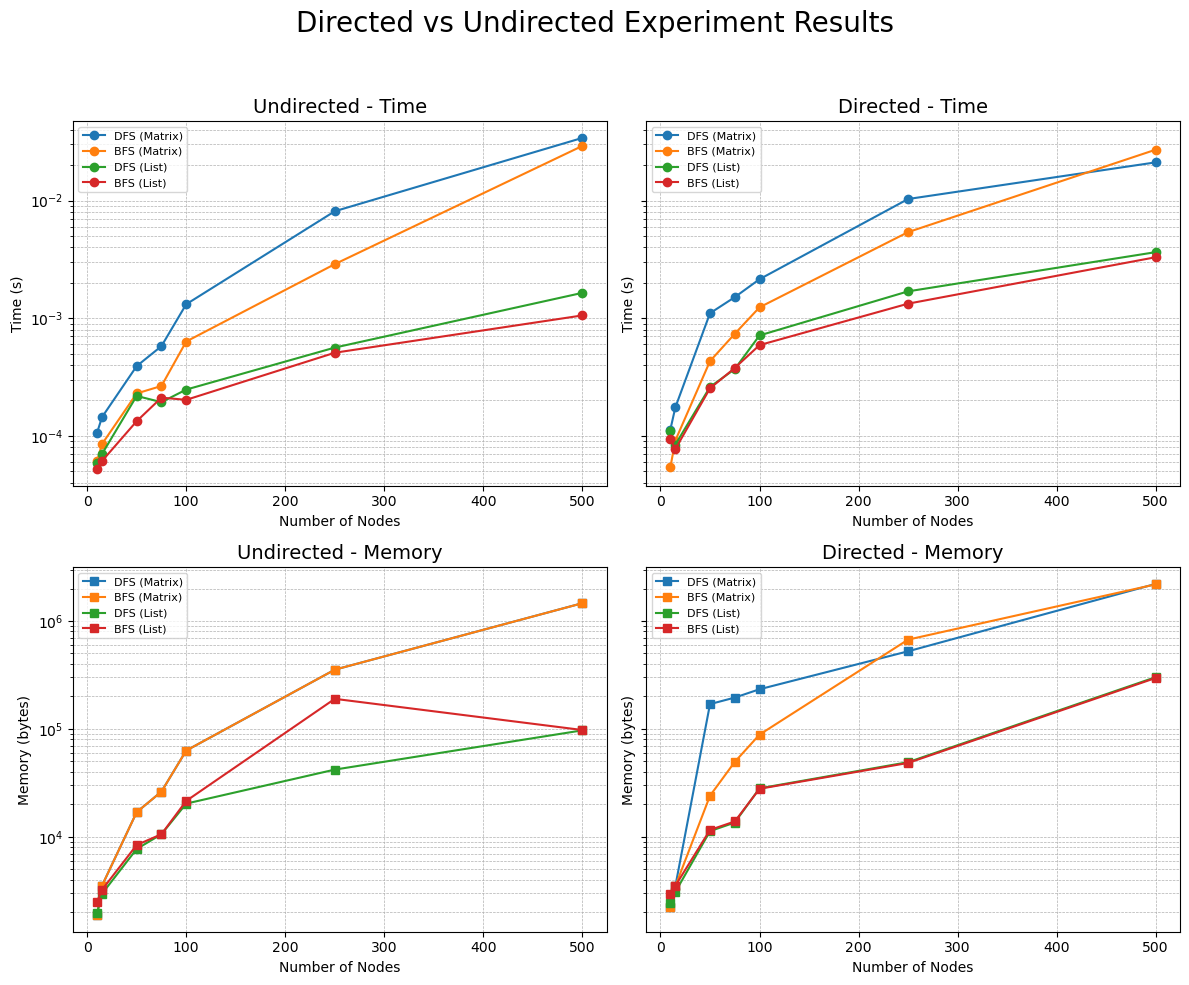

In [38]:
plot_experiment_results(df_results_1, title_prefix="Directed vs Undirected")

## Weighted vs Unweighted

In [39]:
def label_weighted(weighted):
    return "Weighted" if weighted else "Unweighted"

In [40]:
def create_weighted_vs_unweighted_graph(size, seed, weighted):
    G = create_graph_realistic(
        num_nodes=size,
        seed=seed,
        sparse=True,  
        directed=False,
        weighted=weighted,
        labeled=True,
        model="erdos_renyi"
    )

    if not nx.is_connected(G):
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()

    return G

# all_graphs_2 = generate_graph_variations(
#     node_sizes=node_sizes,
#     seeds=seeds,
#     variations=[False, True],  # weighted=False, weighted=True
#     graph_creator=create_weighted_vs_unweighted_graph,
#     visualizer=lambda G, size, weighted, folder: visualize_with_graphviz(G, name=f"{'weighted' if weighted else 'unweighted'}_{size}_nodes", folder=folder),
#     label_function=label_weighted,
#     folder_base="graphs/bfs_dfs"
# )

all_graphs_2 = generate_graph_variations(
    node_sizes=node_sizes,
    seeds=seeds,
    variations=[False, True],  # weighted=False, weighted=True
    graph_creator=create_weighted_vs_unweighted_graph,
    visualizer=lambda G, size, weighted, folder: visualize_graph_networkx(
        G,
        name=f"{'weighted' if weighted else 'unweighted'}_{size}_nodes",
        folder=folder,
        layout="kamada_kawai",
        directed=False
    ),
    label_function=label_weighted,
    folder_base="graphs/bfs_dfs"
)


In [41]:
print("Running weighted vs unweighted experiments...\n")
combined_results_2 = run_experiment_for_graphs(all_graphs_2, algo_wrappers)

print("\nGenerating performance table...\n")
df_results_2 = create_results_table(combined_results_2, all_graphs_2, label_weighted)

Running weighted vs unweighted experiments...

Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 650.38it/s]


        10 |     0.000043 ± 0.000024 |           1,880 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        10 |     0.000050 ± 0.000022 |           1,880 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 537.25it/s]


        15 |     0.000060 ± 0.000017 |           3,528 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 647.17it/s]


        15 |     0.000094 ± 0.000017 |           3,528 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 248.14it/s]


        50 |     0.000339 ± 0.000013 |          16,928 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 220.64it/s]


        50 |     0.000331 ± 0.000013 |          16,928 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 155.22it/s]


        75 |     0.000485 ± 0.000056 |          26,943 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 248.33it/s]


        75 |     0.000444 ± 0.000027 |          26,240 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 56.82it/s]


       100 |     0.001124 ± 0.000207 |          63,016 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 158.80it/s]


       100 |     0.000602 ± 0.000040 |          63,016 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 30.31it/s]


       250 |     0.005625 ± 0.002277 |         353,848 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 49.30it/s]

       250 |     0.003198 ± 0.000397 |         353,848 | N/A


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


       500 |     0.016395 ± 0.002789 |       1,463,084 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


       500 |     0.020126 ± 0.002527 |       1,462,788 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        10 |     0.000058 ± 0.000031 |           1,880 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 789.29it/s]


        10 |     0.000075 ± 0.000023 |           1,880 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 865.88it/s]


        15 |     0.000137 ± 0.000022 |           3,528 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 495.31it/s]


        15 |     0.000154 ± 0.000037 |           3,528 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 224.52it/s]


        50 |     0.000406 ± 0.000076 |          16,928 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 355.18it/s]


        50 |     0.000338 ± 0.000068 |          16,928 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 216.95it/s]


        75 |     0.000479 ± 0.000078 |          26,240 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 165.58it/s]


        75 |     0.000604 ± 0.000058 |          26,240 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 115.87it/s]


       100 |     0.001262 ± 0.000461 |          63,016 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 89.40it/s]


       100 |     0.001356 ± 0.000311 |          63,016 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


       250 |     0.006536 ± 0.002438 |         353,848 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 21.45it/s]

       250 |     0.006106 ± 0.001466 |         353,848 | N/A


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


       500 |     0.028444 ± 0.006707 |       1,462,148 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]

       500 |     0.018428 ± 0.000226 |       1,362,268 | N/A


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 660.62it/s]


        10 |     0.000037 ± 0.000019 |           1,960 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        10 |     0.000049 ± 0.000016 |           1,960 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 150.89it/s]


        15 |     0.000054 ± 0.000022 |           2,968 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        15 |     0.000100 ± 0.000045 |           2,968 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 372.03it/s]


        50 |     0.000215 ± 0.000036 |           7,720 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 400.99it/s]


        50 |     0.000152 ± 0.000039 |           7,720 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 497.19it/s]


        75 |     0.000225 ± 0.000040 |          10,576 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 447.30it/s]


        75 |     0.000136 ± 0.000042 |          10,576 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 217.67it/s]


       100 |     0.000413 ± 0.000079 |          20,312 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


       100 |     0.000244 ± 0.000041 |          20,312 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 174.35it/s]


       250 |     0.000577 ± 0.000213 |          41,976 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 125.33it/s]


       250 |     0.000865 ± 0.000148 |          41,976 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 92.35it/s]


       500 |     0.001157 ± 0.000353 |          96,992 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 92.94it/s]


       500 |     0.001149 ± 0.000126 |          96,992 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        10 |     0.000043 ± 0.000022 |           2,512 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 990.39it/s]


        10 |     0.000041 ± 0.000024 |           2,512 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 3163.13it/s]


        15 |     0.000048 ± 0.000017 |           3,232 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        15 |     0.000079 ± 0.000022 |           3,232 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 569.96it/s]


        50 |     0.000142 ± 0.000041 |           8,400 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        50 |     0.000119 ± 0.000038 |           8,400 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 462.28it/s]


        75 |     0.000145 ± 0.000030 |          10,576 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 211.99it/s]


        75 |     0.000126 ± 0.000038 |          10,576 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 288.21it/s]

       100 |     0.000343 ± 0.000037 |          21,520 | N/A


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 150.36it/s]


       100 |     0.000338 ± 0.000034 |          21,520 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 498.49it/s]

       250 |     0.000544 ± 0.000098 |          41,976 | N/A


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       250 |     0.000545 ± 0.000068 |          41,976 | N/A


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 153.43it/s]


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 180.82it/s]


       500 |     0.001287 ± 0.000288 |          97,672 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 69.86it/s]

       500 |     0.001115 ± 0.000379 |         246,130 | N/A

Generating performance table...


Algorithm Performance Table:
   Algorithm  Nodes Graph Type Time (s) Memory (bytes) Result
DFS (Matrix)     10 Unweighted 0.000043          1,880    N/A
DFS (Matrix)     10   Weighted 0.000050          1,880    N/A
DFS (Matrix)     15 Unweighted 0.000060          3,528    N/A
DFS (Matrix)     15   Weighted 0.000094          3,528    N/A
DFS (Matrix)     50 Unweighted 0.000339         16,928    N/A
DFS (Matrix)     50   Weighted 0.000331         16,928    N/A
DFS (Matrix)     75 Unweighted 0.000485         26,943    N/A
DFS (Matrix)     75   Weighted 0.000444         26,240    N/A
DFS (Matrix)    100 Unweighted 0.001124         63,016    N/A
DFS (Matrix)    100   Weighted 0.000602         63,016    N/A
DFS (Matrix)    250 Unweighted 0.005625        353,848    N/A
DFS (Matrix)    250   Weighted 0.003198        353,848    N/A
DFS (Matrix)    500 Unweighted 0.016395      1,463,084    N/A
DFS (Ma

Plot saved to graphs/bfs_dfs/plots_analysis\weighted_vs_unweighted_experiment_results.png


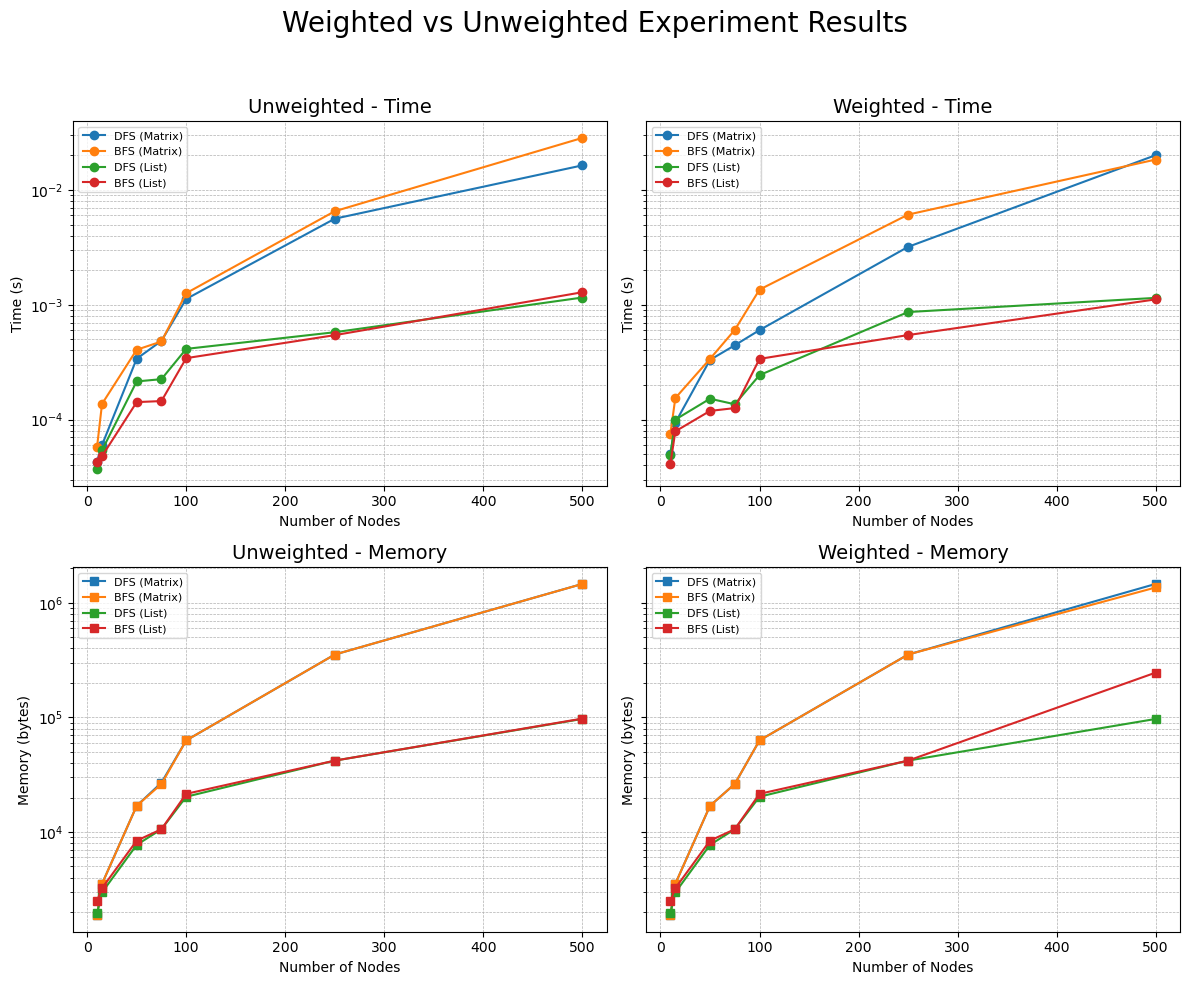

In [42]:
plot_experiment_results(df_results_2, title_prefix="Weighted vs Unweighted")

## Sparse vs Dense

In [43]:
def label_sparse(sparse):
    return "Sparse" if sparse else "Dense"

In [44]:
def create_sparse_vs_dense_graph(size, seed, sparse):
    G = create_graph_realistic(
        num_nodes=size,
        seed=seed,
        sparse=sparse,
        directed=False,
        weighted=False,
        labeled=True,
        model="erdos_renyi"
    )

    if not nx.is_connected(G):
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()

    return G

# all_graphs_3 = generate_graph_variations(
#     node_sizes=node_sizes,
#     seeds=seeds,
#     variations=[True, False],  
#     graph_creator=create_sparse_vs_dense_graph,
#     visualizer=lambda G, size, sparse, folder: visualize_with_graphviz(G, name=f"{'sparse' if sparse else 'dense'}_{size}_nodes", folder=folder),
#     label_function=label_sparse,
#     folder_base="graphs/bfs_dfs"
# )

all_graphs_3 = generate_graph_variations(
    node_sizes=node_sizes,
    seeds=seeds,
    variations=[True, False],  # sparse=True, sparse=False
    graph_creator=create_sparse_vs_dense_graph,
    visualizer=lambda G, size, sparse, folder: visualize_graph_networkx(
        G,
        name=f"{'sparse' if sparse else 'dense'}_{size}_nodes",
        folder=folder,
        layout="kamada_kawai",
        directed=False
    ),
    label_function=label_sparse,
    folder_base="graphs/bfs_dfs"
)

In [45]:
print("\nRunning sparse vs dense experiments...\n")
combined_results_3 = run_experiment_for_graphs(all_graphs_3, algo_wrappers)

print("\nGenerating performance table...\n")
df_results_3 = create_results_table(combined_results_3, all_graphs_3, label_sparse)


Running sparse vs dense experiments...

Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 562.01it/s]


        10 |     0.000040 ± 0.000019 |           1,880 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 765.66it/s]


        10 |     0.000097 ± 0.000018 |           2,248 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 540.99it/s]


        15 |     0.000076 ± 0.000027 |           3,528 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        15 |     0.000081 ± 0.000024 |           3,776 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 616.90it/s]


        50 |     0.000287 ± 0.000069 |          16,928 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 207.27it/s]


        50 |     0.000552 ± 0.000055 |          27,032 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 407.17it/s]


        75 |     0.000339 ± 0.000100 |          26,240 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 209.45it/s]


        75 |     0.000556 ± 0.000050 |          51,224 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 260.94it/s]


       100 |     0.000837 ± 0.000179 |          63,016 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 113.39it/s]


       100 |     0.001069 ± 0.000205 |          95,056 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 51.73it/s]


       250 |     0.002931 ± 0.000265 |         353,848 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 31.86it/s]


       250 |     0.004902 ± 0.000545 |         525,480 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


       500 |     0.021657 ± 0.001766 |       1,462,988 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


       500 |     0.030000 ± 0.011712 |       2,198,092 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 891.27it/s]


        10 |     0.000048 ± 0.000016 |           1,880 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 859.31it/s]


        10 |     0.000095 ± 0.000032 |           2,248 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 455.21it/s]


        15 |     0.000105 ± 0.000020 |           3,528 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 495.08it/s]


        15 |     0.000105 ± 0.000026 |           3,776 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 232.04it/s]


        50 |     0.000333 ± 0.000058 |          16,928 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 213.66it/s]


        50 |     0.000644 ± 0.000132 |          27,032 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 130.30it/s]


        75 |     0.000524 ± 0.000080 |          26,240 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 141.82it/s]


        75 |     0.000947 ± 0.000261 |          51,224 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 157.05it/s]


       100 |     0.000820 ± 0.000200 |          63,016 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 109.22it/s]


       100 |     0.001357 ± 0.000231 |          95,056 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 40.66it/s]


       250 |     0.003808 ± 0.000753 |         353,848 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 23.91it/s]


       250 |     0.005462 ± 0.000596 |         525,480 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


       500 |     0.025296 ± 0.004978 |       1,462,220 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


       500 |     0.021721 ± 0.004591 |       2,177,412 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 357.42it/s]


        10 |     0.000102 ± 0.000075 |           1,960 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 754.24it/s]


        10 |     0.000083 ± 0.000025 |           2,480 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        15 |     0.000111 ± 0.000022 |           2,968 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 86.42it/s]


        15 |     0.000096 ± 0.000026 |           3,840 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 414.58it/s]


        50 |     0.000182 ± 0.000043 |           7,720 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 192.22it/s]


        50 |     0.000512 ± 0.000057 |          11,880 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 364.98it/s]


        75 |     0.000159 ± 0.000027 |          10,576 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 202.08it/s]


        75 |     0.000419 ± 0.000086 |          13,184 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 154.26it/s]


       100 |     0.000318 ± 0.000063 |          20,312 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 101.27it/s]


       100 |     0.000802 ± 0.000512 |          27,656 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 176.88it/s]


       250 |     0.000546 ± 0.000066 |          41,976 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 20.25it/s]


       250 |     0.008337 ± 0.015132 |          49,232 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       500 |     0.002188 ± 0.000855 |          97,751 | N/A


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 49.86it/s]

Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------



Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       500 |     0.002903 ± 0.000848 |         151,288 | N/A


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 33.21it/s]


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 960.45it/s]


        10 |     0.000033 ± 0.000017 |           2,512 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        10 |     0.000055 ± 0.000019 |           2,976 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 497.49it/s]


        15 |     0.000048 ± 0.000018 |           3,232 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 832.86it/s]


        15 |     0.000077 ± 0.000032 |           3,672 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

        50 |     0.000153 ± 0.000048 |           8,400 | N/A

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 327.17it/s]



Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 314.93it/s]


        50 |     0.000265 ± 0.000085 |          11,880 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        75 |     0.000119 ± 0.000031 |          10,576 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

        75 |     0.000440 ± 0.000039 |          13,496 | N/A

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 184.66it/s]



Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


       100 |     0.000353 ± 0.000043 |          21,520 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 158.15it/s]


       100 |     0.000516 ± 0.000122 |          27,616 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 201.65it/s]


       250 |     0.000575 ± 0.000120 |          41,976 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 109.90it/s]


       250 |     0.001021 ± 0.000214 |          49,232 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 107.81it/s]


       500 |     0.001156 ± 0.000331 |          97,672 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 47.44it/s]


       500 |     0.003637 ± 0.000447 |         147,600 | N/A

Generating performance table...


Algorithm Performance Table:
   Algorithm  Nodes Graph Type Time (s) Memory (bytes) Result
DFS (Matrix)     10     Sparse 0.000040          1,880    N/A
DFS (Matrix)     10      Dense 0.000097          2,248    N/A
DFS (Matrix)     15     Sparse 0.000076          3,528    N/A
DFS (Matrix)     15      Dense 0.000081          3,776    N/A
DFS (Matrix)     50     Sparse 0.000287         16,928    N/A
DFS (Matrix)     50      Dense 0.000552         27,032    N/A
DFS (Matrix)     75     Sparse 0.000339         26,240    N/A
DFS (Matrix)     75      Dense 0.000556         51,224    N/A
DFS (Matrix)    100     Sparse 0.000837         63,016    N/A
DFS (Matrix)    100      Dense 0.001069         95,056    N/A
DFS (Matrix)    250     Sparse 0.002931        353,848    N/A
DFS (Matrix)    250      Dense 0.004902        525,480    N/A
DFS (Matrix)    500     Sparse 0.021657      1,462,988    N/A
DFS (Ma

Plot saved to graphs/bfs_dfs/plots_analysis\sparse_vs_dense_experiment_results.png


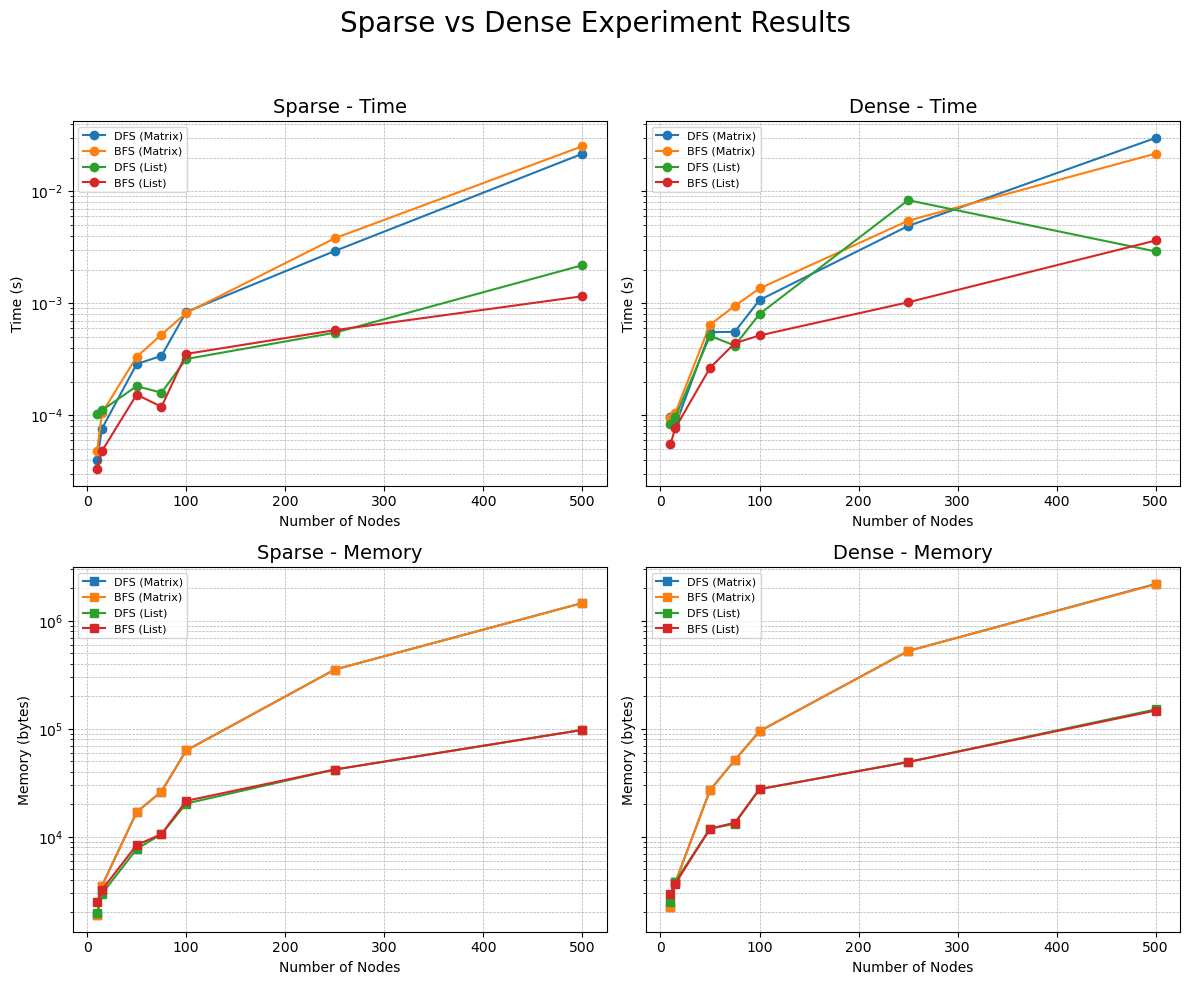

In [46]:
plot_experiment_results(df_results_3, title_prefix="Sparse vs Dense")

## Cyclic vs Acyclic

In [47]:
def label_cyclic(cyclic):
    return "Cyclic" if cyclic else "Acyclic"

In [48]:
def generate_connected_dag(n, seed=None):
    if seed is not None:
        random.seed(seed)

    G = nx.DiGraph()
    G.add_nodes_from(range(n))

    nodes = list(range(n))
    random.shuffle(nodes)

    for i in range(n - 1):
        G.add_edge(nodes[i], nodes[i + 1])

    possible_edges = []
    for i in range(n):
        for j in range(i + 1, n):
            if not G.has_edge(nodes[i], nodes[j]):
                possible_edges.append((nodes[i], nodes[j]))

    extra_edges = random.sample(possible_edges, min(len(possible_edges), 2 * n))
    G.add_edges_from(extra_edges)

    return G

In [49]:
def create_cyclic_vs_acyclic_graph(size, seed, cyclic):
    if cyclic:
        G = create_graph_realistic(
            num_nodes=size,
            seed=seed,
            sparse=True,
            directed=True,
            weighted=False,
            labeled=True,
            model="erdos_renyi"
        )
    else:
        G = generate_connected_dag(size, seed=seed)

    return G

# all_graphs_4 = generate_graph_variations(
#     node_sizes=node_sizes,
#     seeds=seeds,
#     variations=[True, False], 
#     graph_creator=create_cyclic_vs_acyclic_graph,
#     visualizer=lambda G, size, cyclic, folder: visualize_with_graphviz(G, name=f"{'cyclic' if cyclic else 'acyclic'}_{size}_nodes", folder=folder),
#     label_function=label_cyclic,
#     folder_base="graphs/bfs_dfs"
# )

all_graphs_4 = generate_graph_variations(
    node_sizes=node_sizes,
    seeds=seeds,
    variations=[True, False],  # cyclic=True, cyclic=False
    graph_creator=create_cyclic_vs_acyclic_graph,
    visualizer=lambda G, size, cyclic, folder: visualize_graph_networkx(
        G,
        name=f"{'cyclic' if cyclic else 'acyclic'}_{size}_nodes",
        folder=folder,
        layout="kamada_kawai",
        directed=True  # << always directed for cyclic and acyclic
    ),
    label_function=label_cyclic,
    folder_base="graphs/bfs_dfs"
)

In [50]:
print("\nRunning cyclic vs acyclic experiments...\n")
combined_results_4 = run_experiment_for_graphs(all_graphs_4, algo_wrappers)

print("\nGenerating performance table...\n")
df_results_4 = create_results_table(combined_results_4, all_graphs_4, label_cyclic)


Running cyclic vs acyclic experiments...

Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        10 |     0.000089 ± 0.000021 |           2,240 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        10 |     0.000077 ± 0.000025 |           2,320 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        15 |     0.000050 ± 0.000016 |           3,480 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 355.06it/s]


        15 |     0.000098 ± 0.000025 |           3,648 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 226.02it/s]


        50 |     0.000318 ± 0.000051 |          24,040 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 439.84it/s]


        50 |     0.000247 ± 0.000031 |          24,040 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 394.24it/s]


        75 |     0.000549 ± 0.000137 |          49,440 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 496.66it/s]


        75 |     0.000266 ± 0.000071 |          49,440 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 177.59it/s]


       100 |     0.000824 ± 0.000178 |          88,544 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 251.02it/s]


       100 |     0.000658 ± 0.000070 |          88,544 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 41.18it/s]


       250 |     0.004378 ± 0.000907 |         672,157 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 134.58it/s]


       250 |     0.001621 ± 0.000273 |         524,040 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


       500 |     0.024152 ± 0.002716 |       2,184,196 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 30.47it/s]


       500 |     0.004117 ± 0.000205 |       2,058,240 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 248.10it/s]


        10 |     0.000083 ± 0.000024 |           2,240 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 497.19it/s]


        10 |     0.000079 ± 0.000019 |           2,320 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 391.11it/s]


        15 |     0.000072 ± 0.000015 |           3,480 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 229.93it/s]


        15 |     0.000060 ± 0.000023 |           3,648 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 203.09it/s]


        50 |     0.000423 ± 0.000039 |          24,040 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 496.78it/s]


        50 |     0.000221 ± 0.000023 |          24,040 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 201.62it/s]


        75 |     0.000626 ± 0.000129 |          49,440 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 250.45it/s]


        75 |     0.000311 ± 0.000055 |          49,440 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 179.34it/s]


       100 |     0.000813 ± 0.000088 |          88,544 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 96.89it/s]


       100 |     0.000937 ± 0.000604 |          88,544 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 38.03it/s]


       250 |     0.003824 ± 0.000407 |         524,040 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 80.32it/s]

       250 |     0.001890 ± 0.000248 |         524,040 | N/A


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


       500 |     0.031825 ± 0.004587 |       2,183,108 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 27.21it/s]


       500 |     0.003605 ± 0.000615 |       2,181,303 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 285.62it/s]


        10 |     0.000065 ± 0.000024 |           2,160 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 529.99it/s]


        10 |     0.000060 ± 0.000024 |           2,184 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        15 |     0.000058 ± 0.000025 |           2,648 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        15 |     0.000159 ± 0.000066 |           2,904 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 124.09it/s]


        50 |     0.000385 ± 0.000070 |           9,280 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 168.71it/s]


        50 |     0.000260 ± 0.000092 |           9,960 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 114.15it/s]


        75 |     0.000345 ± 0.000087 |          10,512 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 117.29it/s]


        75 |     0.000454 ± 0.000039 |          11,752 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 172.86it/s]


       100 |     0.000568 ± 0.000081 |          23,480 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 180.87it/s]


       100 |     0.000526 ± 0.000108 |          18,736 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 80.70it/s]

       250 |     0.001184 ± 0.000312 |          39,792 | N/A


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 89.81it/s]


       250 |     0.001167 ± 0.000125 |          42,352 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 15.50it/s]

       500 |     0.010088 ± 0.014476 |          99,848 | N/A


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       500 |     0.003270 ± 0.000541 |          84,336 | N/A


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 39.04it/s]


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        10 |     0.000068 ± 0.000017 |           2,720 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        10 |     0.000064 ± 0.000016 |           2,744 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        15 |     0.000047 ± 0.000016 |           2,648 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        15 |     0.000054 ± 0.000019 |           3,464 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

        50 |     0.000143 ± 0.000042 |           9,960 | N/A

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 130.99it/s]



Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 649.78it/s]


        50 |     0.000149 ± 0.000032 |          10,512 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 305.80it/s]

        75 |     0.000195 ± 0.000060 |          11,208 | N/A


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 497.13it/s]


        75 |     0.000221 ± 0.000033 |          11,752 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 340.70it/s]


       100 |     0.000316 ± 0.000070 |          24,624 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 215.27it/s]


       100 |     0.000273 ± 0.000038 |          18,736 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 91.21it/s]


       250 |     0.000643 ± 0.000161 |          40,576 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 495.90it/s]


       250 |     0.000611 ± 0.000077 |          42,352 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 112.35it/s]


       500 |     0.001439 ± 0.000189 |         100,528 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 63.42it/s]

       500 |     0.002054 ± 0.001204 |          84,336 | N/A

Generating performance table...


Algorithm Performance Table:
   Algorithm  Nodes Graph Type Time (s) Memory (bytes) Result
DFS (Matrix)     10     Cyclic 0.000089          2,240    N/A
DFS (Matrix)     10    Acyclic 0.000077          2,320    N/A
DFS (Matrix)     15     Cyclic 0.000050          3,480    N/A
DFS (Matrix)     15    Acyclic 0.000098          3,648    N/A
DFS (Matrix)     50     Cyclic 0.000318         24,040    N/A
DFS (Matrix)     50    Acyclic 0.000247         24,040    N/A
DFS (Matrix)     75     Cyclic 0.000549         49,440    N/A
DFS (Matrix)     75    Acyclic 0.000266         49,440    N/A
DFS (Matrix)    100     Cyclic 0.000824         88,544    N/A
DFS (Matrix)    100    Acyclic 0.000658         88,544    N/A
DFS (Matrix)    250     Cyclic 0.004378        672,157    N/A
DFS (Matrix)    250    Acyclic 0.001621        524,040    N/A
DFS (Matrix)    500     Cyclic 0.024152      2,184,196    N/A
DFS (Ma

Plot saved to graphs/bfs_dfs/plots_analysis\cyclic_vs_acyclic_experiment_results.png


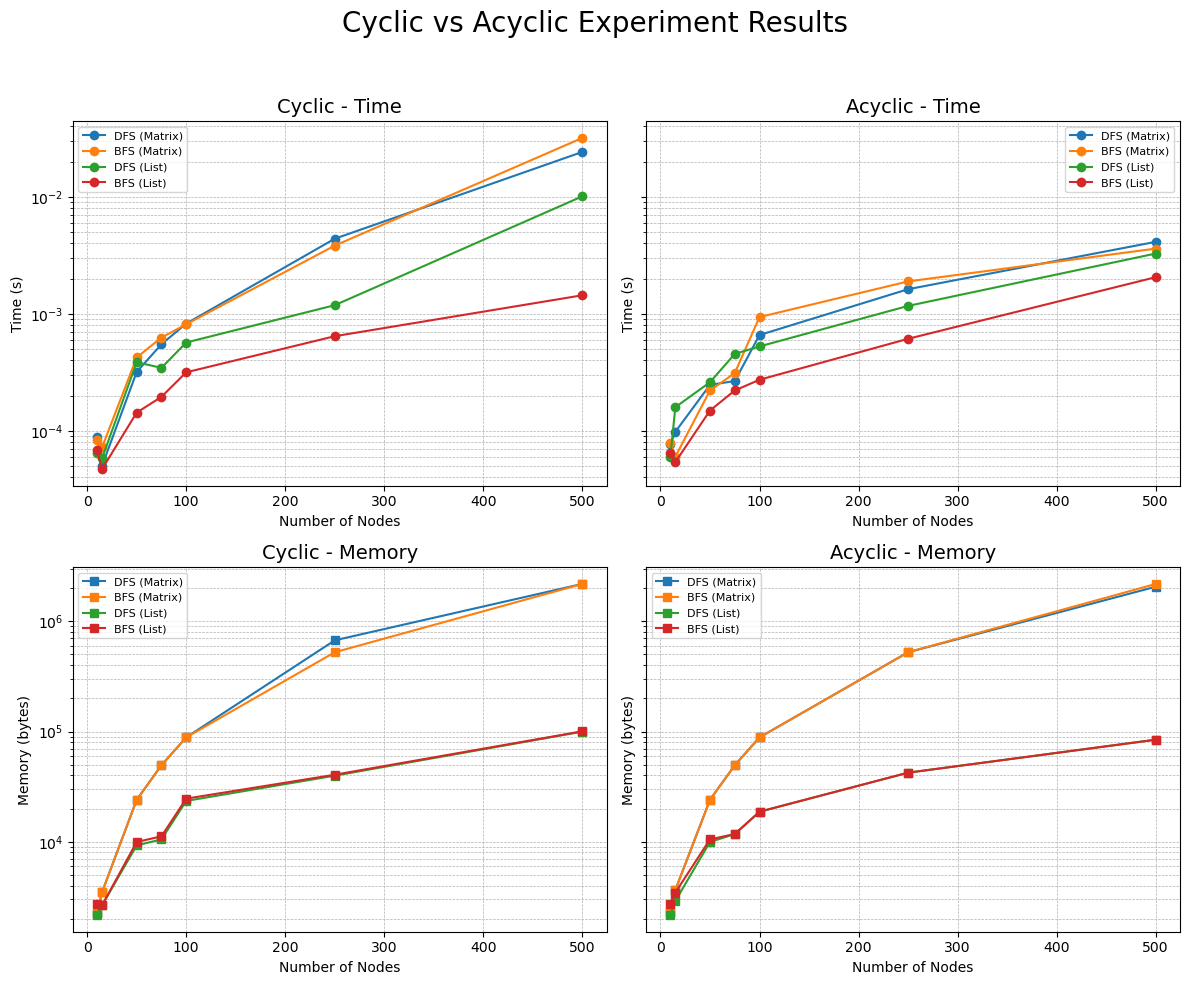

In [51]:
plot_experiment_results(df_results_4, title_prefix="Cyclic vs Acyclic")

## Connected vs Disconnected

In [52]:
def label_connected(connected):
    return "Connected" if connected else "Disconnected"

In [53]:
def create_connected_vs_disconnected_graph(size, seed, connected):
    if connected:
        G = create_graph_realistic(
            num_nodes=size,
            seed=seed,
            sparse=True,
            directed=False,
            weighted=False,
            labeled=True,
            model="erdos_renyi"
        )
        if not nx.is_connected(G):
            largest_cc = max(nx.connected_components(G), key=len)
            G = G.subgraph(largest_cc).copy()
    else:
        half = size // 2
        G1 = create_graph_realistic(
            num_nodes=half,
            seed=seed,
            sparse=True,
            directed=False,
            weighted=False,
            labeled=True,
            model="erdos_renyi"
        )
        G2 = create_graph_realistic(
            num_nodes=size - half,
            seed=seed + 1,
            sparse=True,
            directed=False,
            weighted=False,
            labeled=True,
            model="erdos_renyi"
        )
        G = nx.disjoint_union(G1, G2)

    return G

# all_graphs_5 = generate_graph_variations(
#     node_sizes=node_sizes,
#     seeds=seeds,
#     variations=[True, False],  
#     graph_creator=create_connected_vs_disconnected_graph,
#     visualizer=lambda G, size, connected, folder: visualize_with_graphviz(G, name=f"{'connected' if connected else 'disconnected'}_{size}_nodes", folder=folder),
#     label_function=label_connected,
#     folder_base="graphs/bfs_dfs"
# )

all_graphs_5 = generate_graph_variations(
    node_sizes=node_sizes,
    seeds=seeds,
    variations=[True, False],  # connected=True, connected=False
    graph_creator=create_connected_vs_disconnected_graph,
    visualizer=lambda G, size, connected, folder: visualize_graph_networkx(
        G,
        name=f"{'connected' if connected else 'disconnected'}_{size}_nodes",
        folder=folder,
        layout="kamada_kawai",
        directed=False
    ),
    label_function=label_connected,
    folder_base="graphs/bfs_dfs"
)

In [54]:
print("\nRunning connected vs disconnected experiments...\n")
combined_results_5 = run_experiment_for_graphs(all_graphs_5, algo_wrappers)

print("\nGenerating performance table...\n")
df_results_5 = create_results_table(combined_results_5, all_graphs_5, label_connected)


Running connected vs disconnected experiments...

Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        10 |     0.000089 ± 0.000024 |           1,880 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 198.08it/s]


        10 |     0.000068 ± 0.000027 |           2,456 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        15 |     0.000086 ± 0.000017 |           3,528 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        15 |     0.000060 ± 0.000016 |           4,192 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 293.90it/s]


        50 |     0.000273 ± 0.000066 |          16,928 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 387.29it/s]


        50 |     0.000243 ± 0.000047 |          27,032 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 165.56it/s]


        75 |     0.000506 ± 0.000030 |          26,240 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 168.21it/s]


        75 |     0.000543 ± 0.000101 |          52,432 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 90.03it/s]


       100 |     0.001237 ± 0.000095 |          63,016 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 69.46it/s]


       100 |     0.002173 ± 0.002220 |          95,056 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 34.83it/s]


       250 |     0.004623 ± 0.001145 |         353,848 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 52.03it/s]

       250 |     0.003245 ± 0.001125 |         537,592 | N/A


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


       500 |     0.015843 ± 0.001022 |       1,463,084 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


       500 |     0.025987 ± 0.006393 |       2,180,572 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        10 |     0.000037 ± 0.000017 |           1,880 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        10 |     0.000050 ± 0.000025 |           2,456 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 199.88it/s]


        15 |     0.000077 ± 0.000023 |           3,528 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        15 |     0.000052 ± 0.000021 |           4,192 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 190.42it/s]


        50 |     0.000275 ± 0.000065 |          16,928 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 734.43it/s]


        50 |     0.000166 ± 0.000046 |          27,032 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 184.65it/s]


        75 |     0.000339 ± 0.000046 |          26,240 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 270.04it/s]


        75 |     0.000335 ± 0.000048 |          52,432 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 126.64it/s]


       100 |     0.000726 ± 0.000079 |          63,016 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 246.49it/s]


       100 |     0.000579 ± 0.000082 |          95,056 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 47.53it/s]


       250 |     0.003242 ± 0.000267 |         353,848 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 55.43it/s]


       250 |     0.002470 ± 0.000454 |         537,592 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


       500 |     0.016350 ± 0.000900 |       1,462,476 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]


       500 |     0.014315 ± 0.000834 |       2,085,472 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 377.56it/s]


        10 |     0.000046 ± 0.000030 |           1,960 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        10 |     0.000046 ± 0.000022 |           2,296 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 486.63it/s]


        15 |     0.000062 ± 0.000029 |           2,968 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 808.31it/s]


        15 |     0.000060 ± 0.000024 |           3,208 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 338.52it/s]


        50 |     0.000223 ± 0.000031 |           7,720 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 339.18it/s]


        50 |     0.000177 ± 0.000082 |          10,376 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        75 |     0.000191 ± 0.000040 |          10,576 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 336.70it/s]


        75 |     0.000161 ± 0.000034 |          10,824 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 629.02it/s]


       100 |     0.000279 ± 0.000100 |          20,312 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


       100 |     0.000211 ± 0.000035 |          20,464 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 124.04it/s]


       250 |     0.000669 ± 0.000123 |         189,598 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 180.14it/s]


       250 |     0.000442 ± 0.000060 |          39,568 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 177.84it/s]


       500 |     0.001220 ± 0.000285 |          96,992 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 87.39it/s]


       500 |     0.001023 ± 0.000165 |          80,816 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 525.73it/s]


        10 |     0.000061 ± 0.000052 |           2,512 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 367.63it/s]


        10 |     0.000073 ± 0.000032 |           2,768 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 442.53it/s]


        15 |     0.000048 ± 0.000020 |           3,232 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 497.13it/s]


        15 |     0.000037 ± 0.000017 |           3,312 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 768.47it/s]


        50 |     0.000114 ± 0.000026 |           8,400 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 510.01it/s]


        50 |     0.000133 ± 0.000055 |          10,376 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

        75 |     0.000212 ± 0.000025 |          10,576 | N/A


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 841.38it/s]


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 707.06it/s]


        75 |     0.000152 ± 0.000037 |          11,432 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 492.52it/s]


       100 |     0.000221 ± 0.000050 |          21,520 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


       100 |     0.000249 ± 0.000076 |          20,464 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]

       250 |     0.000451 ± 0.000057 |          41,976 | N/A


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 173.83it/s]

       250 |     0.000497 ± 0.000188 |          39,568 | N/A


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 83.20it/s]

       500 |     0.001489 ± 0.000475 |          97,672 | N/A


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 86.35it/s]

       500 |     0.001487 ± 0.001195 |          80,816 | N/A

Generating performance table...


Algorithm Performance Table:
   Algorithm  Nodes   Graph Type Time (s) Memory (bytes) Result
DFS (Matrix)     10    Connected 0.000089          1,880    N/A
DFS (Matrix)     10 Disconnected 0.000068          2,456    N/A
DFS (Matrix)     15    Connected 0.000086          3,528    N/A
DFS (Matrix)     15 Disconnected 0.000060          4,192    N/A
DFS (Matrix)     50    Connected 0.000273         16,928    N/A
DFS (Matrix)     50 Disconnected 0.000243         27,032    N/A
DFS (Matrix)     75    Connected 0.000506         26,240    N/A
DFS (Matrix)     75 Disconnected 0.000543         52,432    N/A
DFS (Matrix)    100    Connected 0.001237         63,016    N/A
DFS (Matrix)    100 Disconnected 0.002173         95,056    N/A
DFS (Matrix)    250    Connected 0.004623        353,848    N/A
DFS (Matrix)    250 Disconnected 0.003245        537,592    N/A
DFS (Matrix)    500    Connected 0.015843  

Plot saved to graphs/bfs_dfs/plots_analysis\connected_vs_disconnected_experiment_results.png


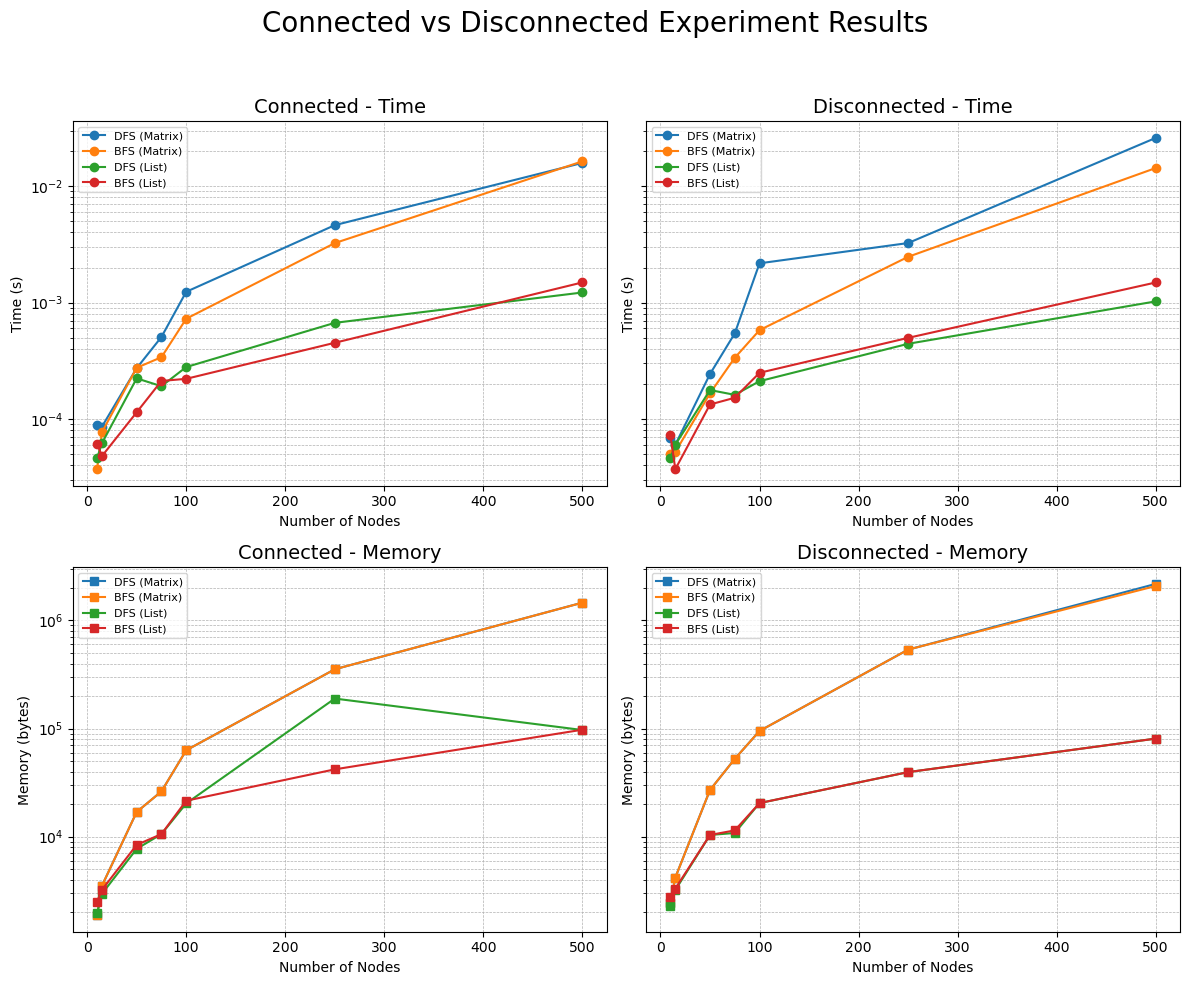

In [55]:
plot_experiment_results(df_results_5, title_prefix="Connected vs Disconnected")

## Self-Loops vs Without Self-Loops

In [56]:
def label_self_loops(has_loops):
    return "With Loops" if has_loops else "No Loops"

In [57]:
def create_loops_vs_no_loops_graph(size, seed, has_loops, loop_prob=0.3):
    """
    Creates a directed graph with or without self-loops.
    Self-loops are added randomly with probability `loop_prob` per node.
    """
    G = create_graph_realistic(
        num_nodes=size,
        seed=seed,
        sparse=True,
        directed=True,  
        weighted=False,
        labeled=True,
        model="erdos_renyi"
    )

    if not nx.is_weakly_connected(G):
        largest_cc = max(nx.weakly_connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()

    if has_loops:
        for node in G.nodes():
            if random.random() < loop_prob:
                G.add_edge(node, node)  # Add directed self-loop

    return G



all_graphs_loops = generate_graph_variations(
    node_sizes=node_sizes,
    seeds=seeds,
    variations=[False, True],
    graph_creator=create_loops_vs_no_loops_graph,
    visualizer=lambda G, size, has_loops, folder: visualize_graph_networkx(
        G,
        name=f"{'with_loops' if has_loops else 'no_loops'}_{size}_nodes",
        folder=folder,
        layout="kamada_kawai",
        directed=True 
    ),
    label_function=label_self_loops,
    folder_base="graphs/bfs_dfs"
)

In [58]:
print("\nRunning with loops vs no loops experiments...\n")
combined_results_loops = run_experiment_for_graphs(all_graphs_loops, algo_wrappers)

print("\nGenerating performance table...\n")
df_results_loops = create_results_table(combined_results_loops, all_graphs_loops, label_self_loops)


Running with loops vs no loops experiments...

Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 134.36it/s]


        10 |     0.000077 ± 0.000024 |           2,240 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 645.87it/s]


        10 |     0.000076 ± 0.000017 |           2,240 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 265.29it/s]


        15 |     0.000153 ± 0.000148 |           3,480 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 248.52it/s]


        15 |     0.000401 ± 0.000673 |           3,480 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 248.52it/s]


        50 |     0.000489 ± 0.000051 |          24,040 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 248.27it/s]


        50 |     0.000475 ± 0.000025 |          24,040 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 77.20it/s]


        75 |     0.001961 ± 0.002739 |          47,056 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 192.87it/s]


        75 |     0.000704 ± 0.000141 |          47,056 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 123.20it/s]


       100 |     0.001264 ± 0.000215 |          88,544 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 127.42it/s]


       100 |     0.001085 ± 0.000261 |          88,544 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 40.54it/s]

       250 |     0.003844 ± 0.000719 |         495,992 | N/A


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 32.39it/s]

       250 |     0.004886 ± 0.000921 |         495,992 | N/A


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


       500 |     0.034185 ± 0.002780 |       2,104,324 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


       500 |     0.017343 ± 0.002444 |       2,104,188 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 543.51it/s]


        10 |     0.000094 ± 0.000023 |           2,240 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        10 |     0.000106 ± 0.000034 |           2,240 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        15 |     0.000078 ± 0.000032 |           3,480 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        15 |     0.000073 ± 0.000017 |           3,480 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 183.64it/s]


        50 |     0.000349 ± 0.000116 |          24,040 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        50 |     0.000256 ± 0.000019 |          24,040 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 236.29it/s]


        75 |     0.000438 ± 0.000027 |          47,056 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 426.21it/s]


        75 |     0.000528 ± 0.000133 |          47,056 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 123.47it/s]


       100 |     0.000833 ± 0.000141 |         232,307 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 206.28it/s]


       100 |     0.000765 ± 0.000114 |          88,544 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 38.98it/s]


       250 |     0.003934 ± 0.000562 |         495,992 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 37.07it/s]


       250 |     0.004095 ± 0.000354 |         495,992 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


       500 |     0.023624 ± 0.001092 |       2,103,348 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


       500 |     0.026588 ± 0.002782 |       2,103,236 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        10 |     0.000043 ± 0.000014 |           2,160 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 507.54it/s]


        10 |     0.000070 ± 0.000021 |           2,160 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 1905.64it/s]


        15 |     0.000059 ± 0.000018 |           2,648 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        15 |     0.000037 ± 0.000017 |           2,648 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 332.80it/s]


        50 |     0.000240 ± 0.000047 |           9,280 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 271.30it/s]


        50 |     0.000168 ± 0.000035 |           9,432 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 248.57it/s]


        75 |     0.000350 ± 0.000044 |          10,512 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 496.84it/s]


        75 |     0.000323 ± 0.000035 |          10,992 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 248.63it/s]


       100 |     0.000436 ± 0.000052 |          23,480 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 124.26it/s]


       100 |     0.000468 ± 0.000054 |          23,848 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 422.98it/s]


       250 |     0.000870 ± 0.000264 |          39,792 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 59.87it/s]


       250 |     0.001515 ± 0.000501 |         188,838 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 53.19it/s]


       500 |     0.002103 ± 0.000500 |          99,848 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       500 |     0.001877 ± 0.000448 |         249,455 | N/A

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 46.12it/s]



Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 202.21it/s]


        10 |     0.000076 ± 0.000028 |           2,720 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 335.87it/s]

        10 |     0.000051 ± 0.000018 |           2,720 | N/A


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 248.70it/s]


        15 |     0.000050 ± 0.000022 |           2,648 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        15 |     0.000043 ± 0.000017 |           2,648 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 569.49it/s]


        50 |     0.000155 ± 0.000027 |           9,960 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        50 |     0.000265 ± 0.000060 |          10,112 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 283.63it/s]


        75 |     0.000208 ± 0.000048 |          11,208 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 408.68it/s]


        75 |     0.000195 ± 0.000036 |          11,688 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 220.39it/s]


       100 |     0.000397 ± 0.000101 |          24,624 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       100 |     0.000347 ± 0.000105 |          24,992 | N/A

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 162.68it/s]



Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 158.92it/s]

       250 |     0.000830 ± 0.000262 |          40,520 | N/A


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 95.89it/s]


       250 |     0.000695 ± 0.000122 |          41,440 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 70.44it/s]

       500 |     0.001604 ± 0.000548 |         100,528 | N/A


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 71.94it/s]


       500 |     0.001626 ± 0.000314 |         102,056 | N/A

Generating performance table...


Algorithm Performance Table:
   Algorithm  Nodes Graph Type Time (s) Memory (bytes) Result
DFS (Matrix)     10   No Loops 0.000077          2,240    N/A
DFS (Matrix)     10 With Loops 0.000076          2,240    N/A
DFS (Matrix)     15   No Loops 0.000153          3,480    N/A
DFS (Matrix)     15 With Loops 0.000401          3,480    N/A
DFS (Matrix)     50   No Loops 0.000489         24,040    N/A
DFS (Matrix)     50 With Loops 0.000475         24,040    N/A
DFS (Matrix)     75   No Loops 0.001961         47,056    N/A
DFS (Matrix)     75 With Loops 0.000704         47,056    N/A
DFS (Matrix)    100   No Loops 0.001264         88,544    N/A
DFS (Matrix)    100 With Loops 0.001085         88,544    N/A
DFS (Matrix)    250   No Loops 0.003844        495,992    N/A
DFS (Matrix)    250 With Loops 0.004886        495,992    N/A
DFS (Matrix)    500   No Loops 0.034185      2,104,324    N/A
DFS (Ma

Plot saved to graphs/bfs_dfs/plots_analysis\with_loops_vs_no_loops_experiment_results.png


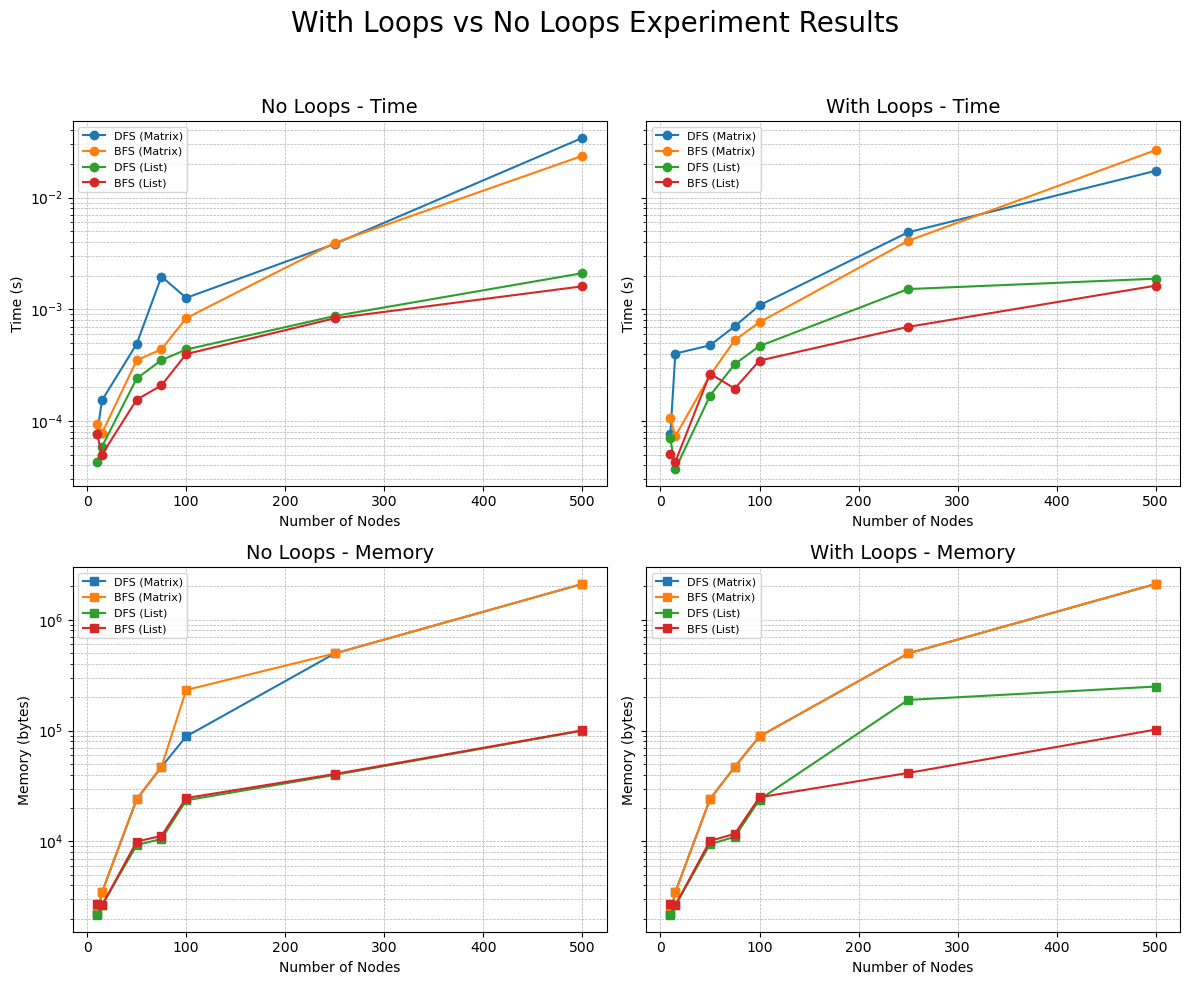

In [59]:

plot_experiment_results(df_results_loops, title_prefix="With Loops vs No Loops")

## Trees

In [60]:
def label_tree(_):
    return "Tree"

In [61]:
def generate_random_tree(num_nodes, seed=None):
    if seed is not None:
        random.seed(seed)
    return nx.random_tree(num_nodes, seed=seed)

In [62]:
def create_tree_graph(size, seed, _):
    return generate_random_tree(num_nodes=size, seed=seed)

# all_graphs_6 = generate_graph_variations(
#     node_sizes=node_sizes,
#     seeds=seeds,
#     variations=["tree"], 
#     graph_creator=create_tree_graph,
#     visualizer=lambda G, size, _, folder: visualize_with_networkx(G, name=f"tree_{size}_nodes", folder="graphs/tree", layout="kamada_kawai"),
#     folder_base="graphs/bfs_dfs/tree"
# )

all_graphs_6 = generate_graph_variations(
    node_sizes=node_sizes,
    seeds=seeds,
    variations=["tree"], 
    graph_creator=create_tree_graph,
    visualizer=lambda G, size, _, folder: visualize_graph_networkx(
        G,
        name=f"tree_{size}_nodes",
        folder="graphs/bfs_dfs/tree",
        layout="kamada_kawai",
        directed=False
    ),
    folder_base="graphs/bfs_dfs/tree"
)


In [63]:
print("\nRunning tree experiments...\n")
combined_results_6 = run_experiment_for_graphs(all_graphs_6, algo_wrappers)

print("\nGenerating performance table...\n")
df_results_6 = create_results_table(combined_results_6, all_graphs_6, label_tree)


Running tree experiments...

Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 639.96it/s]


        10 |     0.000043 ± 0.000023 |           2,456 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 642.61it/s]


        15 |     0.000056 ± 0.000016 |           4,192 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 211.76it/s]


        50 |     0.000441 ± 0.000058 |          27,032 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 137.06it/s]


        75 |     0.000642 ± 0.000161 |          52,432 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 153.65it/s]


       100 |     0.000845 ± 0.000070 |          95,056 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 29.72it/s]


       250 |     0.004941 ± 0.000302 |         537,592 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


       500 |     0.031669 ± 0.004789 |       2,180,836 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        10 |     0.000043 ± 0.000019 |           2,456 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 637.72it/s]


        15 |     0.000111 ± 0.000031 |           4,192 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 269.97it/s]


        50 |     0.000369 ± 0.000088 |          27,032 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 190.77it/s]


        75 |     0.000654 ± 0.000117 |          52,432 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 166.00it/s]


       100 |     0.000888 ± 0.000125 |          95,056 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


       250 |     0.013689 ± 0.014339 |         685,886 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


       500 |     0.024113 ± 0.004619 |       2,181,620 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 580.45it/s]


        10 |     0.000078 ± 0.000038 |           2,344 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 271.92it/s]


        15 |     0.000075 ± 0.000019 |           3,504 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        50 |     0.000140 ± 0.000023 |          10,632 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 180.18it/s]


        75 |     0.000299 ± 0.000047 |          12,304 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 134.71it/s]


       100 |     0.000293 ± 0.000061 |          24,008 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 109.53it/s]


       250 |     0.000806 ± 0.000185 |          44,376 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 72.70it/s]


       500 |     0.001646 ± 0.000454 |         252,160 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 427.95it/s]


        10 |     0.000053 ± 0.000016 |           2,768 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        15 |     0.000043 ± 0.000018 |           3,520 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 497.25it/s]


        50 |     0.000114 ± 0.000024 |          10,632 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 263.11it/s]


        75 |     0.000200 ± 0.000037 |          12,464 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 246.93it/s]


       100 |     0.000294 ± 0.000059 |          25,312 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 91.67it/s]


       250 |     0.000740 ± 0.000373 |          44,376 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 64.50it/s]

       500 |     0.001390 ± 0.000456 |         253,257 | N/A

Generating performance table...


Algorithm Performance Table:
   Algorithm  Nodes Graph Type Time (s) Memory (bytes) Result
DFS (Matrix)     10       Tree 0.000043          2,456    N/A
DFS (Matrix)     15       Tree 0.000056          4,192    N/A
DFS (Matrix)     50       Tree 0.000441         27,032    N/A
DFS (Matrix)     75       Tree 0.000642         52,432    N/A
DFS (Matrix)    100       Tree 0.000845         95,056    N/A
DFS (Matrix)    250       Tree 0.004941        537,592    N/A
DFS (Matrix)    500       Tree 0.031669      2,180,836    N/A
BFS (Matrix)     10       Tree 0.000043          2,456    N/A
BFS (Matrix)     15       Tree 0.000111          4,192    N/A
BFS (Matrix)     50       Tree 0.000369         27,032    N/A
BFS (Matrix)     75       Tree 0.000654         52,432    N/A
BFS (Matrix)    100       Tree 0.000888         95,056    N/A
BFS (Matrix)    250       Tree 0.013689        685,886    N/A
BFS (Ma

Plot saved to graphs/bfs_dfs/plots_analysis\trees_experiment_results.png


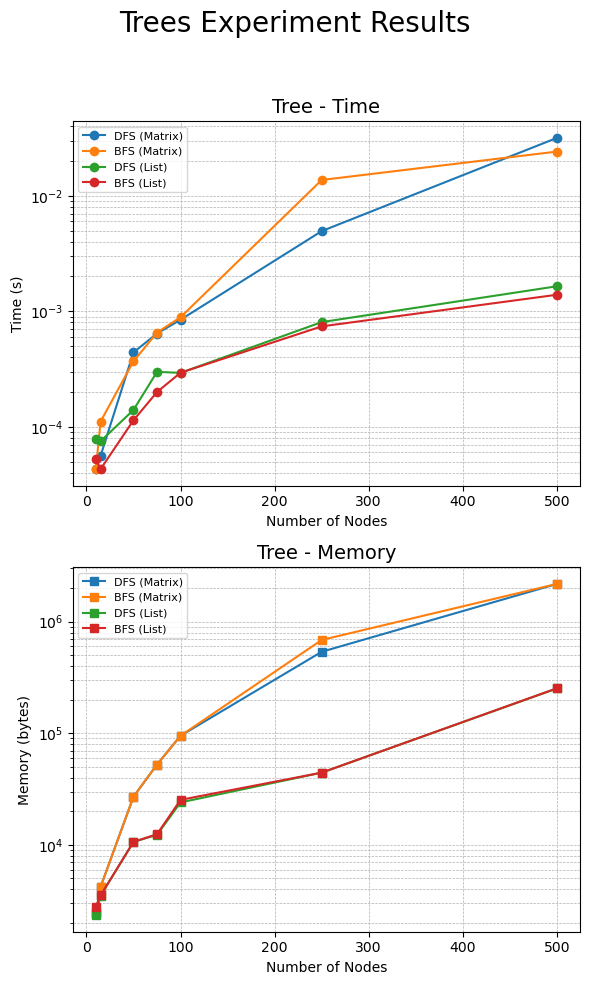

In [64]:
plot_experiment_results(df_results_6, title_prefix="Trees")

# PART II: Dijkstra and Floyd–Warshall

In [65]:
import heapq

def dijkstra(graph, start=None):
    adj_list = graph_to_adj_list_weighted(graph)

    # Find a valid start node if not provided
    if start is None:
        start = next((node for node in adj_list if adj_list[node]), None)
        if start is None:
            raise ValueError("No valid start node with outgoing edges.")

    distances = {node: math.inf for node in adj_list}
    distances[start] = 0
    visited = set()

    while len(visited) < len(adj_list):
        u = min((node for node in adj_list if node not in visited),
                key=lambda node: distances[node],
                default=None)

        if u is None or distances[u] == math.inf:
            break  # Remaining nodes are unreachable

        visited.add(u)

        for v, weight in adj_list[u]:
            if distances[u] + weight < distances[v]:
                distances[v] = distances[u] + weight

    return distances

In [66]:
def dijkstra_optimized(graph, start=None):
    adj_list = graph_to_adj_list_weighted(graph)

    if not adj_list:
        return {}

    # Auto-select a valid start node if not provided
    if start is None:
        start = next((node for node in adj_list if adj_list[node]), None)
        if start is None:
            raise ValueError("No valid start node with outgoing edges.")

    distances = {node: math.inf for node in adj_list}
    distances[start] = 0
    heap = [(0, start)]

    while heap:
        current_distance, u = heapq.heappop(heap)

        if current_distance > distances[u]:
            continue

        for v, weight in adj_list.get(u, []):  # Use .get to avoid KeyError
            if v not in distances:
                continue  # Skip malformed graphs
            distance = current_distance + weight
            if distance < distances[v]:
                distances[v] = distance
                heapq.heappush(heap, (distance, v))

    return distances

In [67]:
def floyd_warshall(graph):
    matrix, nodes = graph_to_adj_matrix(graph)
    n = len(matrix)
    
    # Initialize distances: if no direct edge, set to infinity (math.inf)
    dist = [[math.inf if i != j and matrix[i][j] == 0 else matrix[i][j] for j in range(n)] for i in range(n)]
    
    for k in range(n):
        for i in range(n):
            for j in range(n):
                if dist[i][k] + dist[k][j] < dist[i][j]:
                    dist[i][j] = dist[i][k] + dist[k][j]
    
    return dist

In [68]:
def floyd_warshall_optimized(graph):
    matrix, nodes = graph_to_adj_matrix(graph)
    n = len(matrix)

    matrix = np.array(matrix, dtype=float) 
    dist = np.where((matrix == 0) & (np.eye(n) == 0), np.inf, matrix)

    for k in range(n):
        dist = np.minimum(dist, dist[:, k, np.newaxis] + dist[k, :])

    return dist.tolist()

In [69]:
algo_wrappers_2 = [
    ("Floyd–Warshall", lambda G: floyd_warshall(G)),
    ("Floyd–Warshall (NumPy)", lambda G: floyd_warshall_optimized(G)),
    ("Dijkstra", lambda G: dijkstra(G)),
    ("Dijkstra (Optimized)", lambda G: dijkstra_optimized(G))
]

## Sparse vs Dense

In [70]:
def label_sparse_weighted(sparse):
    return "Sparse (Weighted)" if sparse else "Dense (Weighted)"

In [71]:
def create_sparse_vs_dense_weighted_graph(size, seed, sparse):
    G = create_graph_realistic(
        num_nodes=size,
        seed=seed,
        sparse=sparse,
        directed=False,
        weighted=True,
        labeled=True,
        model="erdos_renyi"
    )
    
    if not nx.is_connected(G):
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()

    return G

all_graphs_sparse_dense_weighted = generate_graph_variations(
    node_sizes=node_sizes,
    seeds=seeds,
    variations=[True, False],  # sparse=True, sparse=False
    graph_creator=create_sparse_vs_dense_weighted_graph,
    visualizer=lambda G, size, sparse, folder: visualize_graph_networkx(
        G,
        name=f"{'sparse_weighted' if sparse else 'dense_weighted'}_{size}_nodes",
        folder=folder,
        layout="kamada_kawai",
        directed=False
    ),
    label_function=label_sparse_weighted,
    folder_base="graphs/dijkstra_floyd"
)


In [72]:
print("\nRunning Floyd–Warshall and Dijkstra experiments (weighted sparse/dense graphs)...\n")
combined_results_7 = run_experiment_for_graphs(all_graphs_sparse_dense_weighted, algo_wrappers_2)

print("\nGenerating performance table...\n")
df_results_7 = create_results_table(combined_results_7, all_graphs_sparse_dense_weighted, label_sparse_weighted)


Running Floyd–Warshall and Dijkstra experiments (weighted sparse/dense graphs)...

Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 568.49it/s]


        10 |     0.000183 ± 0.000038 |           1,880 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 242.17it/s]


        10 |     0.000256 ± 0.000051 |           3,176 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        15 |     0.000636 ± 0.000080 |           4,712 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 158.89it/s]


        15 |     0.000970 ± 0.000107 |           5,144 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


        50 |     0.011354 ± 0.000302 |          29,000 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

        50 |     0.028849 ± 0.001116 |          45,032 | N/A

Running experiments: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]



Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

        75 |     0.030417 ± 0.003375 |          43,488 | N/A


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


        75 |     0.107878 ± 0.013537 |          94,952 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


       100 |     0.108730 ± 0.019988 |         123,472 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


       100 |     0.191648 ± 0.055390 |         175,960 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:07<00:00,  7.85s/it]


       250 |     1.220608 ± 0.304396 |         811,784 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:10<00:00, 10.67s/it]


       250 |     1.690944 ± 0.184026 |       1,196,160 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [01:26<00:00, 86.50s/it]


       500 |     8.373427 ± 0.375144 |       2,951,040 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [04:29<00:00, 269.28s/it]


       500 |    17.394627 ± 3.414601 |       4,283,520 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 178.21it/s]


        10 |     0.000231 ± 0.000088 |           6,984 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 241.02it/s]


        10 |     0.000191 ± 0.000057 |           7,612 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        15 |     0.000330 ± 0.000208 |          10,664 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 506.19it/s]


        15 |     0.000407 ± 0.000168 |          12,136 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 77.13it/s]


        50 |     0.001660 ± 0.001860 |          79,928 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 42.00it/s]


        50 |     0.002165 ± 0.000896 |         123,848 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 47.93it/s]


        75 |     0.002206 ± 0.001240 |         119,032 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 22.90it/s]


        75 |     0.003331 ± 0.000985 |         268,424 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       100 |     0.005218 ± 0.000946 |         336,960 | N/A

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 18.68it/s]

Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 13.92it/s]

       100 |     0.006792 ± 0.001242 |         635,064 | N/A


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


       250 |     0.038207 ± 0.022542 |       2,082,344 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


       250 |     0.038626 ± 0.005439 |       2,946,528 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


       500 |     0.555619 ± 0.029634 |       7,895,892 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:06<00:00,  6.55s/it]


       500 |     1.008689 ± 0.081340 |      11,988,348 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 629.78it/s]


        10 |     0.000208 ± 0.000100 |           2,168 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 283.74it/s]


        10 |     0.000196 ± 0.000016 |           2,520 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 775.72it/s]


        15 |     0.000171 ± 0.000049 |           2,744 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 496.84it/s]


        15 |     0.000240 ± 0.000013 |           3,128 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 91.75it/s]


        50 |     0.001098 ± 0.000183 |           6,648 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 69.20it/s]


        50 |     0.001266 ± 0.000488 |          10,344 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 123.67it/s]


        75 |     0.001169 ± 0.000182 |           9,032 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 64.96it/s]


        75 |     0.001820 ± 0.000207 |          10,920 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 46.34it/s]


       100 |     0.003374 ± 0.000312 |          17,960 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 41.83it/s]


       100 |     0.003705 ± 0.000697 |          27,367 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       250 |     0.014527 ± 0.002273 |          42,720 | N/A

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]



Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 10.36it/s]

       250 |     0.016275 ± 0.002619 |          51,016 | N/A


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


       500 |     0.048614 ± 0.014532 |         109,832 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


       500 |     0.102695 ± 0.027961 |         159,568 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        10 |     0.000048 ± 0.000017 |           1,480 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        10 |     0.000094 ± 0.000024 |           1,832 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 360.58it/s]


        15 |     0.000065 ± 0.000020 |           2,152 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        15 |     0.000111 ± 0.000051 |           2,536 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 569.80it/s]


        50 |     0.000136 ± 0.000028 |           4,720 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 259.53it/s]


        50 |     0.000364 ± 0.000069 |           9,048 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        75 |     0.000222 ± 0.000067 |           7,800 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 117.43it/s]


        75 |     0.000660 ± 0.000074 |           9,176 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 156.84it/s]


       100 |     0.000494 ± 0.000027 |           8,736 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 114.16it/s]


       100 |     0.001125 ± 0.000102 |          18,672 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 72.87it/s]


       250 |     0.001048 ± 0.000257 |          37,464 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 42.20it/s]


       250 |     0.002980 ± 0.000296 |          45,176 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       500 |     0.002240 ± 0.000565 |          78,376 | N/A


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 47.55it/s]


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       500 |     0.007007 ± 0.000979 |         139,768 | N/A


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


Generating performance table...


Algorithm Performance Table:
             Algorithm  Nodes        Graph Type  Time (s) Memory (bytes) Result
        Floyd–Warshall     10 Sparse (Weighted)  0.000183          1,880    N/A
        Floyd–Warshall     10  Dense (Weighted)  0.000256          3,176    N/A
        Floyd–Warshall     15 Sparse (Weighted)  0.000636          4,712    N/A
        Floyd–Warshall     15  Dense (Weighted)  0.000970          5,144    N/A
        Floyd–Warshall     50 Sparse (Weighted)  0.011354         29,000    N/A
        Floyd–Warshall     50  Dense (Weighted)  0.028849         45,032    N/A
        Floyd–Warshall     75 Sparse (Weighted)  0.030417         43,488    N/A
        Floyd–Warshall     75  Dense (Weighted)  0.107878         94,952    N/A
        Floyd–Warshall    100 Sparse (Weighted)  0.108730        123,472    N/A
        Floyd–Warshall    100  Dense (Weighted)  0.191648        175,960    N/A
        Floyd–Warshall    250 Sparse (Weighted)  1.22060

Plot saved to graphs/dijkstra_floyd/plots_analysis\floyd–warshall_and_dijkstra_sparse_vs_dense_(weighted_graphs)_experiment_results.png


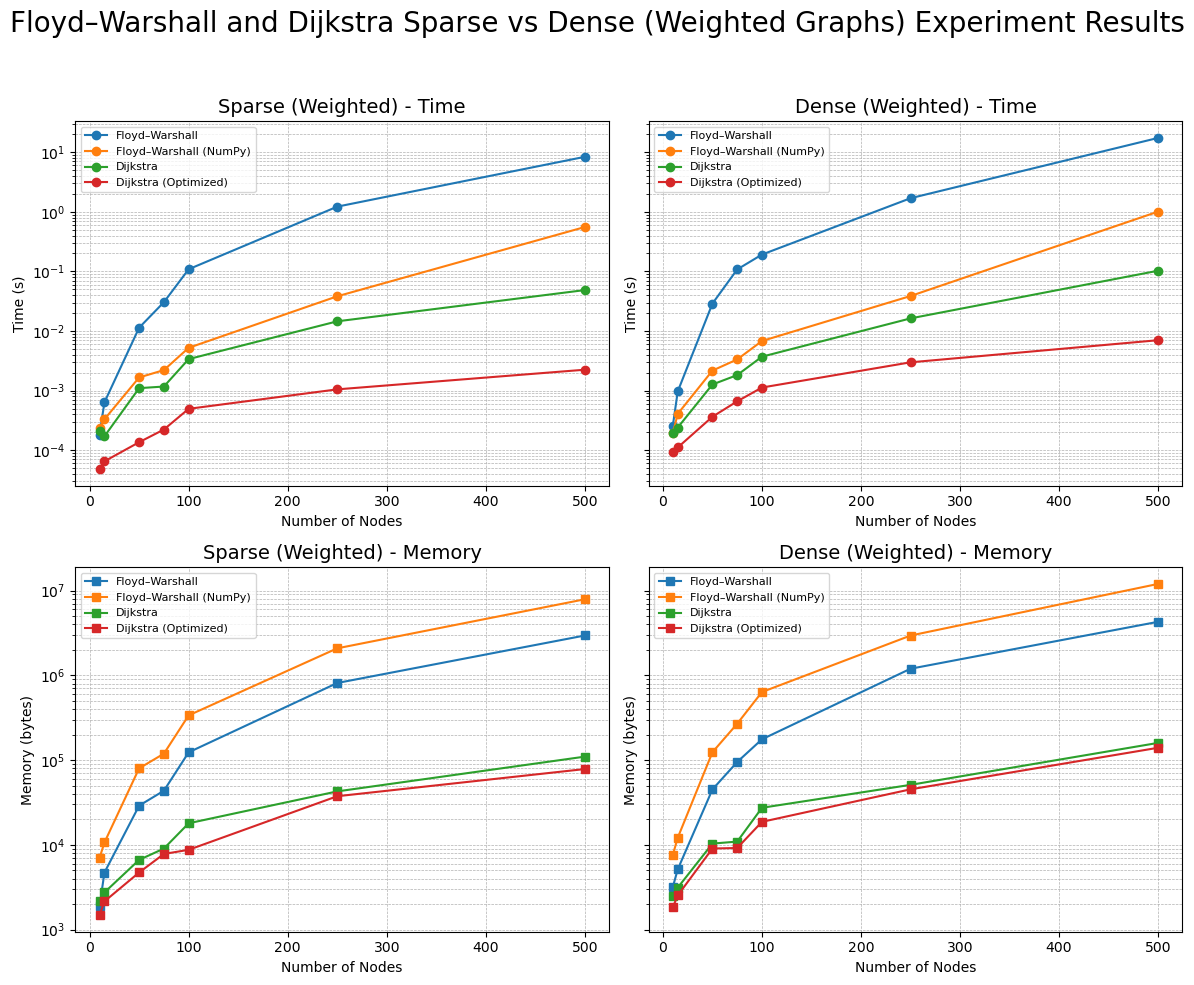

In [73]:
plot_experiment_results(
    df_results_7,
    title_prefix="Floyd–Warshall and Dijkstra Sparse vs Dense (Weighted Graphs)",
    save_folder="graphs/dijkstra_floyd/plots_analysis"
)

## Directed vs Undirected

In [74]:
def label_directed_graph_fd(directed):
    return "Directed" if directed else "Undirected"

In [75]:
def create_directed_vs_undirected_graph_weighted(size, seed, directed):
    G = create_graph_realistic(
        num_nodes=size,
        seed=seed,
        sparse=True, 
        directed=directed,
        weighted=True,
        labeled=True,
        model="erdos_renyi"
    )

    if directed:
        if not nx.is_weakly_connected(G):
            largest_cc = max(nx.weakly_connected_components(G), key=len)
            G = G.subgraph(largest_cc).copy()
    else:
        if not nx.is_connected(G):
            largest_cc = max(nx.connected_components(G), key=len)
            G = G.subgraph(largest_cc).copy()

    return G

all_graphs_directed_weighted = generate_graph_variations(
    node_sizes=node_sizes,
    seeds=seeds,
    variations=[False, True],  
    graph_creator=create_directed_vs_undirected_graph_weighted,
    visualizer=lambda G, size, directed, folder: visualize_graph_networkx(
        G,
        name=f"{'directed' if directed else 'undirected'}_{size}_nodes_weighted",
        folder=folder,
        layout="kamada_kawai",
        directed=directed
    ),
    label_function=label_directed_graph_fd,
    folder_base="graphs/dijkstra_floyd"
)

In [76]:
results_directed_weighted = run_experiment_for_graphs(all_graphs_directed_weighted, algo_wrappers_2)

df_directed_weighted = create_results_table(
    results_directed_weighted,
    all_graphs_directed_weighted,
    label_directed_graph_fd
)

Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 206.65it/s]


        10 |     0.000257 ± 0.000046 |           1,880 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 208.71it/s]


        10 |     0.000538 ± 0.000064 |           3,176 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 125.33it/s]


        15 |     0.000971 ± 0.000296 |           4,712 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 126.25it/s]


        15 |     0.001176 ± 0.000194 |           5,144 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]

        50 |     0.024896 ± 0.011025 |         176,832 | N/A


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

        50 |     0.027456 ± 0.002715 |          45,032 | N/A

Running experiments: 100%|██████████| 1/1 [00:00<00:00,  5.21it/s]

Running experiments: 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

        75 |     0.028829 ± 0.004564 |          43,768 | N/A

Running experiments: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]



Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


        75 |     0.090235 ± 0.023748 |          93,112 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


       100 |     0.165294 ± 0.018341 |         123,472 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


       100 |     0.247482 ± 0.035007 |         175,960 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:10<00:00, 10.30s/it]


       250 |     1.702675 ± 0.220510 |         811,600 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:14<00:00, 14.36s/it]


       250 |     2.207781 ± 0.147917 |       1,024,684 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [01:56<00:00, 116.38s/it]


       500 |    11.154182 ± 0.353711 |       2,951,440 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [04:30<00:00, 270.12s/it]


       500 |    27.388135 ± 11.951961 |       4,173,528 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 906.68it/s]


        10 |     0.000136 ± 0.000084 |           6,984 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 459.90it/s]


        10 |     0.000249 ± 0.000044 |           7,612 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 152.85it/s]


        15 |     0.000789 ± 0.000738 |          10,664 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 164.24it/s]


        15 |     0.000312 ± 0.000092 |          12,136 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 72.48it/s]


        50 |     0.001373 ± 0.001070 |          79,928 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 48.93it/s]


        50 |     0.002035 ± 0.000760 |         123,848 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 42.04it/s]


        75 |     0.001853 ± 0.000602 |         119,032 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 23.04it/s]


        75 |     0.003325 ± 0.000812 |         261,304 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 14.95it/s]


       100 |     0.004463 ± 0.000592 |         485,264 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 15.11it/s]

       100 |     0.006278 ± 0.000568 |         635,136 | N/A


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


       250 |     0.038297 ± 0.010752 |       2,082,344 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


       250 |     0.078207 ± 0.018375 |       2,852,160 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:04<00:00,  4.22s/it]


       500 |     0.628388 ± 0.149949 |       7,747,692 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:07<00:00,  7.12s/it]


       500 |     1.121925 ± 0.244137 |      11,560,628 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 280.93it/s]


        10 |     0.000065 ± 0.000023 |           2,168 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 201.18it/s]


        10 |     0.000092 ± 0.000035 |           2,264 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 572.29it/s]


        15 |     0.000197 ± 0.000016 |           2,744 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 497.19it/s]


        15 |     0.000075 ± 0.000035 |           2,200 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 297.36it/s]


        50 |     0.000719 ± 0.000171 |           6,648 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 119.14it/s]


        50 |     0.001035 ± 0.000208 |           8,968 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 119.47it/s]


        75 |     0.000993 ± 0.000307 |           9,032 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 85.32it/s]


        75 |     0.001871 ± 0.000423 |           9,416 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 39.45it/s]


       100 |     0.003087 ± 0.000597 |          17,960 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 28.98it/s]

       100 |     0.003445 ± 0.000925 |         148,874 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------



Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       250 |     0.015504 ± 0.002849 |         190,928 | N/A

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 10.69it/s]



Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  9.72it/s]


       250 |     0.015128 ± 0.001685 |         193,560 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


       500 |     0.040220 ± 0.005481 |         257,816 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


       500 |     0.077304 ± 0.027828 |         115,712 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 445.26it/s]


        10 |     0.000089 ± 0.000051 |           1,480 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 162.18it/s]


        10 |     0.000131 ± 0.000061 |           1,536 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 964.65it/s]


        15 |     0.000145 ± 0.000078 |           2,152 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        15 |     0.000079 ± 0.000030 |           1,824 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 263.58it/s]


        50 |     0.000389 ± 0.000086 |           4,720 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 412.87it/s]


        50 |     0.000358 ± 0.000147 |           7,152 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 61.54it/s]


        75 |     0.000556 ± 0.000140 |           7,800 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 82.87it/s]


        75 |     0.000910 ± 0.000453 |           7,600 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 185.12it/s]


       100 |     0.000483 ± 0.000176 |           8,736 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 93.68it/s]


       100 |     0.000631 ± 0.000059 |          15,784 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       250 |     0.001392 ± 0.000074 |          37,464 | N/A

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 82.34it/s]



Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       250 |     0.001300 ± 0.000344 |          39,672 | N/A

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 137.77it/s]



Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 47.28it/s]

       500 |     0.002487 ± 0.000726 |          78,376 | N/A


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       500 |     0.006523 ± 0.006357 |         231,811 | N/A

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 20.16it/s]



Algorithm Performance Table:
             Algorithm  Nodes Graph Type  Time (s) Memory (bytes) Result
        Floyd–Warshall     10 Undirected  0.000257          1,880    N/A
        Floyd–Warshall     10   Directed  0.000538          3,176    N/A
        Floyd–Warshall     15 Undirected  0.000971          4,712    N/A
        Floyd–Warshall     15   Directed  0.001176          5,144    N/A
        Floyd–Warshall     50 Undirected  0.024896        176,832    N/A
        Floyd–Warshall     50   Directed  0.027456         45,032    N/A
        Floyd–Warshall     75 Undirected  0.028829         43,768    N/A
        Floyd–Warshall     75   Directed  0.090235         93,112    N/A
        Floyd–Warshall    100 Undirected  0.165294        123,472    N/A
        Floyd–Warshall    100   Directed  0.247482        175,960    N/A
        Floyd–Warshall    250 Undirected  1.702675        811,600    N/A
        Floyd–Warshall    250   Directed  2.207781      1,024,684    N/A
        Floyd–Warsha

Plot saved to graphs/bfs_dfs/plots_analysis\dijkstra_vs_floyd–warshall_on_directed_vs_undirected_(weighted)_experiment_results.png


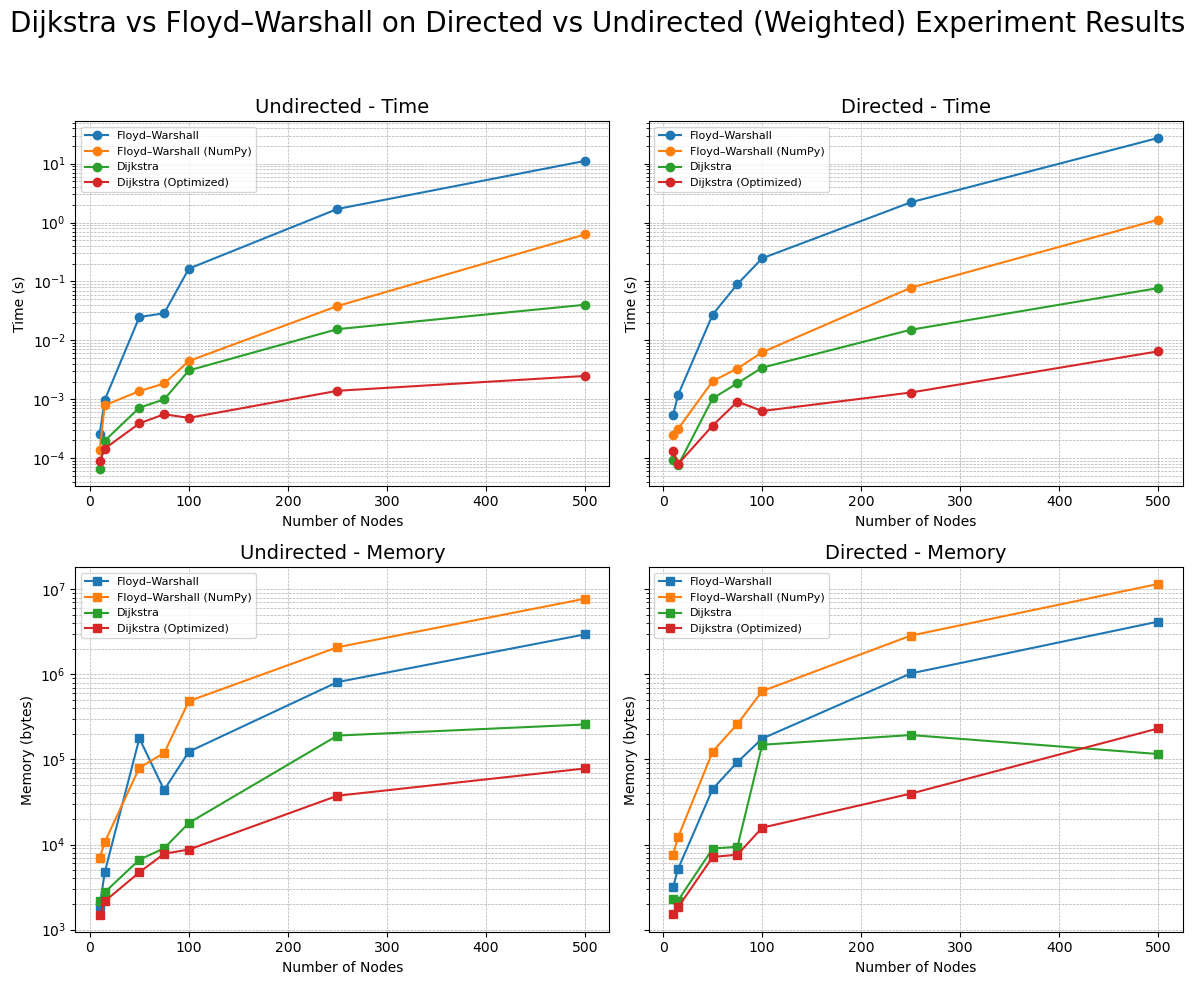

In [77]:
plot_experiment_results(
    df_directed_weighted,
    title_prefix="Dijkstra vs Floyd–Warshall on Directed vs Undirected (Weighted)"
)

## Acyclic vs Cyclic

In [78]:
def label_cyclic_graph_fd(acyclic):
    return "Acyclic (Weighted)" if acyclic else "Cyclic (Weighted)"

In [79]:
def create_cyclic_vs_acyclic_weighted_graph(size, seed, acyclic):
    if acyclic:
        G = generate_connected_dag(size, seed=seed)
        for u, v in G.edges():
            G[u][v]["weight"] = random.randint(1, 10)
    else:
        G = create_graph_realistic(
            num_nodes=size,
            seed=seed,
            sparse=True,
            directed=True,
            weighted=True,
            labeled=True,
            model="erdos_renyi"
        )
        if not nx.is_weakly_connected(G):
            largest_cc = max(nx.weakly_connected_components(G), key=len)
            G = G.subgraph(largest_cc).copy()
    return G

all_graphs_cyclic_weighted = generate_graph_variations(
    node_sizes=node_sizes,
    seeds=seeds,
    variations=[True, False],  
    graph_creator=create_cyclic_vs_acyclic_weighted_graph,
    visualizer=lambda G, size, acyclic, folder: visualize_graph_networkx(
        G,
        name=f"{'acyclic' if acyclic else 'cyclic'}_{size}_nodes_weighted",
        folder=folder,
        layout="kamada_kawai",
        directed=True
    ),
    label_function=label_cyclic_graph_fd,
    folder_base="graphs/dijkstra_floyd"
)


In [80]:
results_cyclic_weighted = run_experiment_for_graphs(all_graphs_cyclic_weighted, algo_wrappers_2)

df_cyclic_weighted = create_results_table(
    results_cyclic_weighted,
    all_graphs_cyclic_weighted,
    label_cyclic_graph_fd
)

Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 319.23it/s]


        10 |     0.000314 ± 0.000031 |           3,176 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 318.86it/s]


        10 |     0.000308 ± 0.000018 |           2,840 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 69.34it/s]


        15 |     0.001585 ± 0.000019 |           5,144 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 121.38it/s]


        15 |     0.001294 ± 0.000203 |           5,643 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


        50 |     0.050022 ± 0.022031 |          44,752 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]


        50 |     0.021100 ± 0.005320 |          45,032 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


        75 |     0.099614 ± 0.043568 |          96,656 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


        75 |     0.100894 ± 0.036130 |          93,112 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


       100 |     0.235725 ± 0.100445 |         175,960 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


       100 |     0.294770 ± 0.094568 |         175,960 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:17<00:00, 17.26s/it]


       250 |     2.669487 ± 0.279789 |       1,068,132 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:14<00:00, 14.77s/it]


       250 |     2.313186 ± 0.076820 |       1,171,240 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [04:14<00:00, 254.75s/it]


       500 |    21.588178 ± 0.526657 |       4,295,640 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [03:40<00:00, 220.96s/it]


       500 |    19.450249 ± 0.338602 |       4,173,504 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 321.50it/s]


        10 |     0.000197 ± 0.000103 |           7,612 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 319.15it/s]


        10 |     0.000178 ± 0.000053 |           7,612 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 318.52it/s]


        15 |     0.000251 ± 0.000068 |          12,136 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 215.52it/s]


        15 |     0.000261 ± 0.000047 |          12,136 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 67.44it/s]


        50 |     0.001458 ± 0.000559 |         123,848 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 48.33it/s]


        50 |     0.002076 ± 0.000740 |         123,848 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 20.46it/s]


        75 |     0.003695 ± 0.000689 |         275,880 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

        75 |     0.003114 ± 0.000937 |         261,304 | N/A

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 28.56it/s]



Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       100 |     0.005822 ± 0.000714 |         634,992 | N/A

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 14.52it/s]



Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 15.80it/s]

       100 |     0.005679 ± 0.000737 |         635,136 | N/A


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


       250 |     0.063989 ± 0.023694 |       3,018,304 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


       250 |     0.047208 ± 0.010985 |       2,852,160 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:08<00:00,  8.38s/it]


       500 |     1.345882 ± 0.189181 |      12,036,364 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:07<00:00,  7.84s/it]


       500 |     1.216894 ± 0.090429 |      11,562,528 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 297.28it/s]


        10 |     0.000095 ± 0.000028 |           2,424 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 660.94it/s]


        10 |     0.000161 ± 0.000046 |           2,264 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 332.78it/s]


        15 |     0.000170 ± 0.000066 |           3,144 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        15 |     0.000125 ± 0.000024 |           2,200 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 143.11it/s]


        50 |     0.000957 ± 0.000223 |           9,352 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 99.76it/s]


        50 |     0.001043 ± 0.000170 |           8,968 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 224.78it/s]


        75 |     0.000536 ± 0.000047 |           8,768 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 62.35it/s]


        75 |     0.002311 ± 0.000300 |           9,416 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 53.72it/s]


       100 |     0.002846 ± 0.000712 |          17,208 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 44.35it/s]

       100 |     0.002942 ± 0.000663 |          24,048 | N/A


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       250 |     0.008568 ± 0.002206 |          42,608 | N/A

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]

Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


       250 |     0.017791 ± 0.001474 |         192,312 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 37.32it/s]


       500 |     0.004050 ± 0.001222 |          89,208 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


       500 |     0.066043 ± 0.040981 |         115,712 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 3201.76it/s]


        10 |     0.000050 ± 0.000023 |           1,648 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 401.10it/s]


        10 |     0.000094 ± 0.000022 |           1,536 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 367.12it/s]


        15 |     0.000205 ± 0.000125 |           2,056 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 229.65it/s]


        15 |     0.000051 ± 0.000023 |           1,824 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 121.67it/s]


        50 |     0.000360 ± 0.000046 |           7,536 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 127.51it/s]


        50 |     0.000367 ± 0.000035 |           7,152 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 247.44it/s]


        75 |     0.000369 ± 0.000147 |           8,688 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 239.09it/s]


        75 |     0.000512 ± 0.000042 |           7,600 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 143.30it/s]


       100 |     0.000628 ± 0.000105 |          16,488 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 135.01it/s]


       100 |     0.000630 ± 0.000112 |          15,784 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 86.48it/s]


       250 |     0.001446 ± 0.000204 |          42,528 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 64.55it/s]


       250 |     0.001661 ± 0.000147 |          39,672 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       500 |     0.003492 ± 0.001464 |          89,128 | N/A

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 37.21it/s]



Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 41.92it/s]

       500 |     0.003213 ± 0.000645 |          83,768 | N/A

Algorithm Performance Table:
             Algorithm  Nodes         Graph Type  Time (s) Memory (bytes) Result
        Floyd–Warshall     10 Acyclic (Weighted)  0.000314          3,176    N/A
        Floyd–Warshall     10  Cyclic (Weighted)  0.000308          2,840    N/A
        Floyd–Warshall     15 Acyclic (Weighted)  0.001585          5,144    N/A
        Floyd–Warshall     15  Cyclic (Weighted)  0.001294          5,643    N/A
        Floyd–Warshall     50 Acyclic (Weighted)  0.050022         44,752    N/A
        Floyd–Warshall     50  Cyclic (Weighted)  0.021100         45,032    N/A
        Floyd–Warshall     75 Acyclic (Weighted)  0.099614         96,656    N/A
        Floyd–Warshall     75  Cyclic (Weighted)  0.100894         93,112    N/A
        Floyd–Warshall    100 Acyclic (Weighted)  0.235725        175,960    N/A
        Floyd–Warshall    100  Cyclic (Weighted)  0.294770        175,960    N/A
        Floyd–Wars

Plot saved to graphs/dijkstra_floyd/plots_analysis\dijkstra_vs_floyd–warshall_on_cyclic_vs_acyclic_(weighted)_experiment_results.png


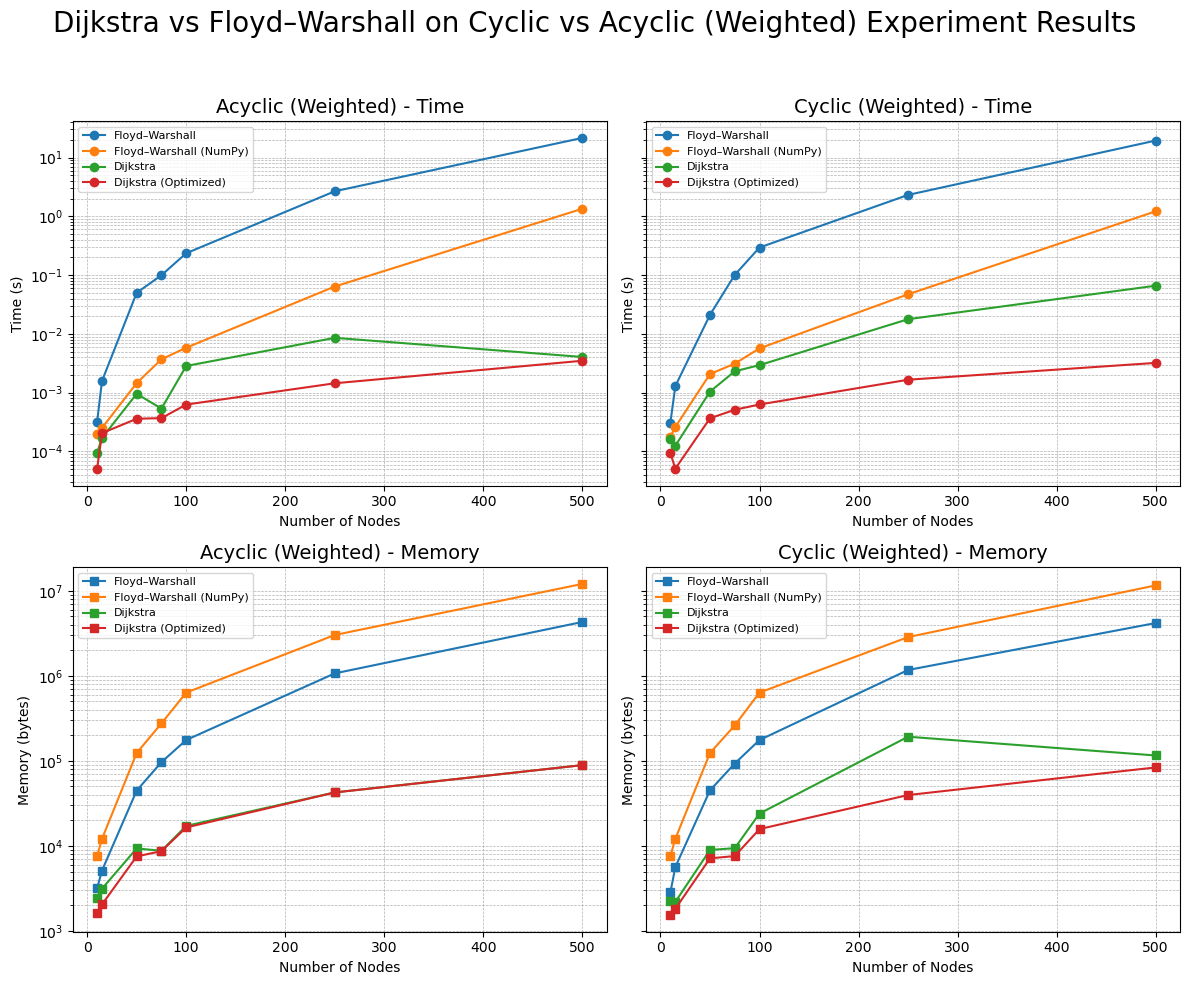

In [81]:
plot_experiment_results(
    df_cyclic_weighted,
    title_prefix="Dijkstra vs Floyd–Warshall on Cyclic vs Acyclic (Weighted)",
    save_folder="graphs/dijkstra_floyd/plots_analysis"
)

## Connected vs Disconnected

In [82]:
def label_connected_weighted_fd(connected):
    return "Connected (Weighted)" if connected else "Disconnected (Weighted)"

In [83]:
def create_connected_vs_disconnected_weighted_graph(size, seed, connected):
    if connected:
        G = create_graph_realistic(
            num_nodes=size,
            seed=seed,
            sparse=True,
            directed=False,
            weighted=True,
            labeled=True,
            model="erdos_renyi"
        )
        if not nx.is_connected(G):
            largest_cc = max(nx.connected_components(G), key=len)
            G = G.subgraph(largest_cc).copy()
    else:
        half = size // 2
        G1 = create_graph_realistic(
            num_nodes=half,
            seed=seed,
            sparse=True,
            directed=False,
            weighted=True,
            labeled=True,
            model="erdos_renyi"
        )
        G2 = create_graph_realistic(
            num_nodes=size - half,
            seed=seed + 1,
            sparse=True,
            directed=False,
            weighted=True,
            labeled=True,
            model="erdos_renyi"
        )
        G = nx.disjoint_union(G1, G2)
    return G

all_graphs_connected_weighted = generate_graph_variations(
    node_sizes=node_sizes,
    seeds=seeds,
    variations=[True, False],
    graph_creator=create_connected_vs_disconnected_weighted_graph,
    visualizer=lambda G, size, connected, folder: visualize_graph_networkx(
        G,
        name=f"{'connected' if connected else 'disconnected'}_{size}_nodes_weighted",
        folder=folder,
        layout="kamada_kawai",
        directed=False
    ),
    label_function=label_connected_weighted_fd,
    folder_base="graphs/dijkstra_floyd"
)

In [84]:
results_connected_weighted = run_experiment_for_graphs(all_graphs_connected_weighted, algo_wrappers_2)
df_connected_weighted = create_results_table(results_connected_weighted, all_graphs_connected_weighted, label_connected_weighted_fd)

Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 209.89it/s]


        10 |     0.000414 ± 0.000087 |           1,880 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 209.28it/s]


        10 |     0.000458 ± 0.000038 |           3,176 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 125.79it/s]


        15 |     0.000823 ± 0.000167 |           4,712 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 100.06it/s]


        15 |     0.001022 ± 0.000197 |           5,523 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 10.06it/s]


        50 |     0.013347 ± 0.001024 |         177,783 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


        50 |     0.041434 ± 0.014347 |         193,120 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

        75 |     0.023731 ± 0.002678 |          43,768 | N/A

Running experiments: 100%|██████████| 1/1 [00:00<00:00,  5.54it/s]



Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


        75 |     0.146649 ± 0.065117 |         245,392 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


       100 |     0.154152 ± 0.057000 |         123,472 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


       100 |     0.279390 ± 0.085929 |         175,960 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:09<00:00,  9.64s/it]


       250 |     1.615543 ± 0.437330 |         663,032 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:20<00:00, 20.37s/it]


       250 |     3.003994 ± 0.426229 |       1,214,688 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [01:32<00:00, 92.98s/it]


       500 |     9.059463 ± 1.238372 |       2,951,440 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [03:45<00:00, 225.85s/it]


       500 |    17.466191 ± 0.323103 |       4,295,496 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 300.26it/s]


        10 |     0.000234 ± 0.000120 |           6,984 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 496.25it/s]


        10 |     0.000258 ± 0.000056 |           7,612 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 228.83it/s]


        15 |     0.000222 ± 0.000064 |          11,391 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 165.38it/s]


        15 |     0.000574 ± 0.000234 |          12,136 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 31.37it/s]


        50 |     0.003309 ± 0.001491 |         227,621 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 29.61it/s]


        50 |     0.002804 ± 0.001102 |         123,848 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

        75 |     0.002029 ± 0.000066 |         119,032 | N/A

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 35.43it/s]



Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

        75 |     0.004707 ± 0.001165 |         423,088 | N/A

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 15.89it/s]



Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       100 |     0.005469 ± 0.000319 |         484,592 | N/A

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 13.46it/s]



Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       100 |     0.008964 ± 0.001502 |         487,504 | N/A


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


       250 |     0.030628 ± 0.004607 |       2,082,320 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


       250 |     0.068678 ± 0.007769 |       3,018,304 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:04<00:00,  4.85s/it]


       500 |     0.756251 ± 0.159747 |       7,747,692 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:08<00:00,  8.25s/it]


       500 |     1.321020 ± 0.240145 |      12,036,364 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 704.69it/s]


        10 |     0.000106 ± 0.000023 |           2,168 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 945.51it/s]


        10 |     0.000079 ± 0.000032 |           2,392 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        15 |     0.000118 ± 0.000021 |           2,744 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 496.54it/s]


        15 |     0.000094 ± 0.000047 |           3,048 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 248.40it/s]


        50 |     0.000520 ± 0.000083 |           6,648 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 265.83it/s]


        50 |     0.000261 ± 0.000059 |           7,848 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 103.00it/s]


        75 |     0.001360 ± 0.000349 |           9,032 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 90.70it/s]


        75 |     0.001292 ± 0.000347 |           9,544 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 60.63it/s]


       100 |     0.002075 ± 0.000260 |          17,960 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 55.81it/s]


       100 |     0.002425 ± 0.000660 |          16,672 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]

       250 |     0.012713 ± 0.002368 |          42,720 | N/A


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]

       250 |     0.008911 ± 0.001278 |          45,392 | N/A


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


       500 |     0.045092 ± 0.010607 |         109,832 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


       500 |     0.059910 ± 0.050343 |          85,680 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 457.14it/s]


        10 |     0.000077 ± 0.000019 |           1,480 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 950.87it/s]


        10 |     0.000047 ± 0.000025 |           1,704 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 399.23it/s]


        15 |     0.000153 ± 0.000036 |           2,152 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 563.45it/s]


        15 |     0.000089 ± 0.000029 |           2,504 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 279.12it/s]


        50 |     0.000276 ± 0.000097 |           4,720 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 165.15it/s]


        50 |     0.000265 ± 0.000061 |           7,768 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 164.77it/s]


        75 |     0.000501 ± 0.000084 |           7,800 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 568.64it/s]


        75 |     0.000374 ± 0.000039 |           7,728 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 165.25it/s]


       100 |     0.000436 ± 0.000121 |           8,736 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 254.18it/s]


       100 |     0.000570 ± 0.000180 |          16,400 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 53.93it/s]


       250 |     0.001987 ± 0.001308 |          37,464 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 81.14it/s]


       250 |     0.001637 ± 0.000711 |          39,552 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 44.44it/s]

       500 |     0.002673 ± 0.000843 |          78,376 | N/A


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       500 |     0.004149 ± 0.003133 |          84,456 | N/A

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 34.22it/s]




Algorithm Performance Table:
             Algorithm  Nodes              Graph Type  Time (s) Memory (bytes) Result
        Floyd–Warshall     10    Connected (Weighted)  0.000414          1,880    N/A
        Floyd–Warshall     10 Disconnected (Weighted)  0.000458          3,176    N/A
        Floyd–Warshall     15    Connected (Weighted)  0.000823          4,712    N/A
        Floyd–Warshall     15 Disconnected (Weighted)  0.001022          5,523    N/A
        Floyd–Warshall     50    Connected (Weighted)  0.013347        177,783    N/A
        Floyd–Warshall     50 Disconnected (Weighted)  0.041434        193,120    N/A
        Floyd–Warshall     75    Connected (Weighted)  0.023731         43,768    N/A
        Floyd–Warshall     75 Disconnected (Weighted)  0.146649        245,392    N/A
        Floyd–Warshall    100    Connected (Weighted)  0.154152        123,472    N/A
        Floyd–Warshall    100 Disconnected (Weighted)  0.279390        175,960    N/A
        Floyd–Warshall 

Plot saved to graphs/dijkstra_floyd/plots_analysis\dijkstra_vs_floyd–warshall_on_connected_vs_disconnected_(weighted)_experiment_results.png


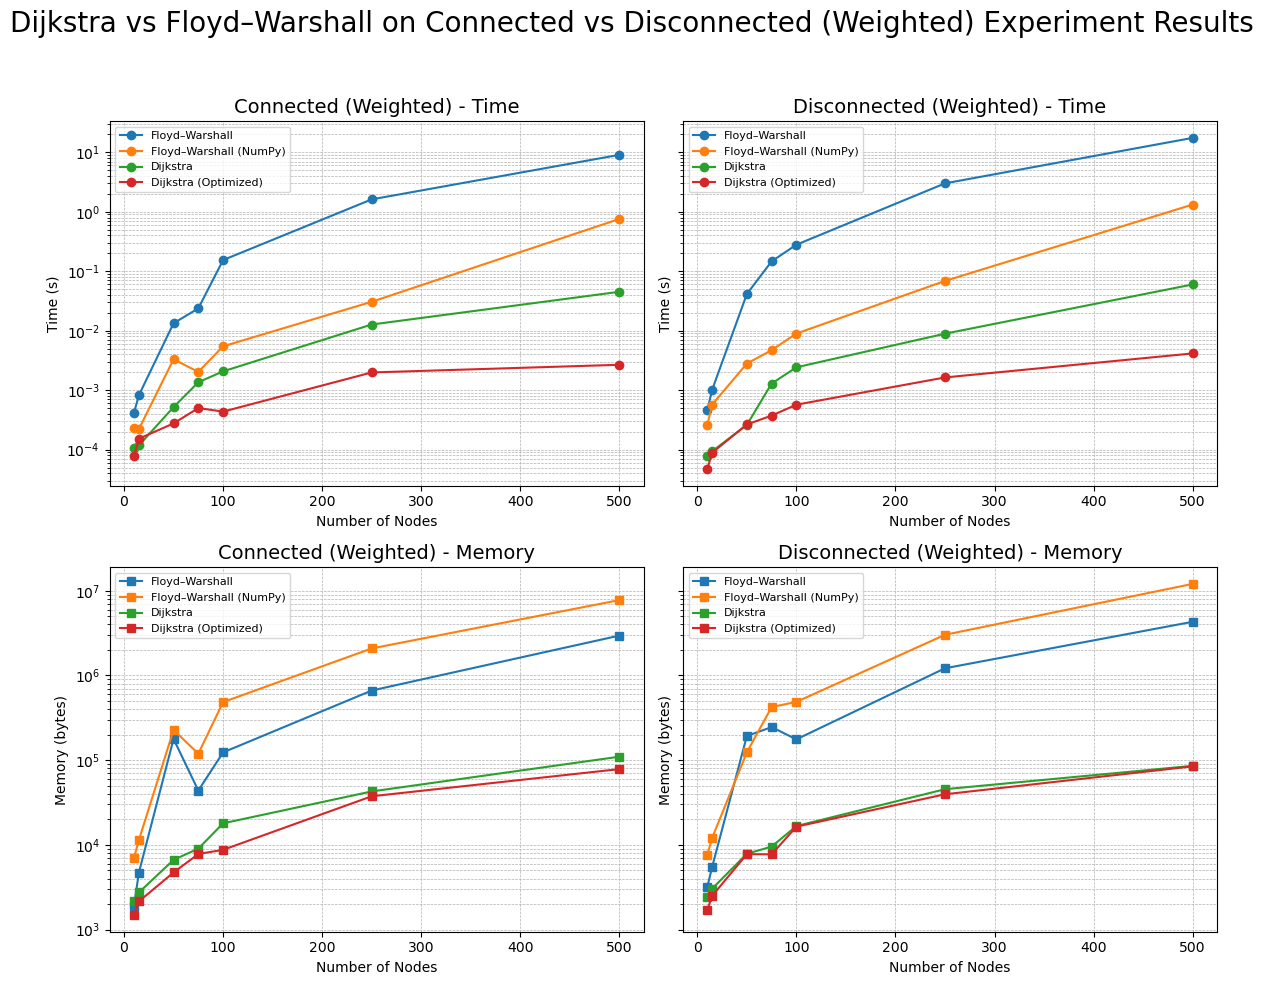

In [85]:
plot_experiment_results(
    df_connected_weighted,
    title_prefix="Dijkstra vs Floyd–Warshall on Connected vs Disconnected (Weighted)",
    save_folder="graphs/dijkstra_floyd/plots_analysis"
)

## Self-Loop vs No Self-Loop

In [86]:
def label_loops_weighted(has_loops):
    return "With Loops (Weighted)" if has_loops else "No Loops (Weighted)"

In [87]:
def create_loops_vs_no_loops_weighted(size, seed, has_loops, loop_prob=0.3):
    G = create_graph_realistic(
        num_nodes=size,
        seed=seed,
        sparse=True,
        directed=True,
        weighted=True,
        labeled=True,
        model="erdos_renyi"
    )

    if not nx.is_weakly_connected(G):
        largest_cc = max(nx.weakly_connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()

    if has_loops:
        for node in G.nodes():
            if random.random() < loop_prob:
                G.add_edge(node, node, weight=random.randint(1, 10))

    return G

all_graphs_loops_weighted = generate_graph_variations(
    node_sizes=node_sizes,
    seeds=seeds,
    variations=[False, True],
    graph_creator=create_loops_vs_no_loops_weighted,
    visualizer=lambda G, size, has_loops, folder: visualize_graph_networkx(
        G,
        name=f"{'with_loops' if has_loops else 'no_loops'}_{size}_nodes_weighted",
        folder=folder,
        layout="kamada_kawai",
        directed=True
    ),
    label_function=label_loops_weighted,
    folder_base="graphs/dijkstra_floyd"
)

In [88]:
results_loops_weighted = run_experiment_for_graphs(all_graphs_loops_weighted, algo_wrappers_2)
df_loops_weighted = create_results_table(results_loops_weighted, all_graphs_loops_weighted, label_loops_weighted)

Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 299.83it/s]


        10 |     0.000279 ± 0.000030 |           3,176 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 317.01it/s]


        10 |     0.000277 ± 0.000016 |           2,840 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 155.97it/s]


        15 |     0.000917 ± 0.000172 |           5,144 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 214.19it/s]


        15 |     0.000663 ± 0.000050 |           5,144 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


        50 |     0.032663 ± 0.013215 |         193,136 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


        50 |     0.022472 ± 0.002611 |         193,931 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


        75 |     0.077770 ± 0.036720 |          93,112 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


        75 |     0.056915 ± 0.004604 |          93,112 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


       100 |     0.160697 ± 0.036103 |         175,960 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


       100 |     0.153825 ± 0.027112 |         175,960 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:14<00:00, 14.51s/it]


       250 |     2.293970 ± 0.066448 |       1,024,684 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:14<00:00, 14.66s/it]


       250 |     2.346961 ± 0.112499 |       1,022,672 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [04:19<00:00, 259.88s/it]


       500 |    20.755557 ± 2.274991 |       4,173,640 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [03:56<00:00, 236.93s/it]


       500 |    15.577507 ± 0.260702 |       4,173,696 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 786.78it/s]


        10 |     0.000209 ± 0.000048 |           7,612 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        10 |     0.000159 ± 0.000060 |           7,612 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 247.90it/s]


        15 |     0.000295 ± 0.000054 |          12,136 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 248.20it/s]


        15 |     0.000302 ± 0.000079 |          12,136 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 44.38it/s]


        50 |     0.001987 ± 0.000982 |         123,848 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 60.44it/s]


        50 |     0.001311 ± 0.000254 |         123,848 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 19.00it/s]


        75 |     0.004366 ± 0.000633 |         261,304 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

        75 |     0.003425 ± 0.000636 |         261,304 | N/A

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 22.12it/s]

Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       100 |     0.006760 ± 0.000894 |         635,112 | N/A

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]



Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       100 |     0.007153 ± 0.001104 |         635,616 | N/A

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]

Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


       250 |     0.061956 ± 0.014340 |       2,852,160 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


       250 |     0.051631 ± 0.013327 |       2,852,160 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:06<00:00,  6.66s/it]


       500 |     1.006608 ± 0.086569 |      11,560,444 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:06<00:00,  6.53s/it]


       500 |     0.985830 ± 0.108288 |      11,560,444 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        10 |     0.000078 ± 0.000021 |           2,264 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 395.65it/s]


        10 |     0.000102 ± 0.000046 |           2,264 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        15 |     0.000059 ± 0.000027 |           2,200 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 496.84it/s]


        15 |     0.000104 ± 0.000017 |           2,264 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 106.54it/s]


        50 |     0.000786 ± 0.000119 |           8,968 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 95.60it/s]


        50 |     0.001152 ± 0.000167 |           9,703 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 74.16it/s]


        75 |     0.001664 ± 0.000112 |           9,416 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 53.94it/s]


        75 |     0.002559 ± 0.000163 |           9,512 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 54.48it/s]


       100 |     0.002564 ± 0.000342 |          24,048 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 37.80it/s]


       100 |     0.003474 ± 0.000457 |         172,319 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       250 |     0.015341 ± 0.003118 |          45,512 | N/A

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 10.43it/s]

Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


       250 |     0.016414 ± 0.003036 |          46,120 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


       500 |     0.052310 ± 0.023501 |         115,712 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


       500 |     0.045114 ± 0.008044 |         116,672 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 901.03it/s]


        10 |     0.000059 ± 0.000018 |           1,536 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 1772.74it/s]


        10 |     0.000058 ± 0.000032 |           1,536 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 861.61it/s]


        15 |     0.000055 ± 0.000019 |           1,824 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 302.82it/s]


        15 |     0.000057 ± 0.000032 |           1,888 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        50 |     0.000186 ± 0.000072 |           7,152 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 192.65it/s]


        50 |     0.000165 ± 0.000037 |           7,184 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 280.82it/s]


        75 |     0.000362 ± 0.000055 |           7,600 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 151.30it/s]


        75 |     0.000264 ± 0.000044 |           7,696 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 137.70it/s]


       100 |     0.000607 ± 0.000052 |          15,784 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 129.47it/s]


       100 |     0.000443 ± 0.000192 |          15,976 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 63.24it/s]


       250 |     0.001671 ± 0.000240 |          39,672 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 57.38it/s]


       250 |     0.001288 ± 0.000355 |          40,280 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 40.69it/s]


       500 |     0.003767 ± 0.003352 |          83,768 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       500 |     0.004258 ± 0.001040 |          84,728 | N/A


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 37.84it/s]


Algorithm Performance Table:
             Algorithm  Nodes            Graph Type  Time (s) Memory (bytes) Result
        Floyd–Warshall     10   No Loops (Weighted)  0.000279          3,176    N/A
        Floyd–Warshall     10 With Loops (Weighted)  0.000277          2,840    N/A
        Floyd–Warshall     15   No Loops (Weighted)  0.000917          5,144    N/A
        Floyd–Warshall     15 With Loops (Weighted)  0.000663          5,144    N/A
        Floyd–Warshall     50   No Loops (Weighted)  0.032663        193,136    N/A
        Floyd–Warshall     50 With Loops (Weighted)  0.022472        193,931    N/A
        Floyd–Warshall     75   No Loops (Weighted)  0.077770         93,112    N/A
        Floyd–Warshall     75 With Loops (Weighted)  0.056915         93,112    N/A
        Floyd–Warshall    100   No Loops (Weighted)  0.160697        175,960    N/A
        Floyd–Warshall    100 With Loops (Weighted)  0.153825        175,960    N/A
        Floyd–Warshall    250   No Loops (Weig

Plot saved to graphs/dijkstra_floyd/plots_analysis\dijkstra_vs_floyd–warshall_on_loops_vs_no_loops_(weighted)_experiment_results.png


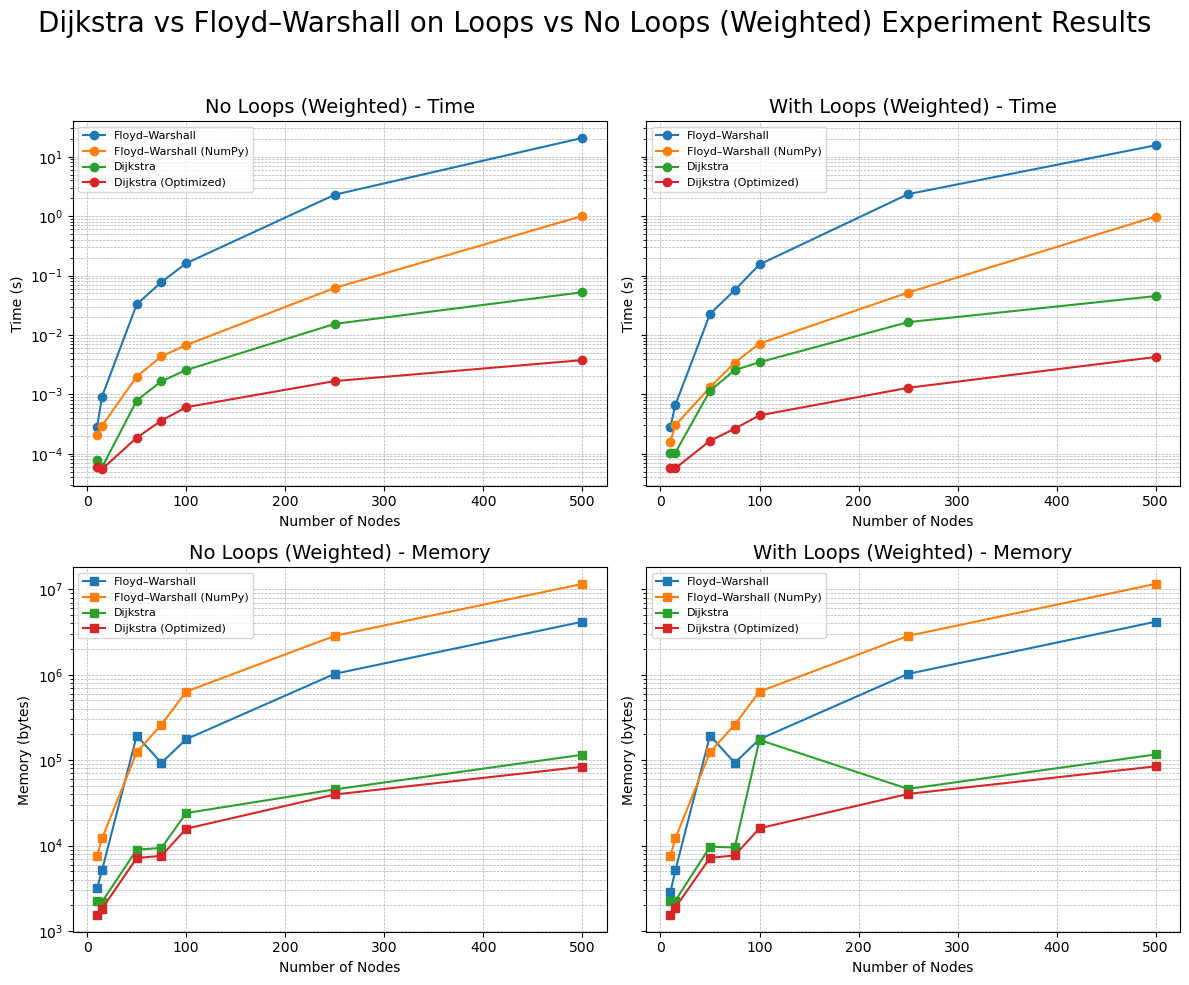

In [89]:
plot_experiment_results(
    df_loops_weighted,
    title_prefix="Dijkstra vs Floyd–Warshall on Loops vs No Loops (Weighted)",
    save_folder="graphs/dijkstra_floyd/plots_analysis"
)

## Tree(Weighted)

In [90]:
def label_tree_weighted(_):
    return "Tree (Weighted)"

In [91]:
def create_tree_weighted(size, seed, _):
    G = nx.random_tree(n=size, seed=seed)
    for u, v in G.edges():
        G[u][v]["weight"] = random.randint(1, 10)
    return G

all_graphs_tree_weighted = generate_graph_variations(
    node_sizes=node_sizes,
    seeds=seeds,
    variations=["tree"],
    graph_creator=create_tree_weighted,
    visualizer=lambda G, size, _, folder: visualize_graph_networkx(
        G,
        name=f"tree_weighted_{size}_nodes",
        folder="graphs/dijkstra_floyd/tree",
        layout="kamada_kawai",
        directed=False
    ),
    label_function=label_tree_weighted,
    folder_base="graphs/dijkstra_floyd/tree"
)

In [92]:
results_tree_weighted = run_experiment_for_graphs(all_graphs_tree_weighted, algo_wrappers_2)
df_tree_weighted = create_results_table(results_tree_weighted, all_graphs_tree_weighted, label_tree_weighted)

Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 212.71it/s]


        10 |     0.000266 ± 0.000019 |           3,200 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 161.45it/s]


        15 |     0.000925 ± 0.000309 |           5,144 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]


        50 |     0.018846 ± 0.002474 |          45,032 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


        75 |     0.072598 ± 0.019789 |          96,824 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


       100 |     0.163386 ± 0.055192 |         175,960 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:13<00:00, 13.58s/it]


       250 |     1.941011 ± 0.208735 |       1,147,752 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [03:36<00:00, 216.35s/it]


       500 |    18.926381 ± 3.212692 |       4,426,476 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 673.68it/s]


        10 |     0.000211 ± 0.000048 |           7,612 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 266.34it/s]


        15 |     0.000186 ± 0.000053 |          12,136 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 47.42it/s]


        50 |     0.001793 ± 0.000969 |         123,848 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 19.94it/s]


        75 |     0.004162 ± 0.000596 |         275,656 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       100 |     0.008939 ± 0.002535 |         487,504 | N/A

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]



Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


       250 |     0.060006 ± 0.010508 |       3,018,304 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:12<00:00, 12.20s/it]


       500 |     1.853629 ± 0.410080 |      12,036,548 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 338.50it/s]


        10 |     0.000113 ± 0.000034 |           2,392 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 568.18it/s]


        15 |     0.000151 ± 0.000065 |           3,144 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 169.02it/s]


        50 |     0.000756 ± 0.000102 |           9,032 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 64.13it/s]


        75 |     0.001784 ± 0.000596 |           9,848 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 16.38it/s]


       100 |     0.005252 ± 0.001110 |          24,176 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


       250 |     0.027654 ± 0.005361 |          46,768 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


       500 |     0.075584 ± 0.009248 |         118,032 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        10 |     0.000094 ± 0.000042 |           1,752 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        15 |     0.000161 ± 0.000037 |           2,632 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 149.80it/s]


        50 |     0.000408 ± 0.000107 |           7,800 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 186.88it/s]


        75 |     0.000624 ± 0.000059 |           8,408 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 82.22it/s]


       100 |     0.001398 ± 0.000372 |          16,464 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 53.46it/s]


       250 |     0.001910 ± 0.000142 |          40,928 | N/A
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 29.10it/s]


       500 |     0.003432 ± 0.001670 |         208,344 | N/A

Algorithm Performance Table:
             Algorithm  Nodes      Graph Type  Time (s) Memory (bytes) Result
        Floyd–Warshall     10 Tree (Weighted)  0.000266          3,200    N/A
        Floyd–Warshall     15 Tree (Weighted)  0.000925          5,144    N/A
        Floyd–Warshall     50 Tree (Weighted)  0.018846         45,032    N/A
        Floyd–Warshall     75 Tree (Weighted)  0.072598         96,824    N/A
        Floyd–Warshall    100 Tree (Weighted)  0.163386        175,960    N/A
        Floyd–Warshall    250 Tree (Weighted)  1.941011      1,147,752    N/A
        Floyd–Warshall    500 Tree (Weighted) 18.926381      4,426,476    N/A
Floyd–Warshall (NumPy)     10 Tree (Weighted)  0.000211          7,612    N/A
Floyd–Warshall (NumPy)     15 Tree (Weighted)  0.000186         12,136    N/A
Floyd–Warshall (NumPy)     50 Tree (Weighted)  0.001793        123,848    N/A
Floyd–Warshall (NumPy)     75 Tree (Weighted)  0.00

Plot saved to graphs/dijkstra_floyd/plots_analysis\dijkstra_vs_floyd–warshall_on_tree_(weighted)_experiment_results.png


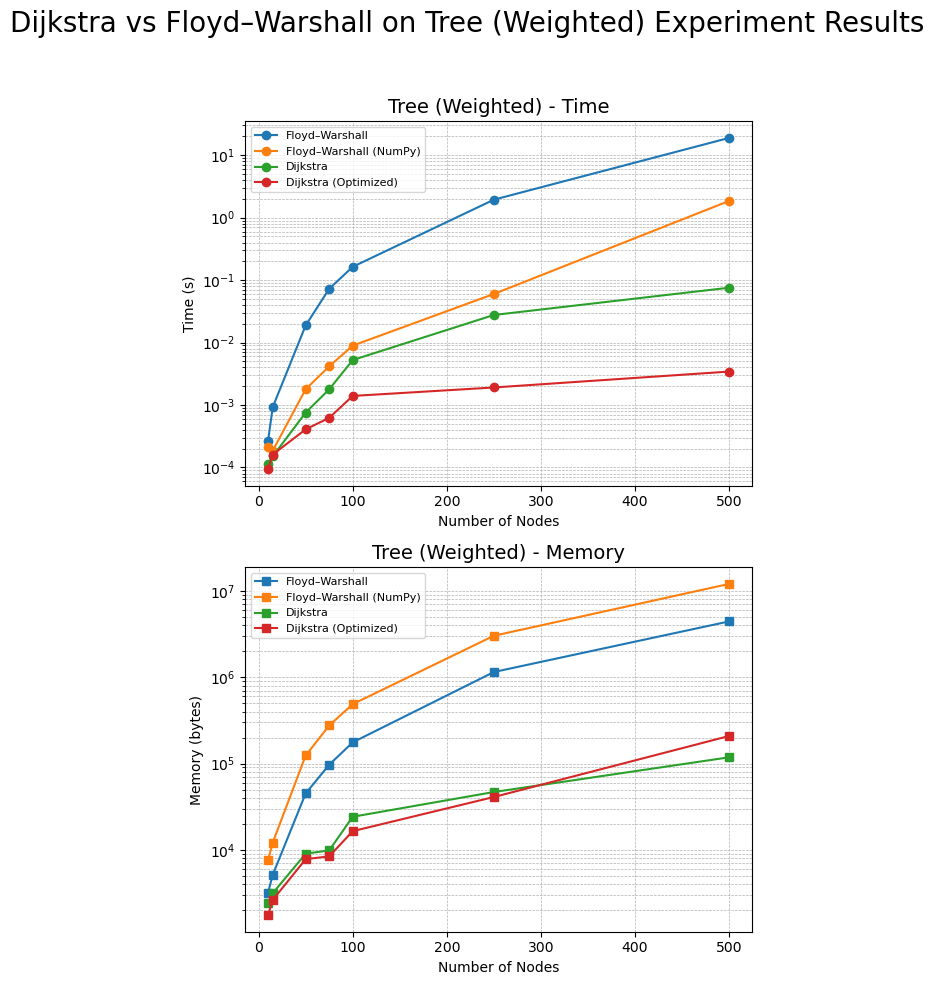

In [93]:
plot_experiment_results(
    df_tree_weighted,
    title_prefix="Dijkstra vs Floyd–Warshall on Tree (Weighted)",
    save_folder="graphs/dijkstra_floyd/plots_analysis"
)

# PART III: Prim and Kruskal

In [94]:
def lazy_prim_mst(graph):
    n = len(graph.nodes)
    visited = [False] * n
    mst_edges = []
    priority_queue = []
    total_weight = 0

    def visit(u):
        visited[u] = True
        for v, data in graph[u].items():
            if not visited[v]:
                heapq.heappush(priority_queue, (data.get('weight', 1), u, v))

    visit(0)

    while priority_queue and len(mst_edges) < n - 1:
        weight, u, v = heapq.heappop(priority_queue)
        if visited[u] and visited[v]:
            continue
        mst_edges.append((u, v, weight))
        total_weight += weight
        if not visited[u]:
            visit(u)
        if not visited[v]:
            visit(v)

    return total_weight

In [95]:
def eager_prim_mst(graph):
    n = len(graph.nodes)
    visited = [False] * n
    min_edge = [(float('inf'), None)] * n
    min_edge[0] = (0, None)
    priority_queue = [(0, 0)]
    mst_edges = []
    total_weight = 0

    while priority_queue:
        weight, u = heapq.heappop(priority_queue)
        if visited[u]:
            continue
        visited[u] = True
        if min_edge[u][1] is not None:
            mst_edges.append((min_edge[u][1], u, weight))
            total_weight += weight
        for v, data in graph[u].items():
            edge_weight = data.get('weight', 1)
            if not visited[v] and edge_weight < min_edge[v][0]:
                min_edge[v] = (edge_weight, u)
                heapq.heappush(priority_queue, (edge_weight, v))

    return total_weight


In [96]:
def kruskal_mst(graph):
    parent = {}
    def find(u):
        while parent[u] != u:
            parent[u] = parent[parent[u]]
            u = parent[u]
        return u

    def union(u, v):
        pu, pv = find(u), find(v)
        if pu == pv:
            return False
        parent[pu] = pv
        return True

    for node in graph.nodes:
        parent[node] = node

    edges = sorted(graph.edges(data=True), key=lambda x: x[2].get('weight', 1))
    mst_weight = 0
    for u, v, data in edges:
        if union(u, v):
            mst_weight += data.get('weight', 1)

    return mst_weight

In [97]:
class DisjointSet:
    def __init__(self):
        self.parent = {}
        self.rank = {}

    def make_set(self, x):
        self.parent[x] = x
        self.rank[x] = 0

    def find(self, x):
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])  # Path compression
        return self.parent[x]

    def union(self, x, y):
        xroot = self.find(x)
        yroot = self.find(y)
        if xroot == yroot:
            return False
        if self.rank[xroot] < self.rank[yroot]:
            self.parent[xroot] = yroot
        else:
            self.parent[yroot] = xroot
            if self.rank[xroot] == self.rank[yroot]:
                self.rank[xroot] += 1
        return True

def kruskal_mst_optimized(graph):
    ds = DisjointSet()
    for node in graph.nodes:
        ds.make_set(node)

    edges = sorted(graph.edges(data=True), key=lambda x: x[2].get('weight', 1))
    mst_weight = 0
    for u, v, data in edges:
        if ds.union(u, v):
            mst_weight += data.get('weight', 1)
    return mst_weight

In [98]:
algo_wrappers_3 = [
    ("Lazy Prim's MST", lambda G: lazy_prim_mst(G)),
    ("Eager Prim's MST", lambda G: eager_prim_mst(G)),
    ("Kruskal's MST", lambda G: kruskal_mst(G)),
    ("Kruskal's MST (Optimized)", lambda G: kruskal_mst_optimized(G)),
]

## Sparse vs Dense (Weighted)

In [102]:
def create_graph_for_mst(size, seed, sparse):
    G = create_sparse_vs_dense_weighted_graph(size, seed, sparse)
    return nx.convert_node_labels_to_integers(G, ordering='sorted')

all_graphs_sparse_dense_weighted_mst = generate_graph_variations(
    node_sizes=node_sizes,
    seeds=seeds,
    variations=[True, False],
    graph_creator=create_graph_for_mst,  # wrapped function
    visualizer=lambda G, size, sparse, folder: visualize_graph_networkx(
        G,
        name=f"mst_{'sparse' if sparse else 'dense'}_{size}_nodes",
        folder=folder,
        layout="kamada_kawai",
        directed=False
    ),
    label_function=label_sparse_weighted,
    folder_base="graphs/mst"
)


In [103]:
print("\nRunning MST algorithms on Sparse vs Dense (Weighted) graphs...\n")
combined_results_mst_1 = run_experiment_for_graphs(all_graphs_sparse_dense_weighted_mst, algo_wrappers_3)

print("\nGenerating MST performance table...\n")
df_results_mst_1 = create_results_table(combined_results_mst_1, all_graphs_sparse_dense_weighted_mst, label_sparse_weighted)


Running MST algorithms on Sparse vs Dense (Weighted) graphs...

Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 329.33it/s]


        10 |     0.000182 ± 0.000034 |             832 | 32
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 161.49it/s]


        10 |     0.000294 ± 0.000053 |           1,040 | 28
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 245.71it/s]


        15 |     0.000302 ± 0.000041 |           1,008 | 65
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 178.75it/s]


        15 |     0.000432 ± 0.000055 |           1,144 | 39
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 153.92it/s]


        50 |     0.000724 ± 0.000132 |           1,472 | 167
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 112.99it/s]


        50 |     0.001364 ± 0.001159 |           2,192 | 122
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 247.88it/s]


        75 |     0.000352 ± 0.000043 |           1,512 | 232
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 143.48it/s]


        75 |     0.000906 ± 0.000059 |           2,704 | 204
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 90.34it/s]


       100 |     0.000622 ± 0.000032 |           2,168 | 437
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 104.42it/s]

       100 |     0.001346 ± 0.000078 |           3,712 | 279


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 75.44it/s]

       250 |     0.001400 ± 0.000323 |           5,183 | 989


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 46.45it/s]

       250 |     0.003024 ± 0.000404 |           7,992 | 731


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 34.77it/s]


       500 |     0.002933 ± 0.000881 |           8,515 | 2086
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 16.28it/s]

       500 |     0.008301 ± 0.001112 |          15,732 | 1499


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 742.35it/s]


        10 |     0.000061 ± 0.000017 |             616 | 32
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 382.34it/s]


        10 |     0.000114 ± 0.000046 |             776 | 28
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

        15 |     0.000094 ± 0.000033 |             776 | 65


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 496.37it/s]


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 247.74it/s]


        15 |     0.000241 ± 0.000062 |             856 | 39
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 294.11it/s]


        50 |     0.000210 ± 0.000068 |           1,448 | 167
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 329.15it/s]


        50 |     0.000353 ± 0.000040 |           2,088 | 122
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 496.90it/s]


        75 |     0.000228 ± 0.000033 |           1,624 | 232
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 159.92it/s]


        75 |     0.000587 ± 0.000204 |           2,760 | 204
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 90.81it/s]


       100 |     0.000574 ± 0.000109 |           2,520 | 437
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 247.13it/s]


       100 |     0.000778 ± 0.000130 |           3,720 | 279
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 102.11it/s]


       250 |     0.000980 ± 0.000071 |           5,704 | 989
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 54.00it/s]


       250 |     0.002722 ± 0.000924 |           8,344 | 731
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       500 |     0.008587 ± 0.010097 |          10,548 | 2086

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 17.02it/s]

Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       500 |     0.008496 ± 0.000984 |          16,724 | 1499

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 15.92it/s]

Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 496.66it/s]

        10 |     0.000078 ± 0.000025 |           2,568 | 32


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 312.73it/s]


        10 |     0.000201 ± 0.000092 |           2,568 | 28
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 495.72it/s]


        15 |     0.000116 ± 0.000032 |           3,256 | 65
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 515.59it/s]

        15 |     0.000209 ± 0.000030 |           3,256 | 39


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 103.55it/s]


        50 |     0.000312 ± 0.000223 |           4,608 | 167
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 87.13it/s]


        50 |     0.001928 ± 0.002773 |           7,808 | 122
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 291.66it/s]


        75 |     0.000234 ± 0.000069 |           7,336 | 232
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 395.20it/s]


        75 |     0.000566 ± 0.000067 |           8,032 | 204
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 225.16it/s]


       100 |     0.000427 ± 0.000104 |           7,456 | 437
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 98.58it/s]


       100 |     0.001458 ± 0.000182 |          14,760 | 279
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 104.32it/s]


       250 |     0.001200 ± 0.000584 |          26,256 | 989
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 60.45it/s]


       250 |     0.002225 ± 0.000655 |          29,104 | 731
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 39.37it/s]


       500 |     0.003049 ± 0.000544 |         199,437 | 2086
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 27.21it/s]

       500 |     0.004441 ± 0.000289 |          57,480 | 1499


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 495.49it/s]


        10 |     0.000093 ± 0.000026 |           2,536 | 32
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 496.19it/s]

        10 |     0.000118 ± 0.000032 |           2,536 | 28


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 165.54it/s]


        15 |     0.000149 ± 0.000023 |           3,504 | 65
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        15 |     0.000151 ± 0.000028 |           3,504 | 39
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

        50 |     0.000380 ± 0.000063 |           5,392 | 167

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 150.81it/s]



Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 179.26it/s]


        50 |     0.000698 ± 0.000202 |           9,688 | 122
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 276.38it/s]


        75 |     0.000368 ± 0.000030 |           9,216 | 232
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 403.88it/s]

        75 |     0.000591 ± 0.000045 |           9,912 | 204
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------



Running experiments: 100%|██████████| 1/1 [00:00<00:00, 206.50it/s]


       100 |     0.000411 ± 0.000083 |           9,336 | 437
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 165.53it/s]


       100 |     0.001089 ± 0.000319 |          19,064 | 279
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 81.36it/s]

       250 |     0.001118 ± 0.000230 |          35,176 | 989


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 38.96it/s]


       250 |     0.003233 ± 0.000882 |          38,024 | 731
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       500 |     0.003525 ± 0.000719 |          69,304 | 2086

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 37.57it/s]

Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 25.65it/s]

       500 |     0.005740 ± 0.000881 |         216,091 | 1499

Generating MST performance table...


Algorithm Performance Table:
                Algorithm  Nodes        Graph Type Time (s) Memory (bytes)  Result
          Lazy Prim's MST     10 Sparse (Weighted) 0.000182            832      32
          Lazy Prim's MST     10  Dense (Weighted) 0.000294          1,040      28
          Lazy Prim's MST     15 Sparse (Weighted) 0.000302          1,008      65
          Lazy Prim's MST     15  Dense (Weighted) 0.000432          1,144      39
          Lazy Prim's MST     50 Sparse (Weighted) 0.000724          1,472     167
          Lazy Prim's MST     50  Dense (Weighted) 0.001364          2,192     122
          Lazy Prim's MST     75 Sparse (Weighted) 0.000352          1,512     232
          Lazy Prim's MST     75  Dense (Weighted) 0.000906          2,704     204
          Lazy Prim's MST    100 Sparse (Weighted) 0.000622          2,168     437
          Lazy Prim's MST    100  Dense 

Plot saved to graphs/mst/plots_analysis\mst_algorithms_(prim_vs_kruskal)_experiment_results.png


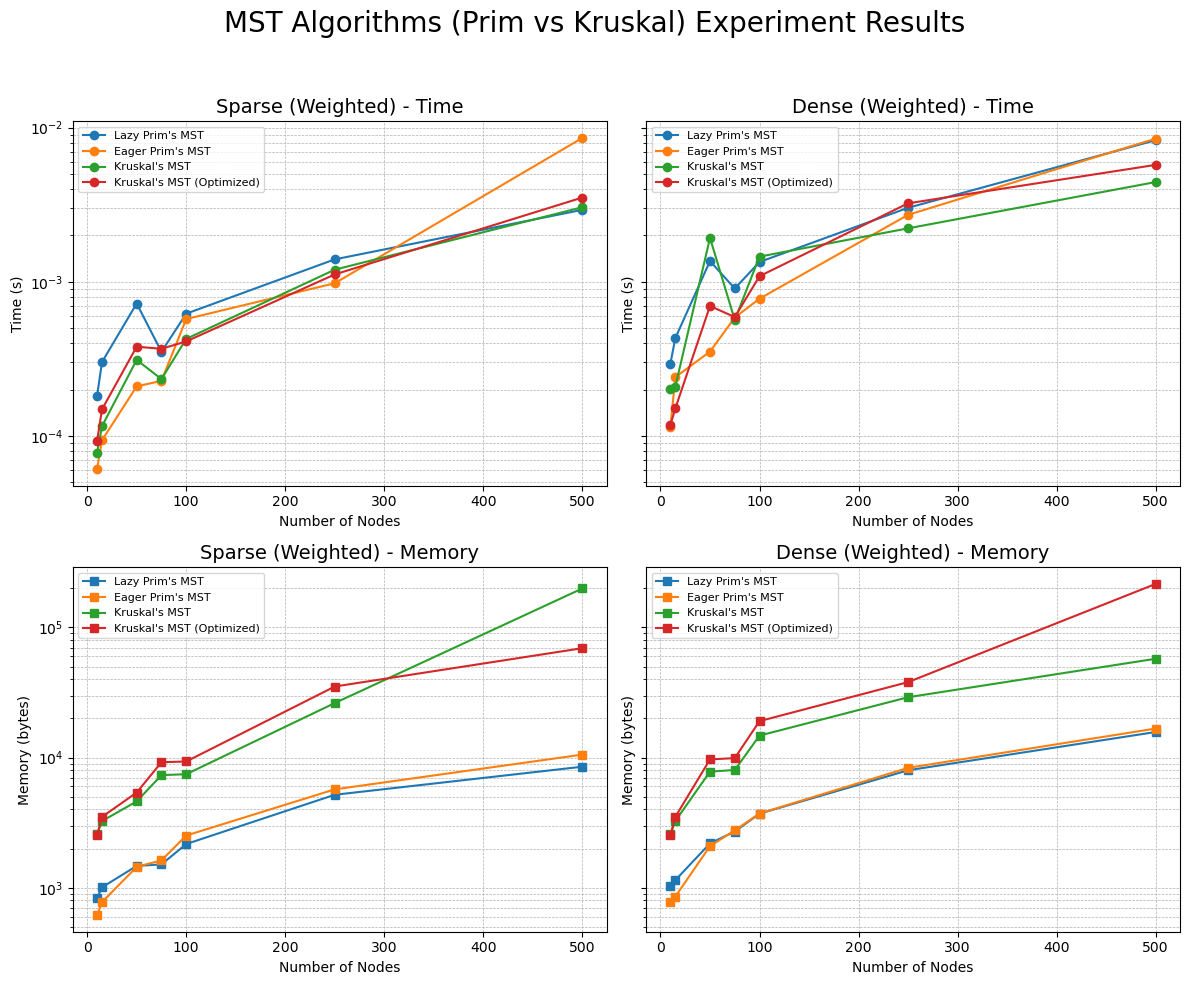

In [104]:
plot_experiment_results(
    df_results_mst_1,
    title_prefix="MST Algorithms (Prim vs Kruskal)",
    save_folder="graphs/mst/plots_analysis"
)

## Connected vs Disconnected

In [116]:
def label_connected_only_msf(variant):
    return "Connected Weighted"

In [119]:
def create_connected_weighted_graph(num_nodes, seed=None, _unused_variation=None):
    if seed is not None:
        random.seed(seed)

    G = nx.generators.random_tree(n=num_nodes, seed=seed)

    weighted_G = nx.Graph()
    for u, v in G.edges():
        weight = random.randint(1, 10)
        weighted_G.add_edge(u, v, weight=weight)

    possible_edges = [
        (u, v) for u in range(num_nodes) for v in range(u + 1, num_nodes)
        if not weighted_G.has_edge(u, v)
    ]
    random.shuffle(possible_edges)
    for i in range(min(num_nodes // 2, len(possible_edges))): 
        u, v = possible_edges[i]
        weight = random.randint(1, 10)
        weighted_G.add_edge(u, v, weight=weight)

    return weighted_G

all_graphs_conn = generate_graph_variations(
    node_sizes=node_sizes,
    seeds=seeds,
    variations=[True],  # Can keep this just to reuse the structure
    graph_creator=create_connected_weighted_graph,
    visualizer=lambda G, size, var, folder: visualize_graph_networkx(
        G,
        name=f"connected_{size}_nodes_weighted",
        folder=folder,
        layout="kamada_kawai",
        directed=False
    ),
    label_function=lambda _: "connected_weighted",
    folder_base="graphs/mst/only_connected"
)

In [120]:
print("\nRunning MST algorithms on Connected (Weighted) graphs...\n")
results_conn = run_experiment_for_graphs(all_graphs_msf, algo_wrappers_3)

print("\nGenerating MST performance table...\n")
df_conn = create_results_table(
    results_conn,
    all_graphs_conn,
    label_connected_only_msf
)


Running MST algorithms on Connected (Weighted) graphs...

Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 630.34it/s]


        10 |     0.000088 ± 0.000030 |             912 | 43
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 958.70it/s]


        15 |     0.000131 ± 0.000041 |           1,016 | 60
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 254.88it/s]


        50 |     0.000425 ± 0.000034 |           1,712 | 208
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 169.02it/s]


        75 |     0.000631 ± 0.000058 |           2,296 | 290
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 163.47it/s]


       100 |     0.000886 ± 0.000051 |           2,720 | 430
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 40.11it/s]


       250 |     0.003473 ± 0.001823 |         153,974 | 950
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 21.71it/s]


       500 |     0.005065 ± 0.001790 |          10,812 | 2209
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 1937.32it/s]


        10 |     0.000047 ± 0.000015 |             712 | 43
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 316.62it/s]


        15 |     0.000129 ± 0.000042 |             824 | 60
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 523.44it/s]


        50 |     0.000334 ± 0.000085 |           1,832 | 208
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 395.50it/s]


        75 |     0.000417 ± 0.000077 |           2,456 | 290
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       100 |     0.000565 ± 0.000170 |           3,144 | 430


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 151.96it/s]


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 95.31it/s]

       250 |     0.001295 ± 0.000161 |           7,272 | 950


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 29.37it/s]

       500 |     0.004392 ± 0.001068 |          14,212 | 2209


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        10 |     0.000092 ± 0.000026 |           2,568 | 43
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

        15 |     0.000131 ± 0.000027 |           3,256 | 60


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 266.71it/s]


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 264.09it/s]


        50 |     0.000336 ± 0.000065 |           7,336 | 208
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 306.83it/s]


        75 |     0.000505 ± 0.000100 |           7,616 | 290
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 133.45it/s]


       100 |     0.000793 ± 0.000071 |          13,864 | 430
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 70.45it/s]

       250 |     0.001978 ± 0.000281 |          28,015 | 950


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 31.15it/s]

       500 |     0.004150 ± 0.000440 |          53,352 | 2209


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 980.89it/s]

        10 |     0.000076 ± 0.000033 |           2,536 | 43


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 642.21it/s]


        15 |     0.000091 ± 0.000020 |           3,504 | 60
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 214.71it/s]

        50 |     0.000482 ± 0.000059 |           9,216 | 208


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 164.72it/s]


        75 |     0.000965 ± 0.000177 |          10,199 | 290
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 164.46it/s]


       100 |     0.000833 ± 0.000193 |          18,168 | 430
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 60.21it/s]

       250 |     0.002402 ± 0.000433 |          36,232 | 950


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 23.91it/s]

       500 |     0.005301 ± 0.000836 |          71,480 | 2209

Generating MST performance table...


Algorithm Performance Table:
                Algorithm  Nodes         Graph Type Time (s) Memory (bytes)  Result
          Lazy Prim's MST     10 Connected Weighted 0.000088            912      43
          Lazy Prim's MST     15 Connected Weighted 0.000131          1,016      60
          Lazy Prim's MST     50 Connected Weighted 0.000425          1,712     208
          Lazy Prim's MST     75 Connected Weighted 0.000631          2,296     290
          Lazy Prim's MST    100 Connected Weighted 0.000886          2,720     430
          Lazy Prim's MST    250 Connected Weighted 0.003473        153,974     950
          Lazy Prim's MST    500 Connected Weighted 0.005065         10,812    2209
         Eager Prim's MST     10 Connected Weighted 0.000047            712      43
         Eager Prim's MST     15 Connected Weighted 0.000129            824      60
         Eager Prim's MST     

Plot saved to graphs/mst/plots_analysis\mst_algorithms_on_connected_(weighted)_experiment_results.png


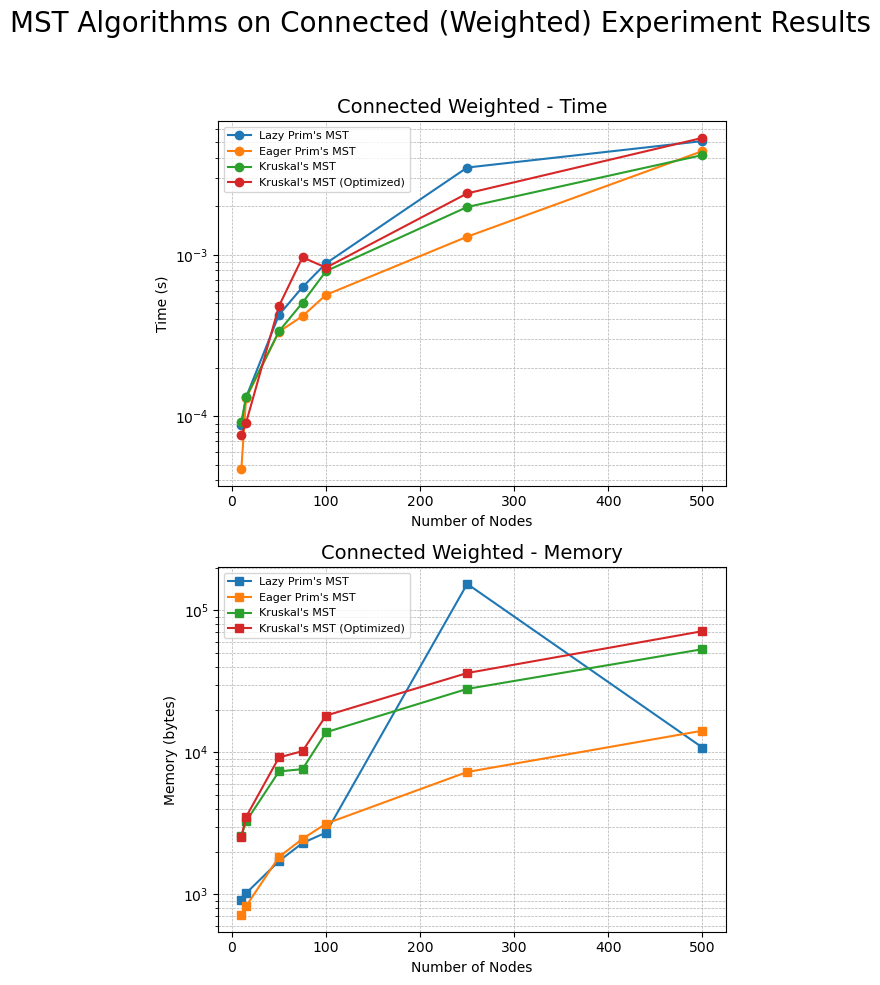

In [121]:
plot_experiment_results(
    df_conn,
    title_prefix="MST Algorithms on Connected (Weighted)",
    save_folder="graphs/mst/plots_analysis"
)

## Cyclic vs Acyclic

In [122]:
def create_cyclic_vs_acyclic_weighted_graph_mst(size, seed, acyclic):
    random.seed(seed)
    
    if acyclic:
        # Create an undirected tree (connected and acyclic)
        G = nx.random_tree(n=size, seed=seed)
    
    else:
        # Create an undirected, connected cyclic graph
        G = nx.erdos_renyi_graph(n=size, p=0.2, seed=seed)
        while not nx.is_connected(G):
            seed += 1
            G = nx.erdos_renyi_graph(n=size, p=0.2, seed=seed)

    for u, v in G.edges():
        G[u][v]['weight'] = random.randint(1, 10)

    return G

all_graphs_cyclic_weighted_mst = generate_graph_variations(
    node_sizes=node_sizes,
    seeds=seeds,
    variations=[True, False],  # True = acyclic (tree), False = cyclic (dense)
    graph_creator=create_cyclic_vs_acyclic_weighted_graph_mst,
    visualizer=lambda G, size, acyclic, folder: visualize_graph_networkx(
        G,
        name=f"{'acyclic' if acyclic else 'cyclic'}_{size}_nodes_weighted",
        folder=folder,
        layout="kamada_kawai",
        directed=False  # Now correctly undirected
    ),
    label_function=label_cyclic_graph_fd,
    folder_base="graphs/mst"
)


In [123]:
print("\nRunning MST algorithms on Cyclic vs Acyclic (Weighted, Undirected) graphs...\n")
combined_results_cycle = run_experiment_for_graphs(all_graphs_cyclic_weighted_mst, algo_wrappers_3)

print("\nGenerating Cyclic vs Acyclic MST performance table...\n")
df_results_cycle = create_results_table(combined_results_cycle, all_graphs_cyclic_weighted_mst, label_cyclic_graph_fd)


Running MST algorithms on Cyclic vs Acyclic (Weighted, Undirected) graphs...

Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 596.21it/s]


        10 |     0.000119 ± 0.000040 |             848 | 61
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 266.17it/s]


        10 |     0.000202 ± 0.000061 |             880 | 51
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 379.64it/s]


        15 |     0.000278 ± 0.000071 |             952 | 81
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 172.28it/s]


        15 |     0.000483 ± 0.000241 |           1,080 | 60
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 130.10it/s]


        50 |     0.000674 ± 0.000155 |           1,520 | 267
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 50.58it/s]


        50 |     0.002548 ± 0.000286 |           3,312 | 82
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 130.88it/s]


        75 |     0.000544 ± 0.000209 |           1,912 | 385
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 101.34it/s]

        75 |     0.001297 ± 0.000278 |           5,496 | 112


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 138.73it/s]

       100 |     0.000603 ± 0.000242 |           2,368 | 566


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 49.83it/s]


       100 |     0.002828 ± 0.000836 |         158,396 | 116
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 53.05it/s]


       250 |     0.002160 ± 0.000715 |         153,091 | 1408
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


       250 |     0.132952 ± 0.274229 |         311,640 | 251
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 31.30it/s]


       500 |     0.003440 ± 0.000818 |         157,456 | 2922
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


       500 |     0.063572 ± 0.003243 |       1,645,764 | 499
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 489.30it/s]


        10 |     0.000100 ± 0.000030 |             648 | 61
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 496.31it/s]


        10 |     0.000120 ± 0.000045 |             648 | 51
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 640.06it/s]


        15 |     0.000080 ± 0.000021 |             792 | 81
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        15 |     0.000137 ± 0.000034 |             856 | 60
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 156.60it/s]


        50 |     0.000476 ± 0.000040 |           1,640 | 267
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 273.40it/s]


        50 |     0.000697 ± 0.000127 |           2,312 | 82
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 141.58it/s]


        75 |     0.000787 ± 0.000255 |           2,232 | 385
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 81.78it/s]


        75 |     0.001594 ± 0.000307 |           3,192 | 112
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 136.44it/s]


       100 |     0.000695 ± 0.000232 |           2,888 | 566
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 41.28it/s]


       100 |     0.002375 ± 0.000781 |           4,680 | 116
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 70.08it/s]

       250 |     0.001320 ± 0.000073 |           6,632 | 1408


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 12.61it/s]

       250 |     0.012219 ± 0.001350 |         159,903 | 251


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       500 |     0.003597 ± 0.000823 |         160,731 | 2922

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 30.98it/s]



Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


       500 |     0.046117 ± 0.005620 |          23,812 | 499
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 497.72it/s]


        10 |     0.000072 ± 0.000021 |           2,568 | 61
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 727.67it/s]


        10 |     0.000093 ± 0.000021 |           2,568 | 51
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 496.25it/s]


        15 |     0.000103 ± 0.000028 |           3,256 | 81
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 487.03it/s]


        15 |     0.000173 ± 0.000022 |           3,256 | 60
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 262.92it/s]


        50 |     0.000336 ± 0.000062 |           7,336 | 267
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 100.03it/s]


        50 |     0.001234 ± 0.000101 |           8,800 | 82
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 220.93it/s]


        75 |     0.000489 ± 0.000057 |           7,336 | 385
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 46.02it/s]


        75 |     0.002595 ± 0.000214 |          15,336 | 112
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 179.75it/s]


       100 |     0.000625 ± 0.000028 |          13,464 | 566
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 37.82it/s]


       100 |     0.003806 ± 0.001295 |         161,311 | 116
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 68.04it/s]


       250 |     0.001413 ± 0.000220 |          26,320 | 1408
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


       250 |     0.027532 ± 0.008330 |         567,316 | 251
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 29.48it/s]


       500 |     0.003441 ± 0.000730 |         199,516 | 2922
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


       500 |     0.191324 ± 0.208339 |       2,058,344 | 499
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 493.68it/s]


        10 |     0.000165 ± 0.000075 |           2,536 | 61
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


        10 |     0.000316 ± 0.000114 |           2,536 | 51
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 486.63it/s]


        15 |     0.000143 ± 0.000026 |           3,504 | 81
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 296.96it/s]


        15 |     0.000271 ± 0.000083 |           3,504 | 60
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 190.68it/s]


        50 |     0.000502 ± 0.000161 |           9,216 | 267
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 62.20it/s]


        50 |     0.002570 ± 0.002570 |          10,680 | 82
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 164.68it/s]


        75 |     0.000580 ± 0.000070 |           9,216 | 385
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

        75 |     0.002896 ± 0.000025 |          17,919 | 112


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 20.19it/s]


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 123.05it/s]


       100 |     0.000754 ± 0.000273 |          17,768 | 566
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       100 |     0.009256 ± 0.007807 |         181,311 | 116

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]



Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       250 |     0.002185 ± 0.000486 |          35,240 | 1408

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 52.19it/s]



Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


       250 |     0.029399 ± 0.001515 |         481,992 | 251
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 40.49it/s]


       500 |     0.002844 ± 0.000430 |          69,480 | 2922
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

       500 |     0.201382 ± 0.114833 |       2,076,304 | 499

Generating Cyclic vs Acyclic MST performance table...


Algorithm Performance Table:
                Algorithm  Nodes         Graph Type Time (s) Memory (bytes)  Result
          Lazy Prim's MST     10 Acyclic (Weighted) 0.000119            848      61
          Lazy Prim's MST     10  Cyclic (Weighted) 0.000202            880      51
          Lazy Prim's MST     15 Acyclic (Weighted) 0.000278            952      81
          Lazy Prim's MST     15  Cyclic (Weighted) 0.000483          1,080      60
          Lazy Prim's MST     50 Acyclic (Weighted) 0.000674          1,520     267
          Lazy Prim's MST     50  Cyclic (Weighted) 0.002548          3,312      82
          Lazy Prim's MST     75 Acyclic (Weighted) 0.000544          1,912     385
          Lazy Prim's MST     75  Cyclic (Weighted) 0.001297          5,496     112
          Lazy Prim's MST    100 Acyclic (Weighted) 0.000603          2,368     566
          Laz

Plot saved to graphs/mst/plots_analysis\mst_algorithms_(cyclic_vs_acyclic)_experiment_results.png


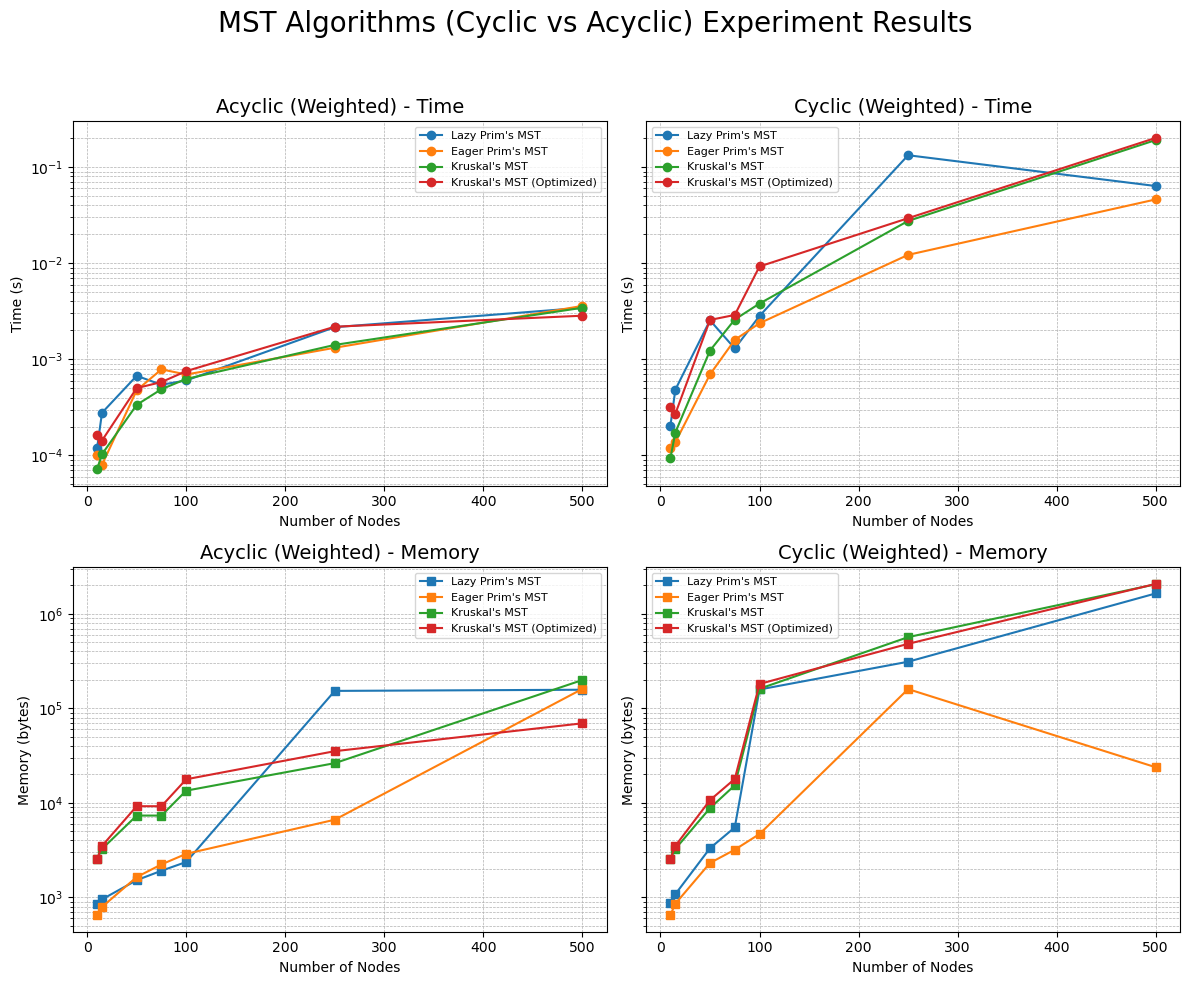

In [124]:
plot_experiment_results(
    df_results_cycle,
    title_prefix="MST Algorithms (Cyclic vs Acyclic)",
    save_folder="graphs/mst/plots_analysis"
)

## Trees

In [125]:
all_graphs_tree_weighted = generate_graph_variations(
    node_sizes=node_sizes,
    seeds=seeds,
    variations=["tree"],
    graph_creator=create_tree_weighted,
    visualizer=lambda G, size, _, folder: visualize_graph_networkx(
        G,
        name=f"tree_weighted_{size}_nodes",
        folder="graphs/mst/trees",
        layout="kamada_kawai",
        directed=False
    ),
    label_function=label_tree_weighted,
    folder_base="graphs/mst/trees"
)

In [126]:
print("\nRunning MST algorithms on Tree (Weighted) graphs...\n")
results_tree_weighted = run_experiment_for_graphs(all_graphs_tree_weighted, algo_wrappers_3)

print("\nGenerating MST performance table on trees...\n")
df_tree_weighted = create_results_table(results_tree_weighted, all_graphs_tree_weighted, label_tree_weighted)


Running MST algorithms on Tree (Weighted) graphs...

Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 181.79it/s]


        10 |     0.000206 ± 0.000043 |             848 | 46
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 182.31it/s]


        15 |     0.000261 ± 0.000114 |             920 | 76
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 133.48it/s]


        50 |     0.000470 ± 0.000071 |           1,520 | 258
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 68.81it/s]


        75 |     0.001524 ± 0.000677 |           1,944 | 426
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 33.61it/s]


       100 |     0.001954 ± 0.001075 |         150,658 | 498
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 64.90it/s]


       250 |     0.002019 ± 0.000875 |         152,999 | 1379
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       500 |     0.003730 ± 0.001806 |           9,052 | 2718

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 31.23it/s]



Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


        10 |     0.000069 ± 0.000028 |             648 | 46
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 495.96it/s]


        15 |     0.000076 ± 0.000034 |             760 | 76
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 258.38it/s]


        50 |     0.000218 ± 0.000047 |           1,640 | 258
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 166.71it/s]

        75 |     0.000519 ± 0.000043 |           2,264 | 426


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 141.65it/s]


       100 |     0.000447 ± 0.000067 |           2,888 | 498
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       250 |     0.001254 ± 0.000390 |           6,632 | 1379

Running experiments: 100%|██████████| 1/1 [00:00<00:00, 69.82it/s]



Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 32.12it/s]


       500 |     0.004118 ± 0.000688 |         160,409 | 2718
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

        10 |     0.000056 ± 0.000018 |           2,568 | 46

Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]



Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 215.46it/s]


        15 |     0.000170 ± 0.000043 |           3,256 | 76
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 659.48it/s]


        50 |     0.000177 ± 0.000030 |           7,336 | 258
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 205.89it/s]

        75 |     0.000512 ± 0.000164 |           7,336 | 426


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 184.69it/s]


       100 |     0.000549 ± 0.000025 |          13,464 | 498
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 57.81it/s]


       250 |     0.001431 ± 0.000116 |         162,603 | 1379
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 41.83it/s]

       500 |     0.003136 ± 0.000324 |          51,352 | 2718


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]

        10 |     0.000074 ± 0.000049 |           2,536 | 46
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------



Running experiments: 100%|██████████| 1/1 [00:00<00:00, 496.78it/s]


        15 |     0.000103 ± 0.000035 |           3,504 | 76
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 260.97it/s]


        50 |     0.000420 ± 0.000026 |           9,216 | 258
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 231.55it/s]


        75 |     0.000417 ± 0.000073 |           9,216 | 426
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 177.00it/s]


       100 |     0.000587 ± 0.000219 |          17,768 | 498
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 97.95it/s]


       250 |     0.001446 ± 0.000406 |          35,240 | 1379
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 26.28it/s]

       500 |     0.004269 ± 0.000327 |          69,480 | 2718



Generating MST performance table on trees...


Algorithm Performance Table:
                Algorithm  Nodes      Graph Type Time (s) Memory (bytes)  Result
          Lazy Prim's MST     10 Tree (Weighted) 0.000206            848      46
          Lazy Prim's MST     15 Tree (Weighted) 0.000261            920      76
          Lazy Prim's MST     50 Tree (Weighted) 0.000470          1,520     258
          Lazy Prim's MST     75 Tree (Weighted) 0.001524          1,944     426
          Lazy Prim's MST    100 Tree (Weighted) 0.001954        150,658     498
          Lazy Prim's MST    250 Tree (Weighted) 0.002019        152,999    1379
          Lazy Prim's MST    500 Tree (Weighted) 0.003730          9,052    2718
         Eager Prim's MST     10 Tree (Weighted) 0.000069            648      46
         Eager Prim's MST     15 Tree (Weighted) 0.000076            760      76
         Eager Prim's MST     50 Tree (Weighted) 0.000218          1,640     258
         Eager Prim's MST     75

Plot saved to graphs/mst/plots_analysis\mst_algorithms_on_tree_(weighted)_experiment_results.png


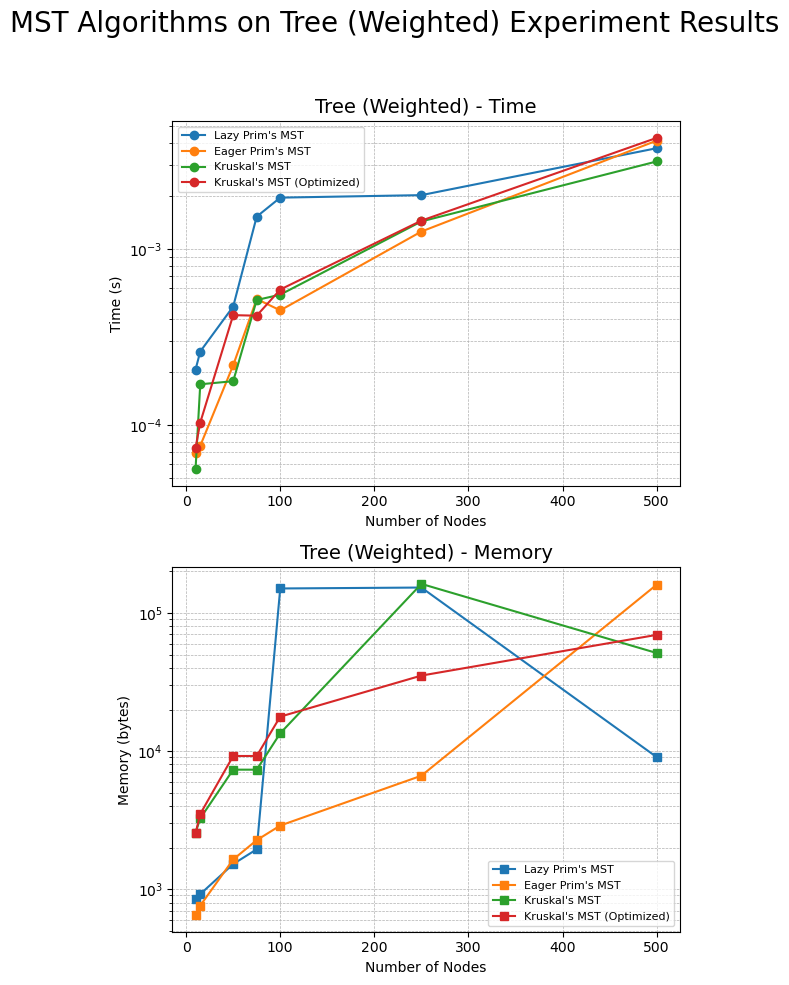

In [127]:
plot_experiment_results(
    df_tree_weighted,
    title_prefix="MST Algorithms on Tree (Weighted)",
    save_folder="graphs/mst/plots_analysis"
)

## Minimum Spanning Forest   (maybe not)

In [128]:
def label_disconnected_weighted(size, seed, variation):
    return f"Disconnected-{size} nodes"

In [129]:
def create_disconnected_weighted_graph(size, seed, _):
    random.seed(seed)
    G = nx.erdos_renyi_graph(n=size, p=0.02, seed=seed) 
    while nx.is_connected(G):
        seed += 1
        G = nx.erdos_renyi_graph(n=size, p=0.02, seed=seed)

    for u, v in G.edges():
        G[u][v]['weight'] = random.randint(1, 10)
    return G

In [130]:
def msf_wrapper(mst_algorithm):
    def wrapped(graph):
        if nx.is_connected(graph.to_undirected()):
            return mst_algorithm(graph)
        else:
            total_weight = 0
            for component in nx.connected_components(graph.to_undirected()):
                subgraph = graph.subgraph(component).copy()
                total_weight += mst_algorithm(subgraph)
            return total_weight
    return wrapped

In [131]:
algo_wrappers_msf = [
    ("Lazy Prim's MSF", msf_wrapper(lazy_prim_mst)),
    ("Eager Prim's MSF", msf_wrapper(eager_prim_mst)),
    ("Kruskal's MSF", msf_wrapper(kruskal_mst)),
    ("Kruskal's MSF (Optimized)", msf_wrapper(kruskal_mst_optimized)),
]

In [137]:
all_graphs_disconnected_weighted = generate_graph_variations(
    node_sizes=node_sizes,
    seeds=seeds,
    variations=["disconnected"],
    graph_creator=create_disconnected_weighted_graph,
    visualizer=lambda G, size, _, folder: visualize_graph_networkx(
        G,
        name=f"disconnected_{size}_nodes_weighted",
        folder=folder,
        layout="kamada_kawai",
        directed=False
    ),
    folder_base="graphs/mst/disconnected"
)

labels_disconnected = [f"Disconnected-{size} nodes" for _, size, _ in all_graphs_disconnected_weighted]

In [138]:
print("\nRunning MSF algorithms on Disconnected (Weighted) graphs...\n")
results_disconnected = run_experiment_for_graphs(all_graphs_disconnected_weighted, algo_wrappers_msf)

print("\nGenerating MSF performance table...\n")
df_disconnected = create_results_table(
    results_disconnected,
    all_graphs_disconnected_weighted,
    labels_disconnected
)


Running MSF algorithms on Disconnected (Weighted) graphs...

Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 494.67it/s]


Error at input size 10: 0
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 496.25it/s]


Error at input size 15: 0
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 490.39it/s]


Error at input size 50: 0
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 198.42it/s]


Error at input size 75: list index out of range
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 90.82it/s]


Error at input size 100: list index out of range
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 20.55it/s]


Error at input size 250: list index out of range
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]

Error at input size 500: list index out of range


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<?, ?it/s]


Error at input size 10: 0
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 908.84it/s]


Error at input size 15: 0
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 409.88it/s]


Error at input size 50: 0
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 172.58it/s]


Error at input size 75: list index out of range
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 105.58it/s]


Error at input size 100: list index out of range
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 28.01it/s]


Error at input size 250: list index out of range
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

Error at input size 500: list index out of range

Running experiments: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]



Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 107.52it/s]


        10 |     0.000883 ± 0.000235 |          18,120 | 14
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 46.71it/s]


        15 |     0.002664 ± 0.000882 |         172,399 | 26
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 17.27it/s]


        50 |     0.005559 ± 0.001653 |          63,440 | 116
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 12.70it/s]

        75 |     0.008372 ± 0.001749 |          95,992 | 225


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 12.68it/s]

       100 |     0.007951 ± 0.001632 |         124,936 | 455


Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


       250 |     0.049365 ± 0.009881 |         472,192 | 731
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


       500 |     0.140122 ± 0.021020 |       1,726,968 | 867
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 156.82it/s]


        10 |     0.000823 ± 0.000198 |          18,184 | 14
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 68.00it/s]


        15 |     0.001701 ± 0.000792 |          24,376 | 26
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00, 16.09it/s]


        50 |     0.007261 ± 0.001776 |          63,440 | 116
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]


        75 |     0.014625 ± 0.011274 |         244,483 | 225
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

       100 |     0.022326 ± 0.013261 |         124,936 | 455

Running experiments: 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]



Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


       250 |     0.034478 ± 0.002554 |         628,872 | 731
Input Size |     Time (s) |  Memory (bytes) |     Result
----------------------------------------------------------


Running experiments: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]

       500 |     0.182596 ± 0.059276 |       1,893,416 | 867

Generating MSF performance table...



TypeError: 'list' object is not callable

In [ ]:
plot_experiment_results(
    df_results_msf,
    title_prefix="Minimum Spanning Forest Algorithms (Disconnected Graphs)",
    save_folder="graphs/mst/plots_analysis"
)